# Error analysis notebook

## Import packages

In [1]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")


## Set filepaths

### Eval (should run only once)

In [1]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_default_nle_meta_9_1_theta=0.9.json'
eval_result = '../evaluation/resources/2020/eval_results/p_controller_default_nle_meta_9_1_theta=0.9.tsv'
gt = '../pre_processing/resources/evaluation/2020/TREC-Fair-Ranking-eval-sample.json'

### Test

In [ ]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_default_nle_meta_9_1_theta=0.9.json'
eval_result = '../evaluation/resources/2020/eval_results/p_controller_default_nle_meta_9_1_theta=0.9.tsv'
gt = '../pre_processing/resources/evaluation/2020/TREC-Fair-Ranking-eval-sample.json'

## Prepare dataframes

In [3]:
# ranking df
rdf = pd.read_json(ranking, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result df
edf = pd.read_csv(eval_result, sep='\t', names=['key', 'qid', 'value'])
edf = edf.pivot(index='qid', columns='key', values='value')

In [4]:
rdf.head(2)

q_num   qid                                            ranking
0    0.0  9087  [c68374b97eb2c214afd3c282175f664fc37c5682, 008...
1    0.1  9087  [cbc33164f9db97698901f130f399f2898d856267, 008...

In [5]:
gtdf.head(2)

qid             query  frequency  \
0  9087  lepidium sativum   0.000013   
0  9087  lepidium sativum   0.000013   

                                           documents  \
0  {'doc_id': '40d8bea494d4ff4c46f7ad5cb2dcdaa6f9...   
0  {'doc_id': '008a2a2c765485af2e035a2572ba9fc110...   

                                     doc_id  doc_rel  
0  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4        1  
0  008a2a2c765485af2e035a2572ba9fc1102eabff        1

In [6]:
reldf.head(2)

qid             query                                    doc_id  doc_rel
0  9087  lepidium sativum  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4        1
0  9087  lepidium sativum  008a2a2c765485af2e035a2572ba9fc1102eabff        1

In [7]:
edf.head(2)

key  difference  disparity  relevance
qid                                  
95     0.351999   2.936763   1.949844
612    0.991691   1.731472   1.256254

## Select queries/rankings to inspect

[1] select the queries/rankings to inspect based on the MAP value of the rankings. One of the criteria is to select queries whose ranking's MAP is lower than the average for all queries/systems. The metric for our system is Difference in Group Expected Exposure (DGEE).

The mean DGEE across all rankings returned by the P-controller system is 0.428894655. There are 62 queries with a DGEE higher than this mean value, and 138 queries with a DGEE that is lower than the mean. We inspect both top and bottom queries to discover why the ranker performs well on some queries and poorly on others.

In [8]:
edf.difference.mean()

0.428894655

There are 62 items with a difference higher than the total mean, and 138 items with a difference lower than the total mean.

In [9]:
print(edf[edf.difference > edf.difference.mean()].describe())
print()
print(edf[edf.difference <= edf.difference.mean()].describe())

key    difference  disparity  relevance
count   62.000000  62.000000  62.000000
mean     0.960277   1.759598   0.988859
std      0.647813   0.420930   0.328687
min      0.437043   0.998512   0.255715
25%      0.561969   1.469473   0.740174
50%      0.757819   1.671765   1.037014
75%      1.068128   1.899918   1.255380
max      3.700546   2.879598   1.564463

key    difference   disparity   relevance
count  138.000000  138.000000  138.000000
mean     0.190157    1.964270    1.521551
std      0.094710    0.568135    0.452830
min      0.019822    0.985687    0.696810
25%      0.117196    1.623796    1.193393
50%      0.161651    1.865743    1.385916
75%      0.264914    2.230541    1.860925
max      0.409372    3.813899    2.685266


The worst ten queries are:

In [10]:
edf.sort_values(by='difference',ascending=False).head(10)

key     difference  disparity  relevance
qid                                     
657       3.700546   2.631709   0.255715
100510    3.252370   2.703133   0.514383
16607     3.034450   2.557715   0.550634
89881     1.987253   1.570899   0.577918
12885     1.941179   1.874742   0.848831
18060     1.725684   1.519402   0.684165
59483     1.619563   1.586472   0.469430
52501     1.429890   1.625181   0.943276
89569     1.210698   1.378091   0.572047
2438      1.193136   1.397599   0.397092

The best ten queries are:

In [11]:
edf.sort_values(by='difference',ascending=True).head(10)

key    difference  disparity  relevance
qid                                    
91643    0.019822   1.006921   0.868206
5191     0.044683   1.448939   1.344147
81479    0.046552   2.044160   1.889465
21237    0.053041   1.358547   1.149610
7363     0.053171   1.313280   1.085770
18112    0.057675   1.327767   1.079491
61688    0.061505   1.061153   0.834400
4319     0.063171   1.892463   1.585866
43723    0.065366   1.839158   1.496630
51335    0.071198   1.577270   1.252222

## Extract information for specific query

In [12]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [13]:
extract_results_based_on_qid(657, rdf).head(5)

q_num  qid                                            ranking
24150  161.0  657  [1436449e0234166b13135df45be1f072df059007, 863...
24151  161.1  657  [18f883bd5b9ab9771e561a0214af6bd5ddda0d61, 863...
24152  161.2  657  [e9cfbf58d87e9f5afae813e8b8294b7719c176da, b79...
24153  161.3  657  [128611b63b268a1bffb69d3276a11ae7f6b068d7, 3c9...
24154  161.4  657  [e686c4e74d9085c78813355d582102d973b157cf, b79...

In [14]:
extract_relevances_based_on_qid(657, reldf).head(5)

qid query                                    doc_id  doc_rel
161  657  iran  a1b0feb1f82716b0e343453ca214912cfd3ea0e5        0
161  657  iran  b59004dc46558189fa4d846029ccb1ce3f079484        0
161  657  iran  17475d93c5d0b5b6396aa1d3a3928d6154b65695        0
161  657  iran  1436449e0234166b13135df45be1f072df059007        0
161  657  iran  18f883bd5b9ab9771e561a0214af6bd5ddda0d61        0

## Visualization

We use different visualizations to gain more insight into the way rankings are formed.

- Given a query with N documents to be re-ranked, for each rank in a list of size N we compute the number of times a relevant or non-relevant item appears at this rank. For poorly performing queries, we expect to see more non-relevant items in top positions and fewer relevant items. These plots can show us whether the relevant items occur towards the middle or the back of the rankings instead.
    - We either plot the relevant and non-relevant items per rank in the same plot, or in separate plots. The separate plots are more readable, since the number of relevant and non-relevant documents across 150 rankings are in different orders of magnitude.
    
    
- Given a query with N documents to be re-ranked, for a specific rank in a list of size N we compute how often each of the documents occurs at that rank. We color-code the documents by relevant/non-relevant. In an ideal scenario, we expect all relevant documents to occur roughly equally as often at the top positions, and more often than non-relevant documents at that. For non-relevant documents, we expect the same behavior at bottom positions. Departures from this behavior can show us whether there are documents that are treated differently than they should. Inspecting these documents may teach us more about *why* they show up in a place where they do not belong.


- Complementary to the previous plot, we show the number of times each document occurs in a "top" or in a "bottom" position. Under the expected exposure model [2], an ideal ranking is any ranking where all documents with a higher relevance grade are followed by all documents with a lower relevance grade. For example, if doc1 and doc2 both have relevance 1, then a ranking that starts as [doc1, doc2, ...] is identical in quality to one that starts with [doc2, doc1, ...]. A "top" position is then any position with rank <= # relevant documents, and a "bottom" position is any position with rank > # relevant documents. 

  In an ideal scenario, we expect each relevant document to occur equally as often in a "top" position, and each non-relevant document to occur equally as often in a "bottom" position. The additional information gained by this plot compared to the previous plot is that we can see whether there are documents that are systematically in a "wrong" (top if they are non-relevant, bottom if they are relevant) position, where the previous plot only shows if they are missing from a *specific* top or bottom rank.

- 


We visualize how often a ranking position is occupied by a relevant versus a non-relevant document, aggregated over all 150 returned rankings for that query.


In [15]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

In [16]:
def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)
    

In [17]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [18]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

In [19]:
def count_doc_occurrence_per_rank(rankings_df):
    """Count how often each document occurs at each rank."""
    count_per_doc_per_rank = {i: {} for i in list(range(1,len(rankings_df['ranking'].iloc[0]) + 1))}

    for idx, row in rankings_df.iterrows():
        for j, doc in enumerate(row['ranking']):
            i = j + 1
            if not doc in count_per_doc_per_rank[i]:
                count_per_doc_per_rank[i][doc] = 0
            count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
    return count_per_doc_per_rank

In [20]:
def doc_occurrence_per_rank_to_sns_df(occurrence_dict, relevance_df):
    unpacked = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in occurrence_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [21]:
def count_pos_of_documents(ranking_df, num_relevant_docs):
    doc_pos_count_dict = {}

    for idx, row in ranking_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            if not doc in doc_pos_count_dict:
                doc_pos_count_dict[doc] = {"top": 0, "bot": 0}
            if i < num_relevant_docs:
                doc_pos_count_dict[doc]["top"] = doc_pos_count_dict[doc]["top"] + 1
            else:
                doc_pos_count_dict[doc]["bot"] = doc_pos_count_dict[doc]["bot"] + 1

    return doc_pos_count_dict        

In [22]:
def document_pos_count_to_sns_df(doc_pos_count_dict, relevance_df):
    unpacked = [d for dlist in [[{'doc_id':k, 'pos':k2, 'count':v2} for k2, v2 in v.items()] for k,v in doc_pos_count_dict.items()] for d in dlist]
    unpacked_df = pd.DataFrame(unpacked)

    return pd.merge(unpacked_df,reldf[['doc_id','doc_rel']],on='doc_id',how='left')

In [23]:
def plot_rel_nonrel_per_rank(data):
    """Plot the number of times a (non)relevant item appeared at a rank."""
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x="rank", y="count", hue="relkind", data=data)

In [24]:
def plot_rel_nonrel_per_rank_per_relkind(data,regline=False):
    """Plot the number of times a (non)relevant item appeared at a rank, split by rank."""
    
    pi = iter(sns.color_palette())
    f = next(pi)
    s = next(pi)
    next(pi)
    t = next(pi)

    fig, ax = plt.subplots(1,2,figsize = (17.7,8.27))
    ax[0].title.set_text('Relevant item counts')
    ax[1].title.set_text('Nonrelevant item counts')

    sns.barplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0],color=f)
    sns.barplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1],color=s)

    if regline:
        sns.regplot(x="rank", y="count", data=data[data.relkind=='r'],ax=ax[0], scatter_kws={"s": 0}, color=t)
        sns.regplot(x="rank", y="count", data=data[data.relkind=='nr'],ax=ax[1], scatter_kws={"s": 0},color=t)
    return fig


In [25]:
def plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subranking, subrelevance)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    fig = plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,regline=regline)
    fig.suptitle(f"(Non-)relevant documents per rank for {qid}")
    

In [26]:
def plot_doc_occurrence_per_rank(data, k=2, rev=False):
    """Show how often each document in :data: appears at each rank <= k."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)
    
    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")
    
#     numrows = math.ceil(num_rel_docs / 2)
    fig, ax = plt.subplots(1, k, figsize = (9*k, 8))
    
    for i in range(0,k):
        rank = i + 1
        if rev:
            rank = len(set(data["rank"].to_list())) - rank
    
        thisaxdata = data[data['rank'] == rank].sort_values(by='count',ascending=False)
        
    
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        ax[i].title.set_text(f'Rank {rank}')
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
    return fig

In [27]:
def plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance, k=2, rev=False):
        subranking = extract_results_based_on_qid(qid, ranking)
        subrelevance = extract_relevances_based_on_qid(qid, relevance)
                
        doc_per_rank_counts = count_doc_occurrence_per_rank(subranking)
        rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subrelevance)
    
        fig = plot_doc_occurrence_per_rank(rank_occurrence_df, k, rev)
        fig.suptitle(f"Document counts per rank for {qid}")
    
    

In [28]:
tmp = pd.DataFrame({'a':[1,2,3],'b':[2,3,4]})[['a','b']]
list(zip(tmp.a.to_list(),tmp.b.to_list()))

[(1, 2), (2, 3), (3, 4)]

In [29]:
def plot_doc_pos_count(data,numrel,numnrel,no_author_ids=None):
    """Plot how many times each document occurred in the top and bottom positions."""
    sns.set_palette("tab10")
    pi = iter(sns.color_palette())
    first = next(pi)
    second = next(pi)

    data["doc_labels"] = data.doc_id.apply(lambda row: f"{row[:4]}...")


    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    _ = ax[0].title.set_text(f'Occurrence of doc in top pos (k={numrel})')
    _ = ax[1].title.set_text(f'Occurrence of doc in bottom pos (k={numnrel})')

    for i, pos in enumerate(["top","bot"]):
        _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = -70)
        thisaxdata = data[data['pos'] == pos].sort_values(by='doc_rel',ascending=False)
        
        
       
        
        clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list()]
        
#         sc_bar = sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])
        sns.barplot(x="doc_labels", y="count",palette=clrs, data=thisaxdata,ax=ax[i])

#         strange_id = thisaxdata.doc_id.to_list().index('87af1c341c257b2d2a702a10ac6dd8af04a9db02')
        
        if no_author_ids:
            thisaxdata['secondcount'] = thisaxdata.apply(lambda row: row['count'] if row['doc_id'] in no_author_ids else 0, axis=1)
            sns.barplot(x="doc_labels", y="secondcount",palette=clrs, data=thisaxdata,ax=ax[i],hatch='//')
#             hatches = ['//' if doc_id in no_author_ids else '..' for doc_id in thisaxdata.doc_id.to_list()]
#             bars = sc_bar.patches
#             print(bars)
#             for pat,bar in zip(hatches,bars):
#                 bar.set_hatch(pat)
#             print(hatches[strange_id])

        
     
        ax[i].legend(labels=["rel","nonrel"], title='relkind')
        
        leg = ax[i].get_legend()
        leg.legendHandles[0].set_color(first)
        leg.legendHandles[1].set_color(second)
        
  
    return fig


In [30]:
def plot_doc_pos_count_for_qid(qid, ranking, relevance, no_author_ids=None):
    subranking = extract_results_based_on_qid(qid, ranking)
    subrelevance = extract_relevances_based_on_qid(qid,relevance)
    num_rel_docs, num_nonrel_docs = count_relgrades(subrelevance)
    doc_position_counts = count_pos_of_documents(subranking, num_rel_docs)
    doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subrelevance)
    fig = plot_doc_pos_count(doc_pos_count_df,num_rel_docs,num_nonrel_docs,no_author_ids)


    fig.suptitle(f"Document position counts {qid}")

    

In [31]:
def plots_for_qid(qid,ranking,relevance,k=2):
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=False)
    plot_rel_nonrel_per_rank_per_relkind_for_qid(qid, ranking, relevance, regline=True)

    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k)
    plot_doc_occurrence_per_rank_for_qid(qid, ranking, relevance,k,rev=True)
    plot_doc_pos_count_for_qid(qid, ranking, relevance)

In [32]:
plotoptions_qid = ["plot_rel_nonrel_per_rank_per_relkind_for_qid","plot_doc_occurrence_per_rank_for_qid","plot_doc_pos_count_for_qid"]

### QID: 657

We inspect the the worst-performing query, query 657.

In [33]:
qid = 657
subrdf = extract_results_based_on_qid(qid, rdf)
subreldf = extract_relevances_based_on_qid(qid,reldf)

In [34]:
rel_counts = subreldf.doc_rel.value_counts()
rel_count = rel_counts[1]
nonrel_count = rel_counts[0]

In [35]:
rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)

In [36]:
rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
rel_nonrel_df.head(4)

rank relkind  count
0     1       r      1
1     1      nr    149
2     2       r      7
3     2      nr    143

We plot the number of relevant/nonrelevant items that appear at each rank. An issue with this approach is that most rankings contain more nonrelevant than relevant items. As a result, there bars for the nonrelevant items are on a different scale than those for the relevant items. This makes the plot harder to read.

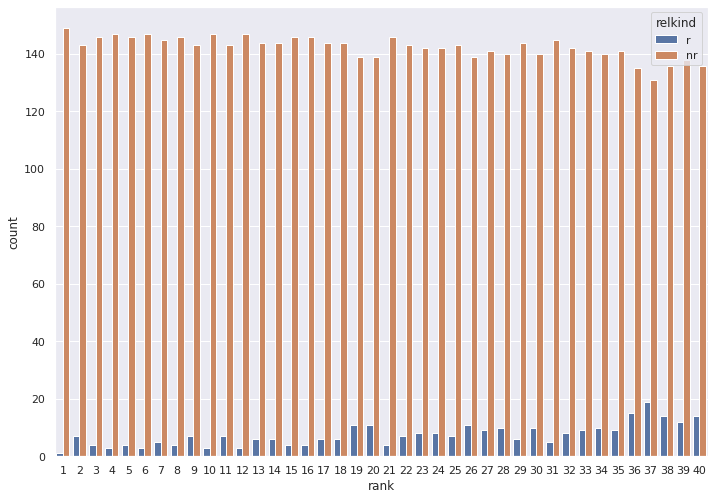

In [37]:
plot_rel_nonrel_per_rank(rel_nonrel_df)

We split the plot into relevant and nonrelevant item counts for readability.

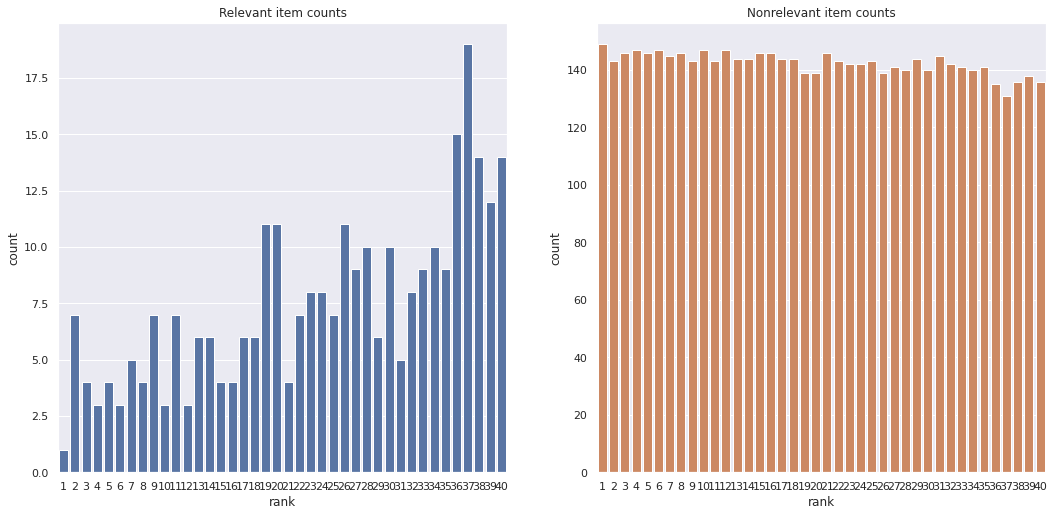

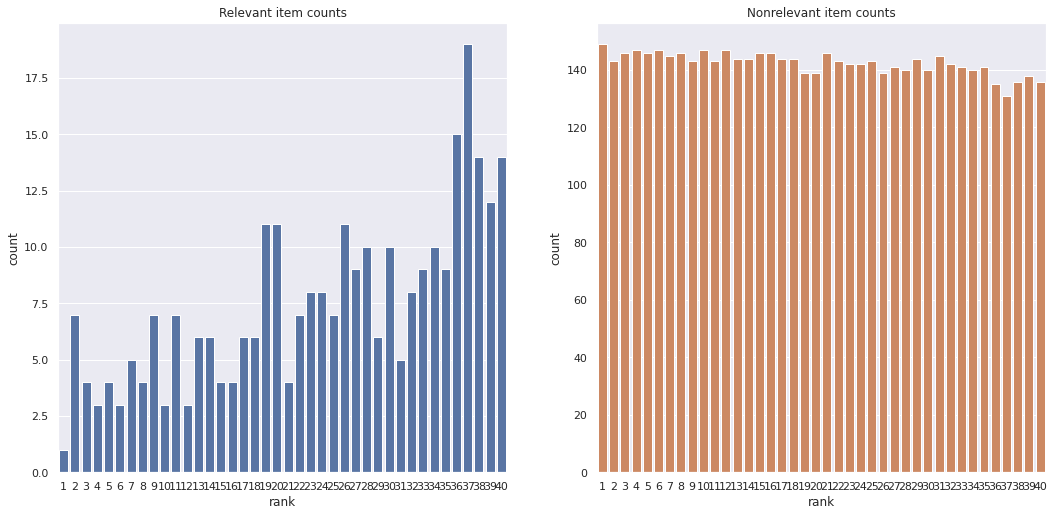

In [38]:
plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,regline=False)

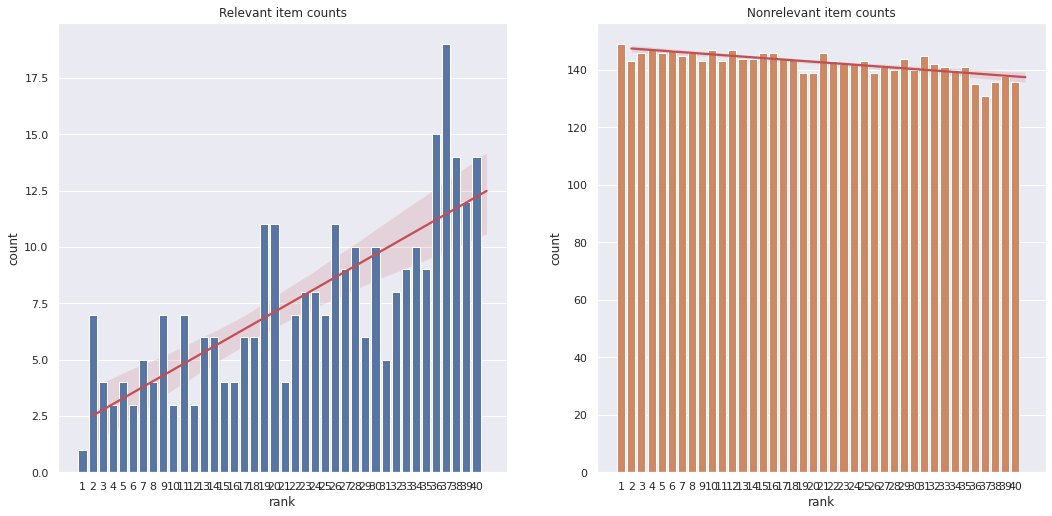

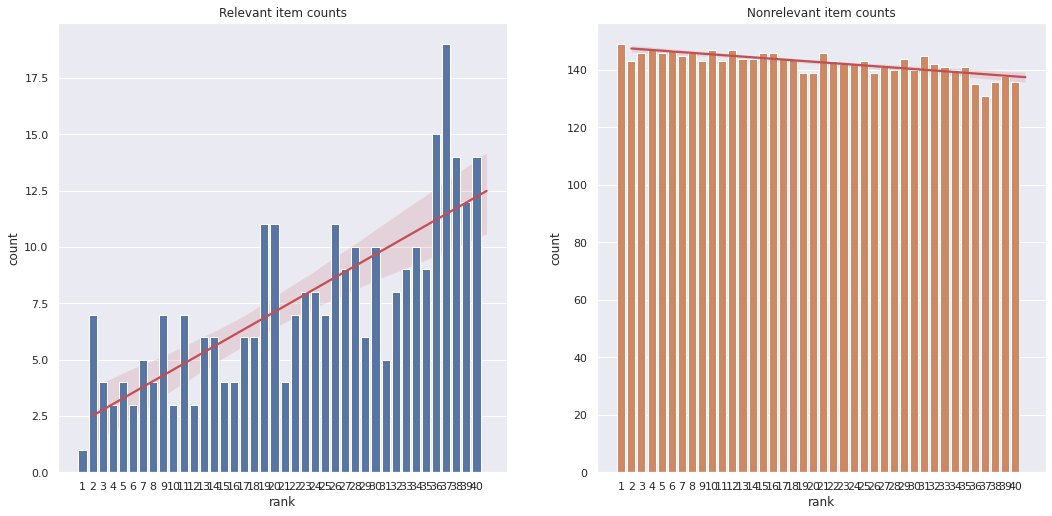

In [39]:
plot_rel_nonrel_per_rank_per_relkind(rel_nonrel_df,regline=True)

We see that the number of relevant items *increases* with increasing rank. This makes sense for a query that performs poorly, but we don't yet know *why* the relevant items are ranked towards the back. After all, if we ranked completely at random we would expect a uniform distribution instead.

In [40]:
doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)

In [41]:
rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts,subreldf)
rank_occurrence_df.head(4)

rank                                    doc_id  count  doc_rel
0     1  1436449e0234166b13135df45be1f072df059007      7        0
1     1  18f883bd5b9ab9771e561a0214af6bd5ddda0d61      6        0
2     1  e9cfbf58d87e9f5afae813e8b8294b7719c176da      6        0
3     1  128611b63b268a1bffb69d3276a11ae7f6b068d7      5        0

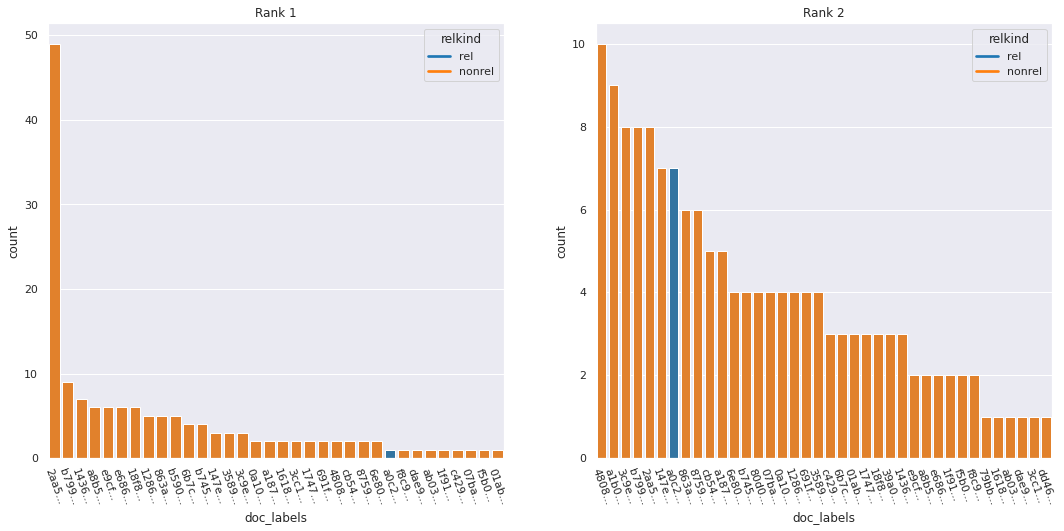

In [42]:
_ = plot_doc_occurrence_per_rank(rank_occurrence_df,2)

In the figures above we see how many times each document was put in the first or second ranking position, aggregated across 150 rankings. The blue line indicates which document is relevant; only one relevant document is put in either the first or second rank, and only one time in the first and 5 times in the second ranking.

We also want to know how often each file was in a top position and how often it was in a bottom position. In the ideal case, we expect each relevant file to be equally often in the top positions and each irrelevant file to be equally often in the bottom positions.

In [43]:
doc_position_counts = count_pos_of_documents(subrdf, rel_count)

In [44]:
doc_pos_count_df = document_pos_count_to_sns_df(doc_position_counts, subreldf)
doc_pos_count_df.head(5)

doc_id  pos  count  doc_rel
0  1436449e0234166b13135df45be1f072df059007  top     10        0
1  1436449e0234166b13135df45be1f072df059007  bot    140        0
2  863a0360e4345b2e106e4f44cd95821f68b28036  top     11        0
3  863a0360e4345b2e106e4f44cd95821f68b28036  bot    139        0
4  e9cfbf58d87e9f5afae813e8b8294b7719c176da  top      8        0

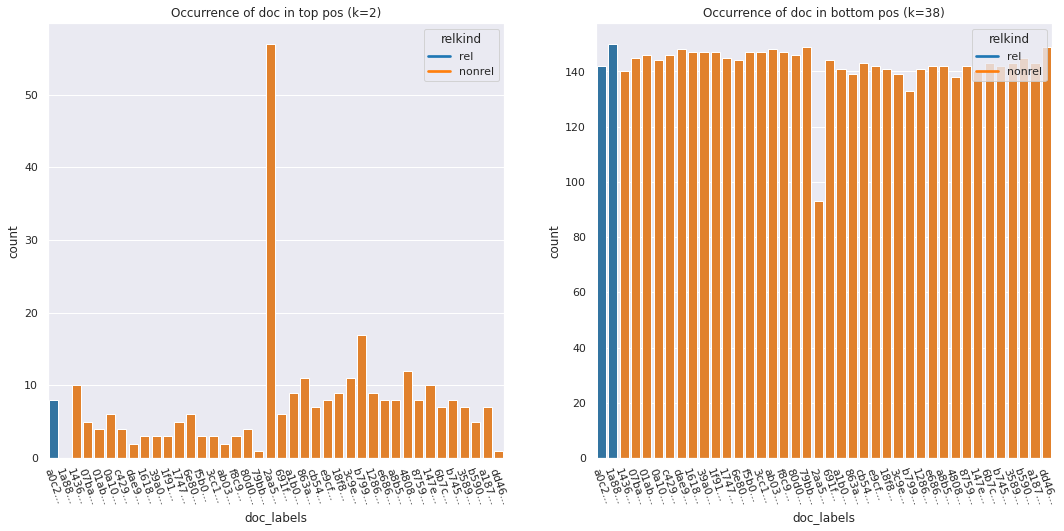

In [45]:
_ = plot_doc_pos_count(doc_pos_count_df,2,38)


We see that only one of the relevant files occurs in the top positions, and that one of the non-relevant files appears markedly less often in a bottom positions.

### Multiple queries
Let's compare multiple queries and see if we can determine a pattern.

We see that poor performance does not necessarily mean that relevant documents are clustered towards the bottom rankings. For queries 100510, 16607, and 89881 the distribution of relevant items more closely resembles a normal distribution.

In [46]:
topqueries = edf.sort_values(by='difference',ascending=True).head(10)
bottomqueries = edf.sort_values(by='difference',ascending=False).head(10)

#### (Non-)relevant documents at each rank
For the top and bottom k=10 queries, we plot the number of (non-)relevant items at each rank.

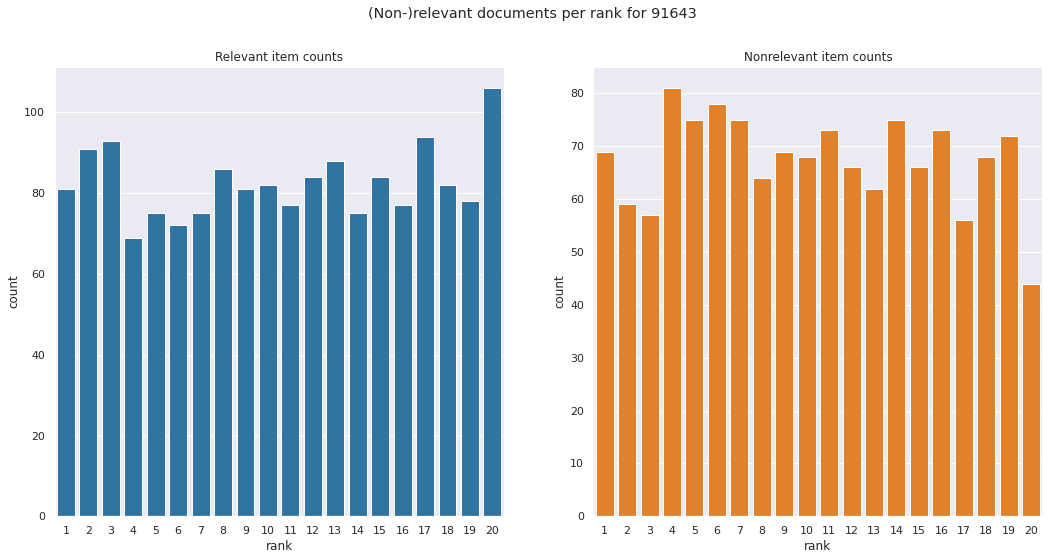

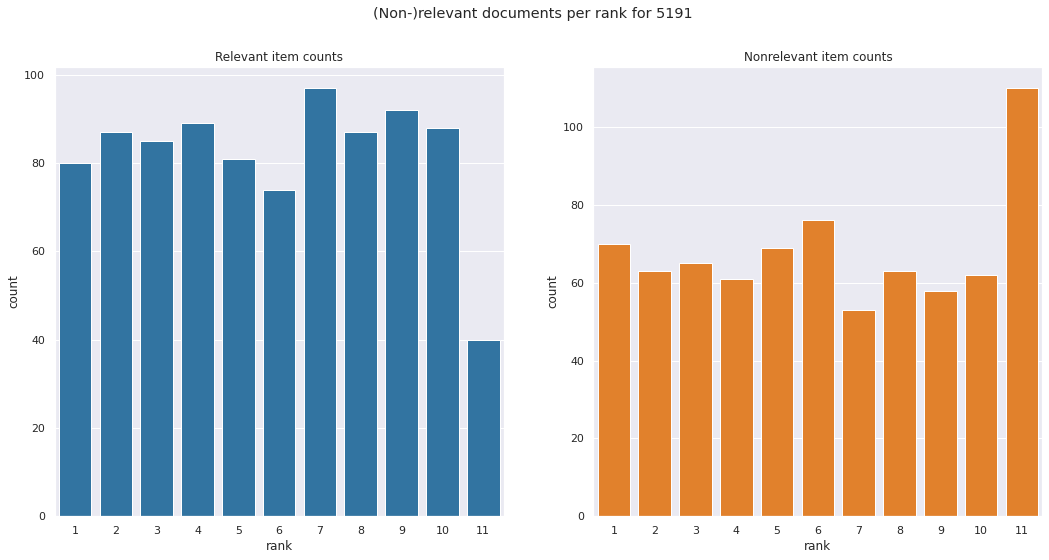

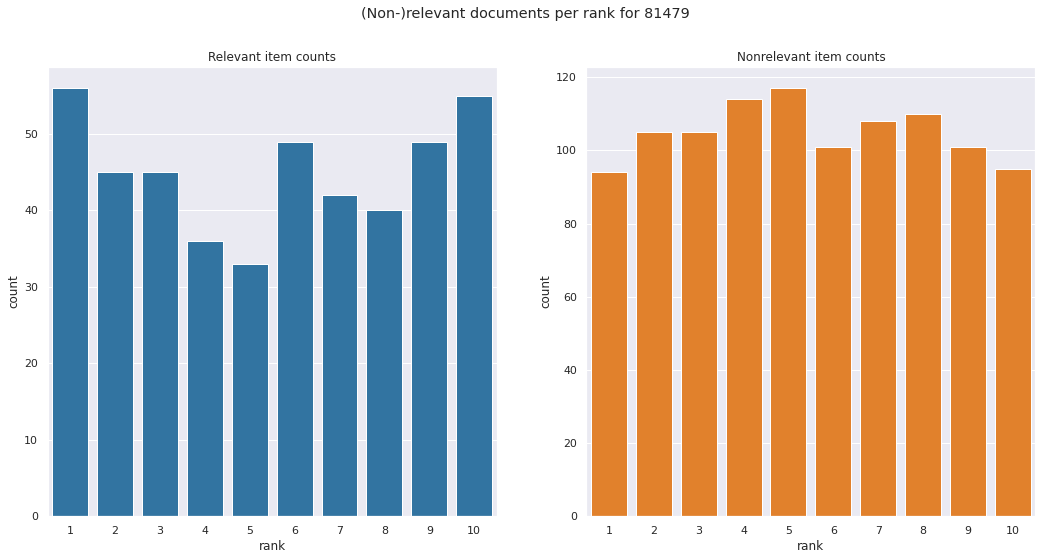

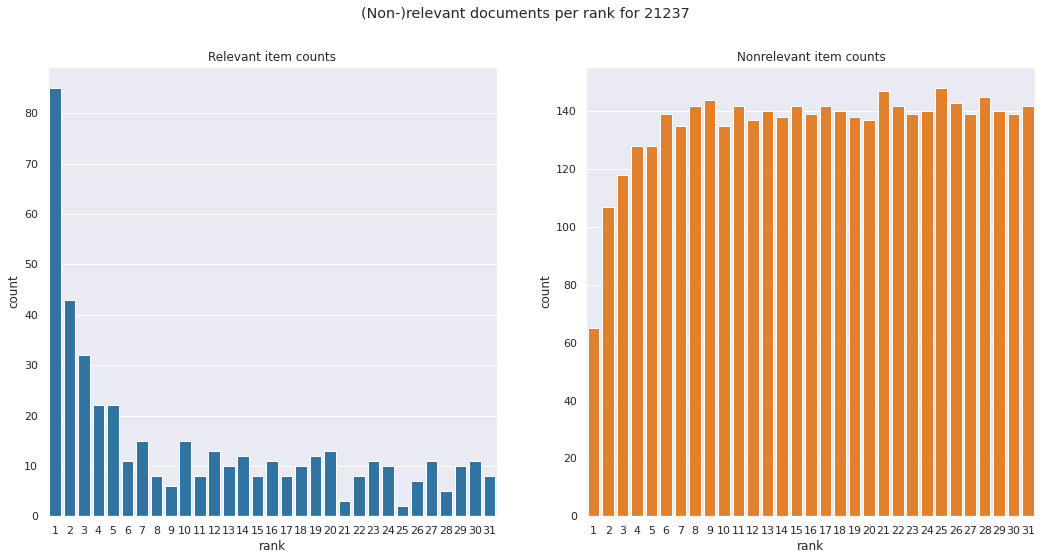

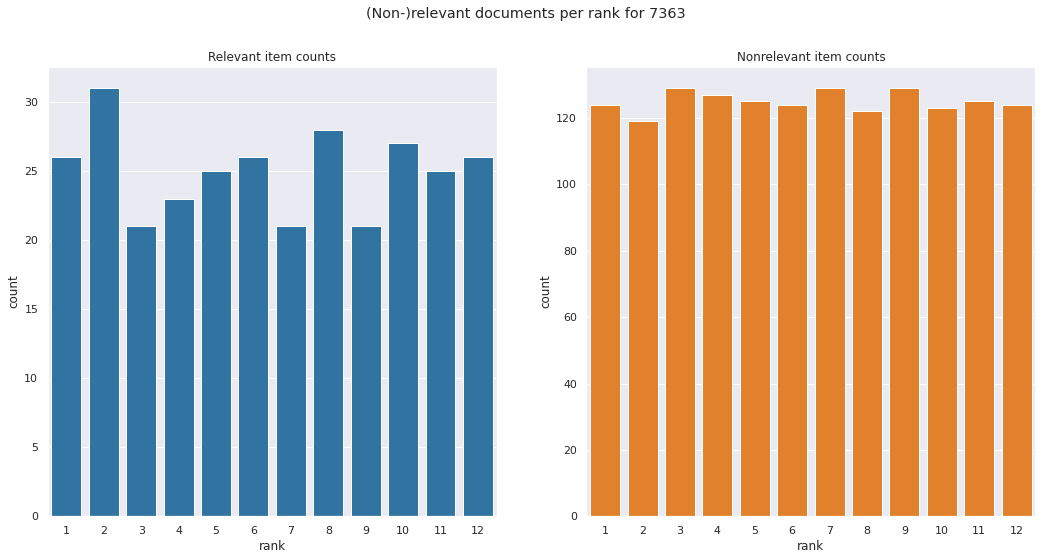

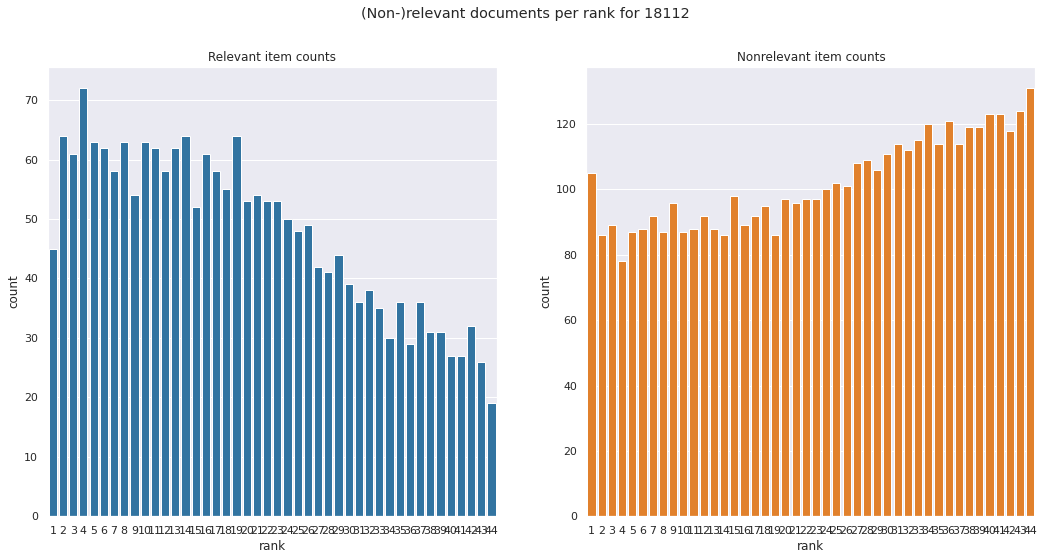

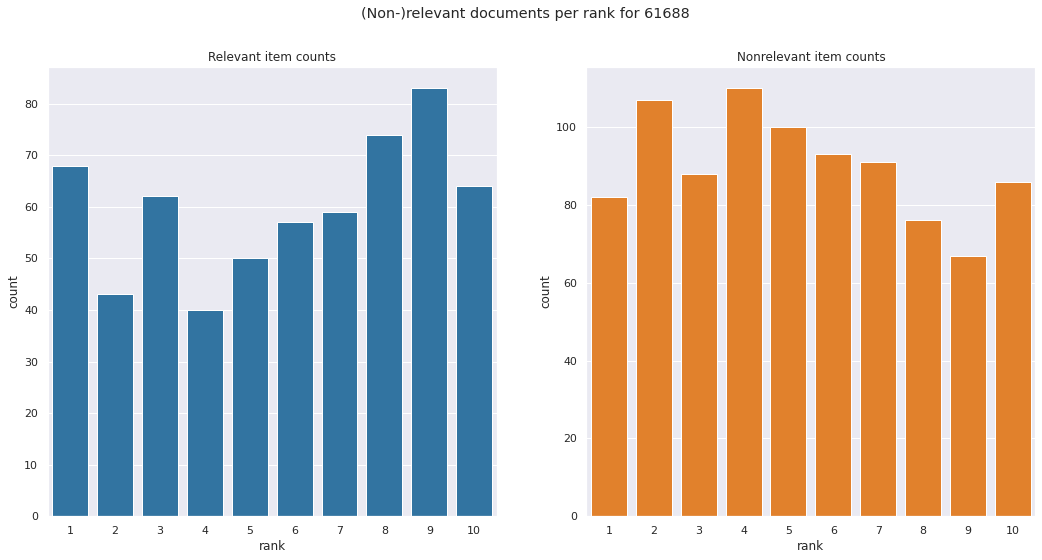

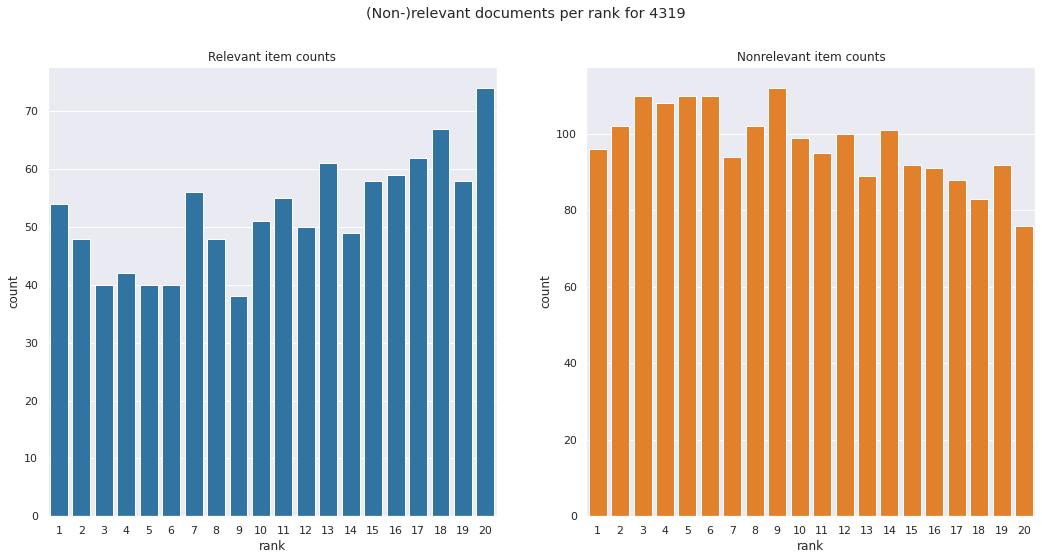

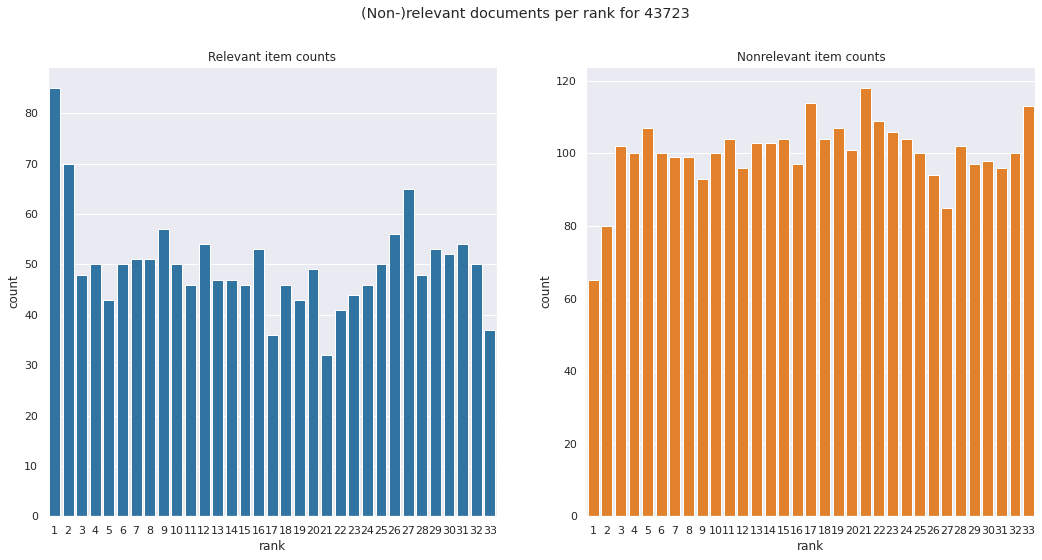

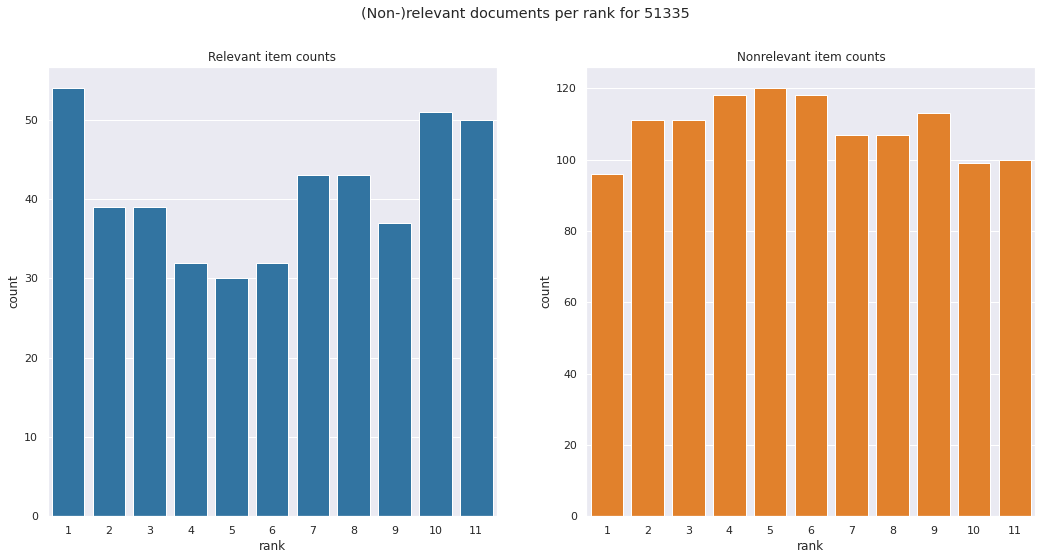

In [47]:
for q in topqueries.index.unique():
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)


##### Top queries
For the top queries, we see that the relevant documents are reasonably evenly distributed or skewed towards the higher rankings.

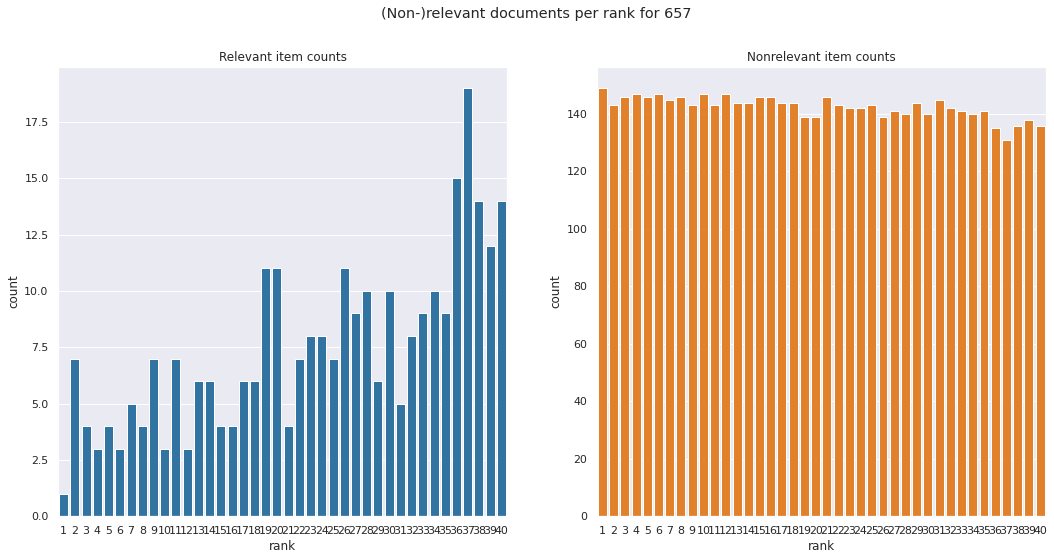

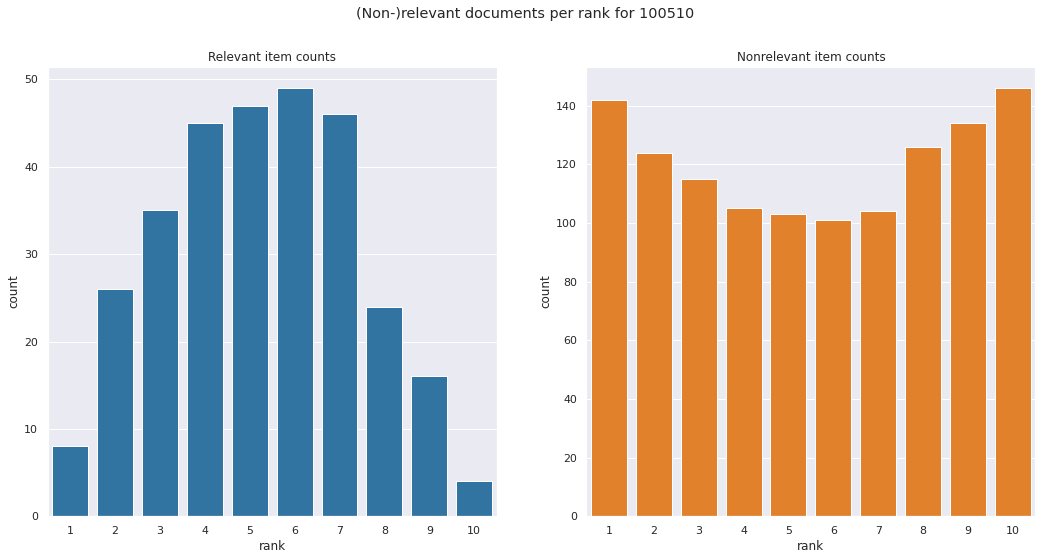

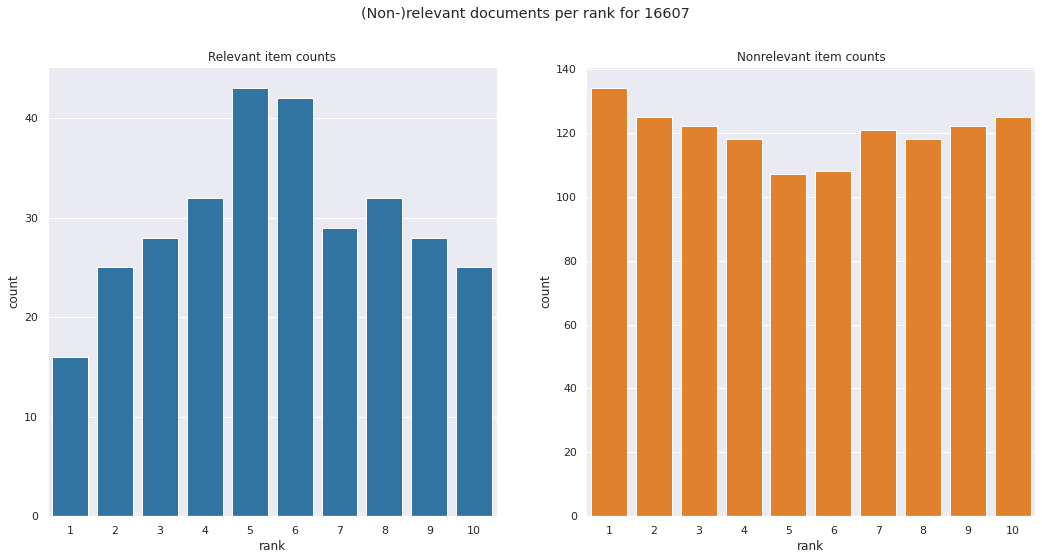

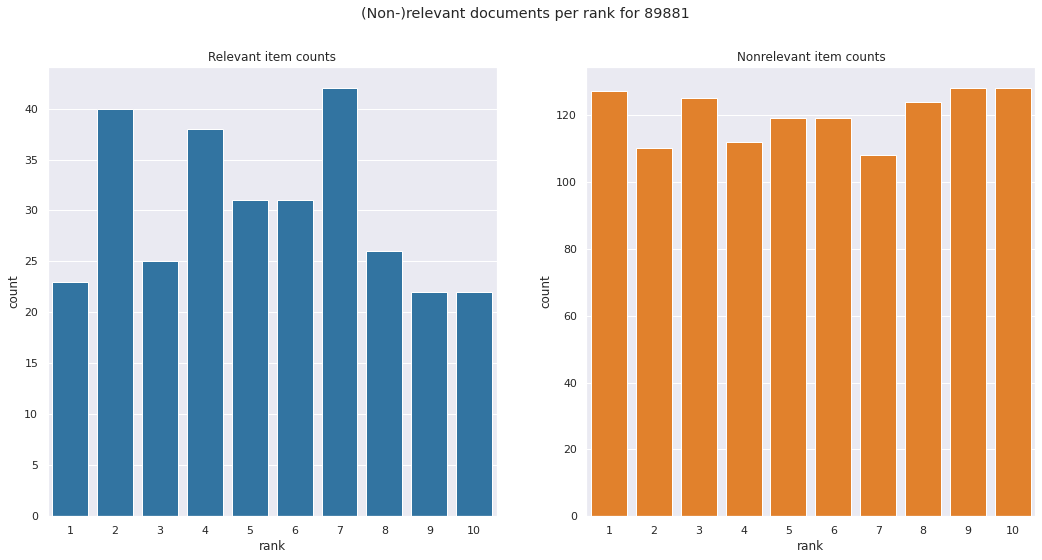

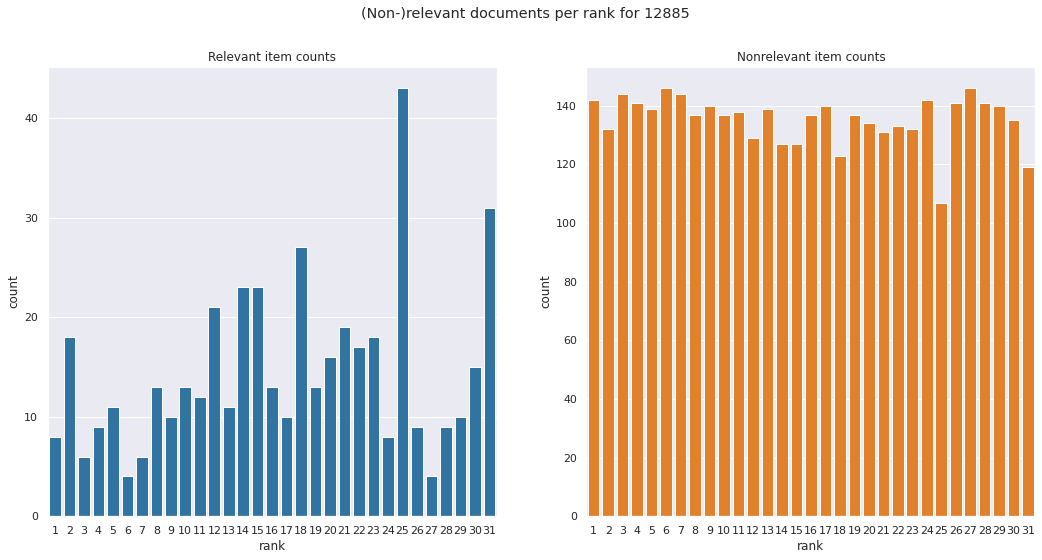

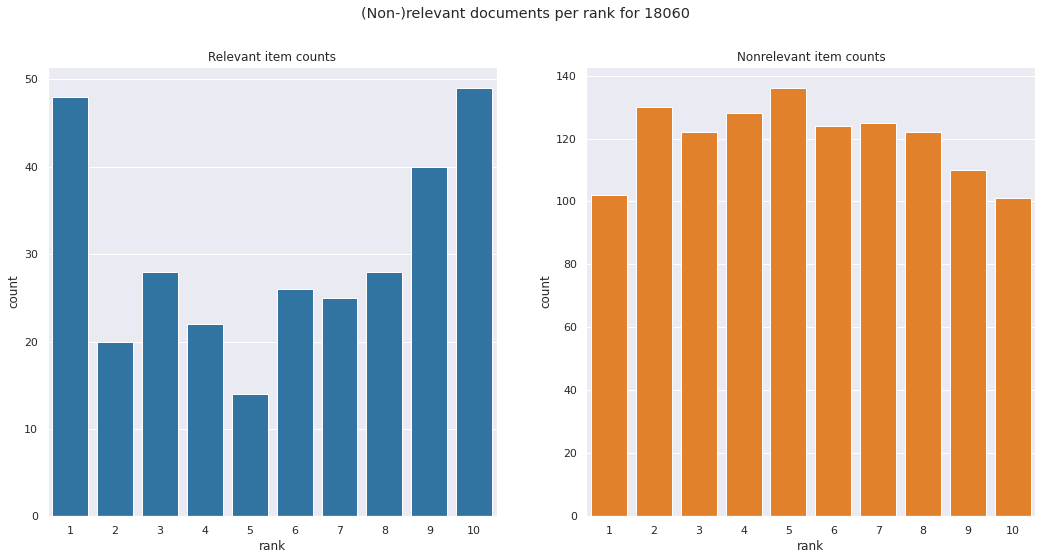

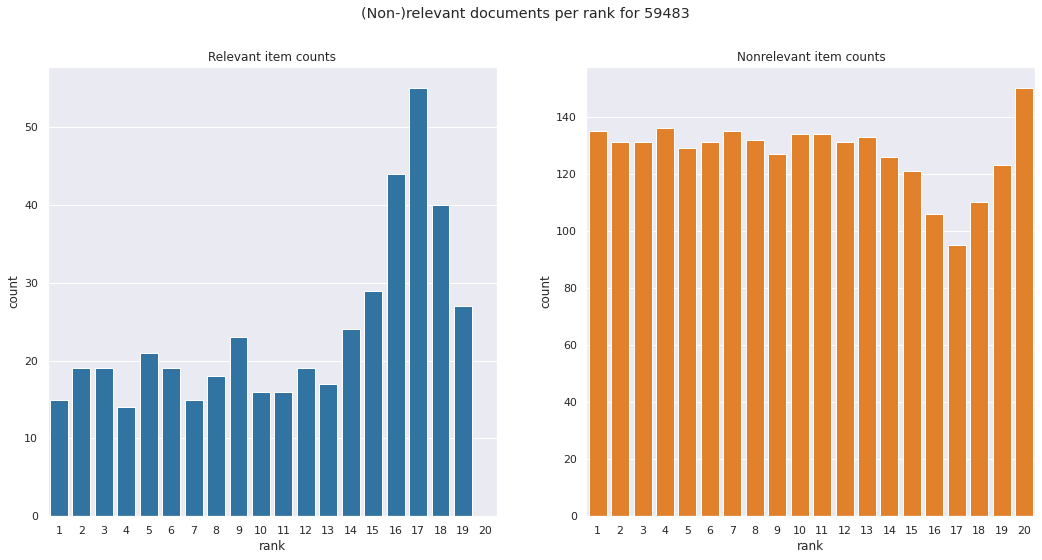

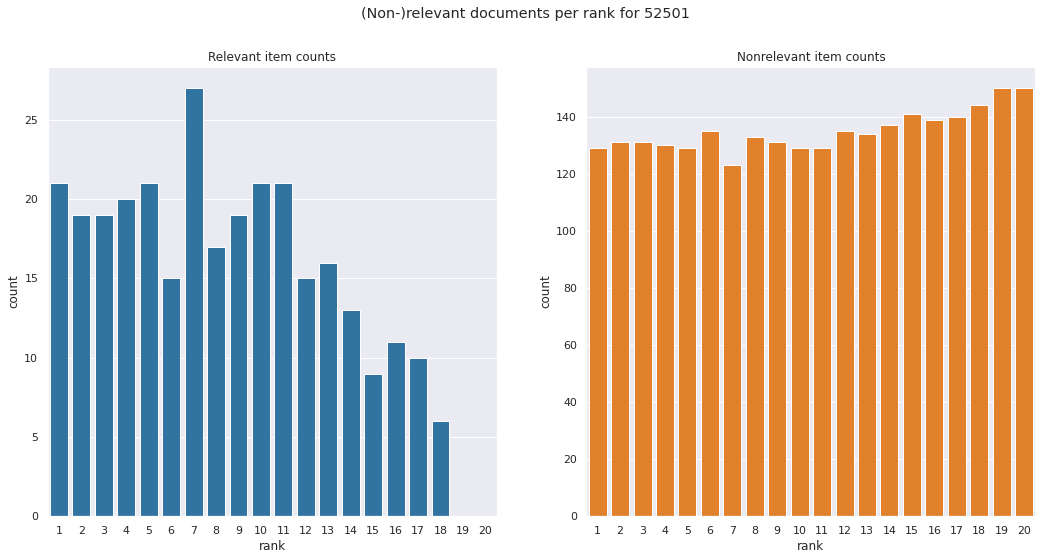

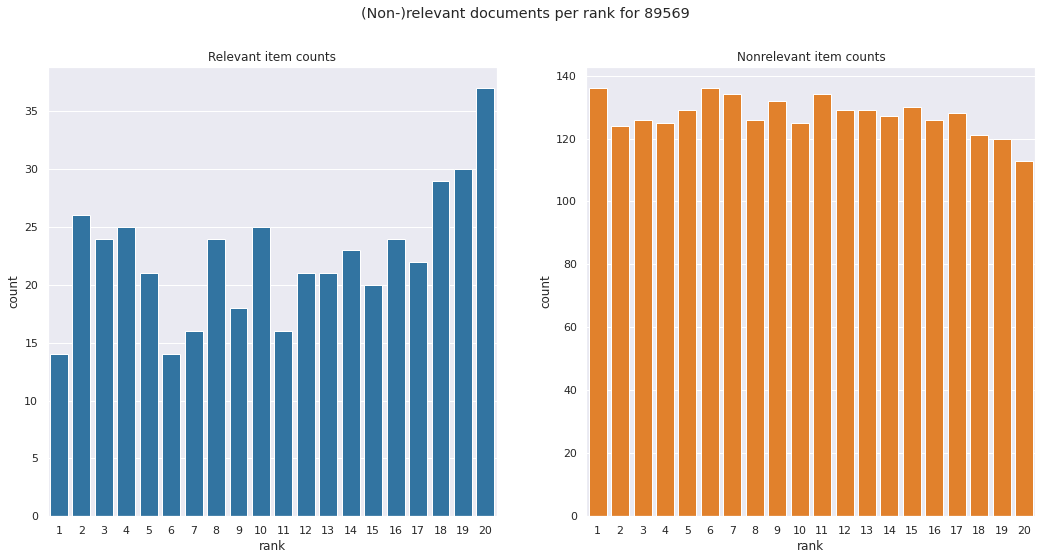

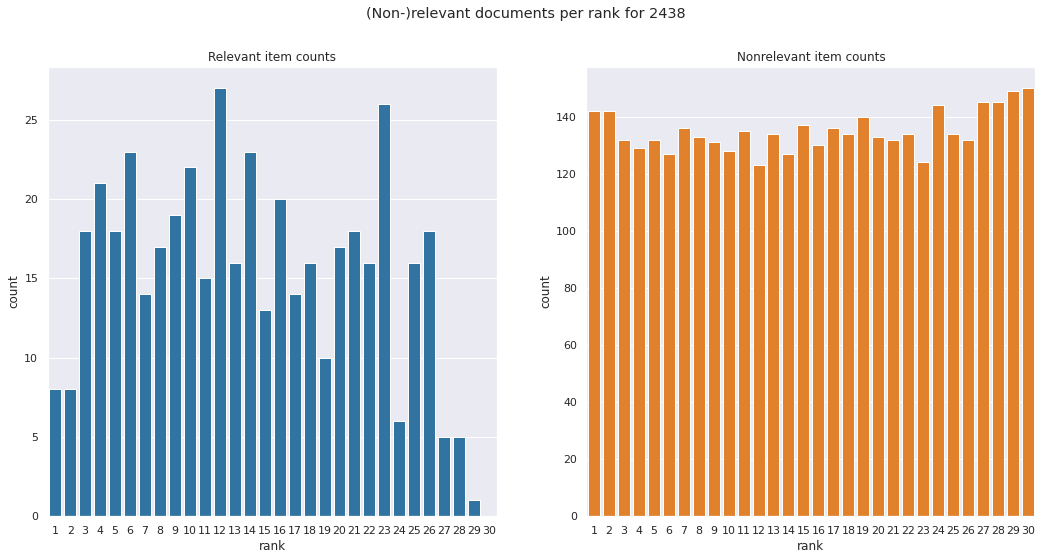

In [48]:
for q in bottomqueries.index.unique():
    plot_rel_nonrel_per_rank_per_relkind_for_qid(q, rdf, reldf)


##### Bottom queries
For the bottom queries we see that the relevant items are concentrated to either the middle or bottom ranks. **An exception is query 52501, where the relevant documents skew towards the top positions, and no relevant items are in the bottom positions at all.**

#### Doc occurrence per rank
We plot how often each document occurs at each rank. We plot all of the top positions and the bottom 5 positions.

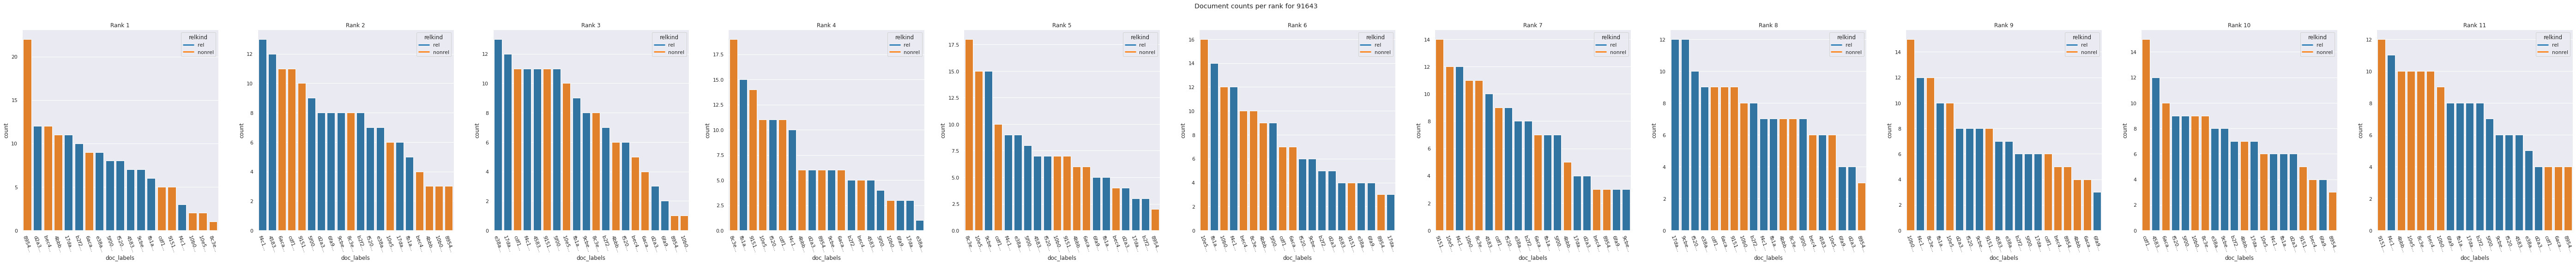

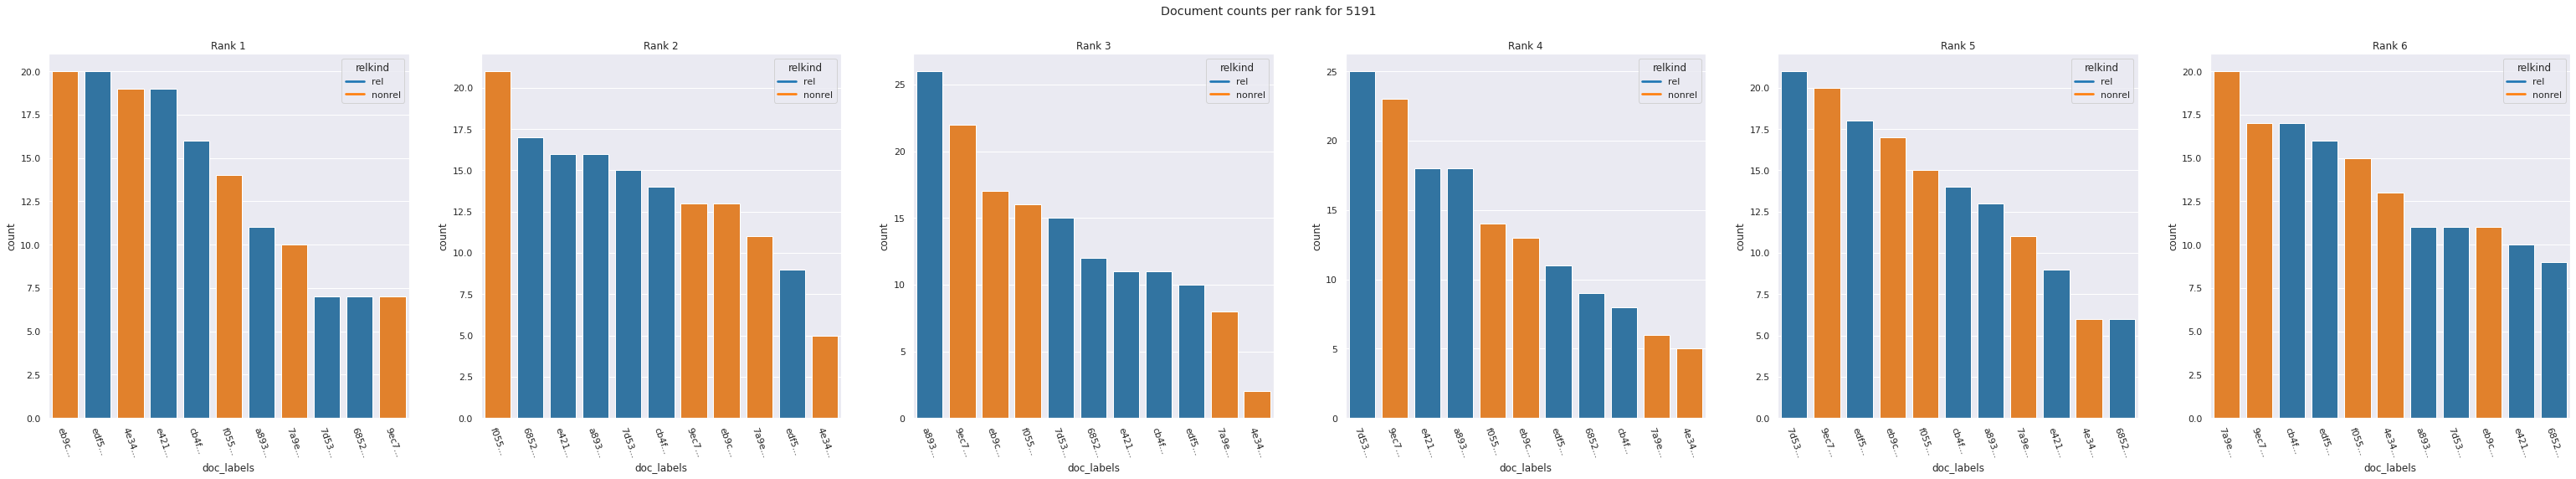

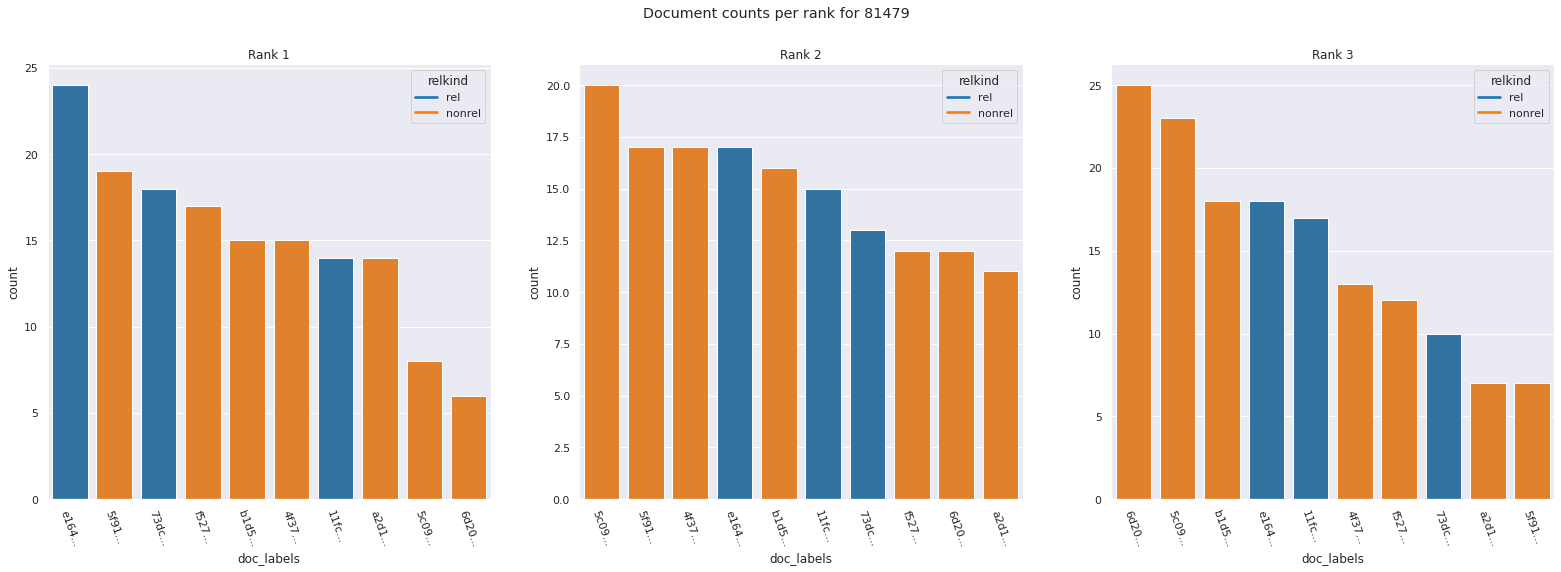

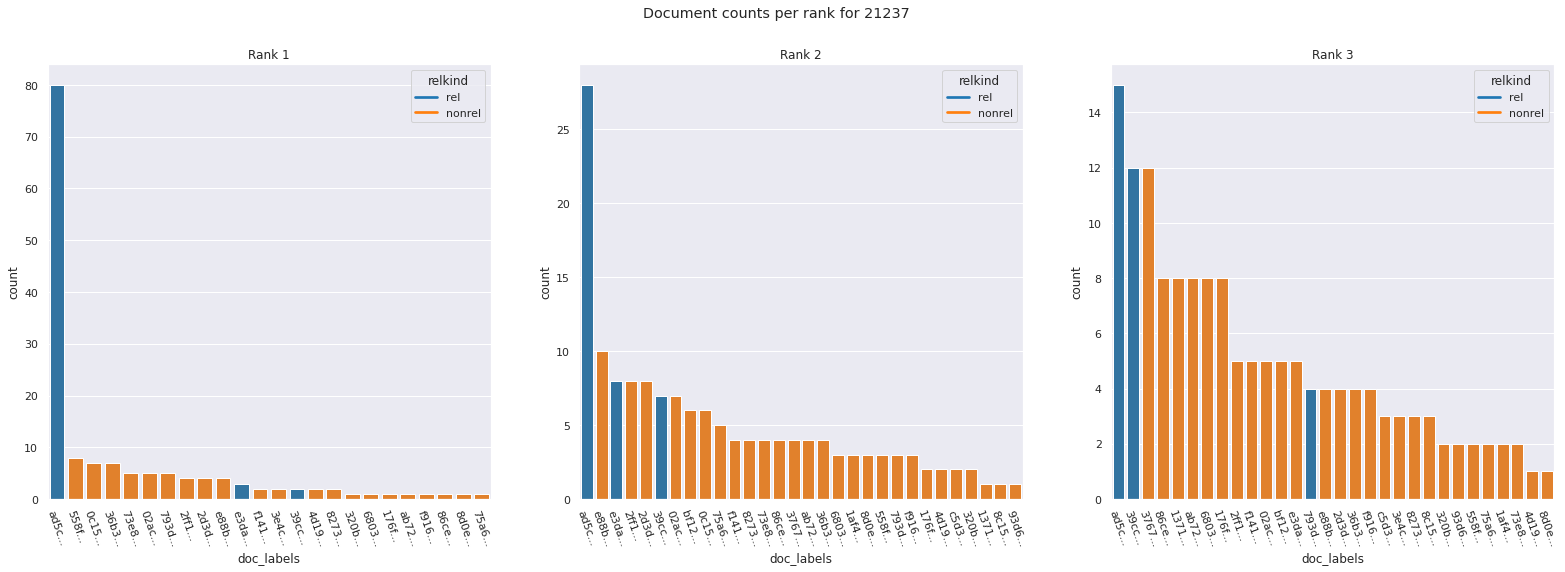

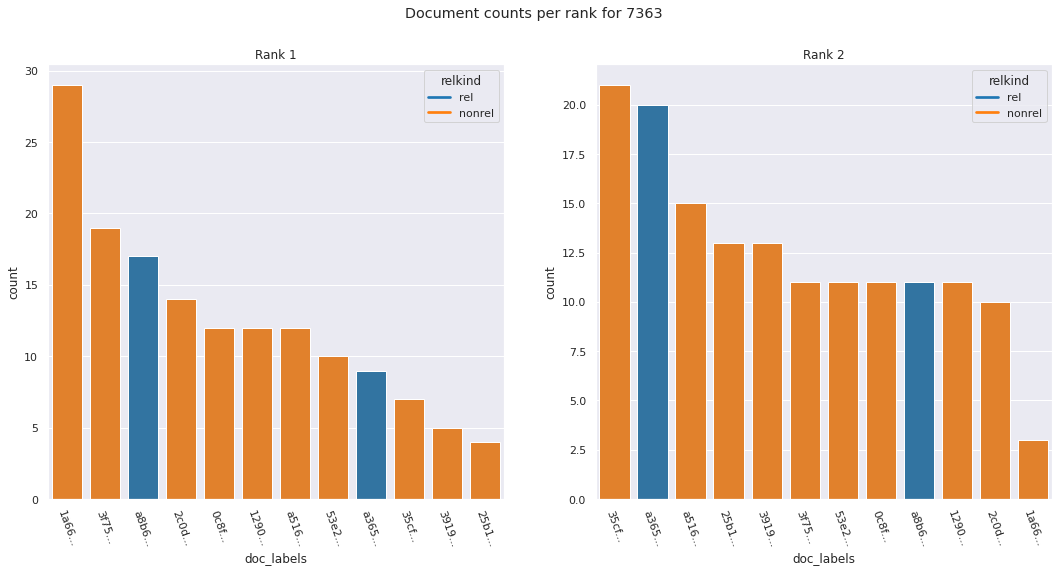

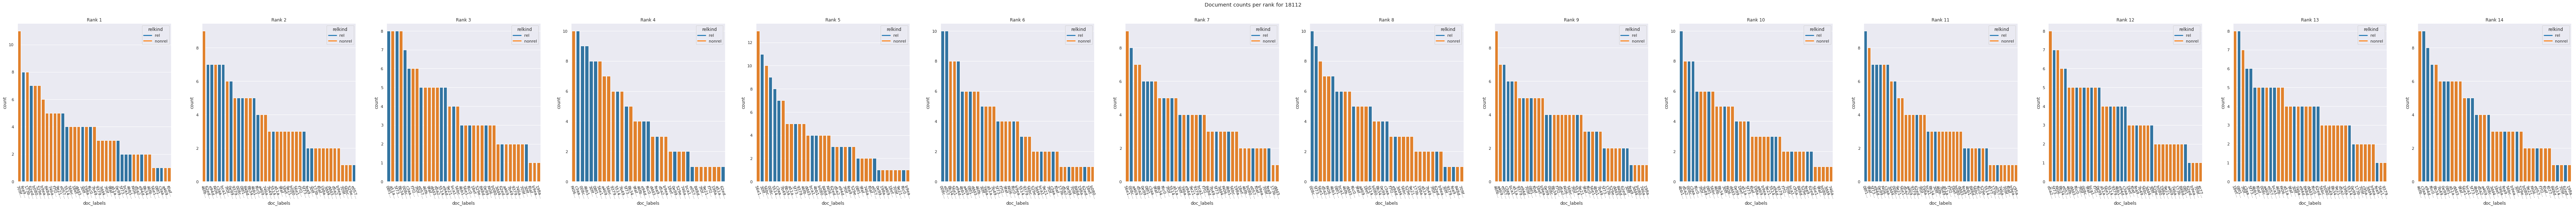

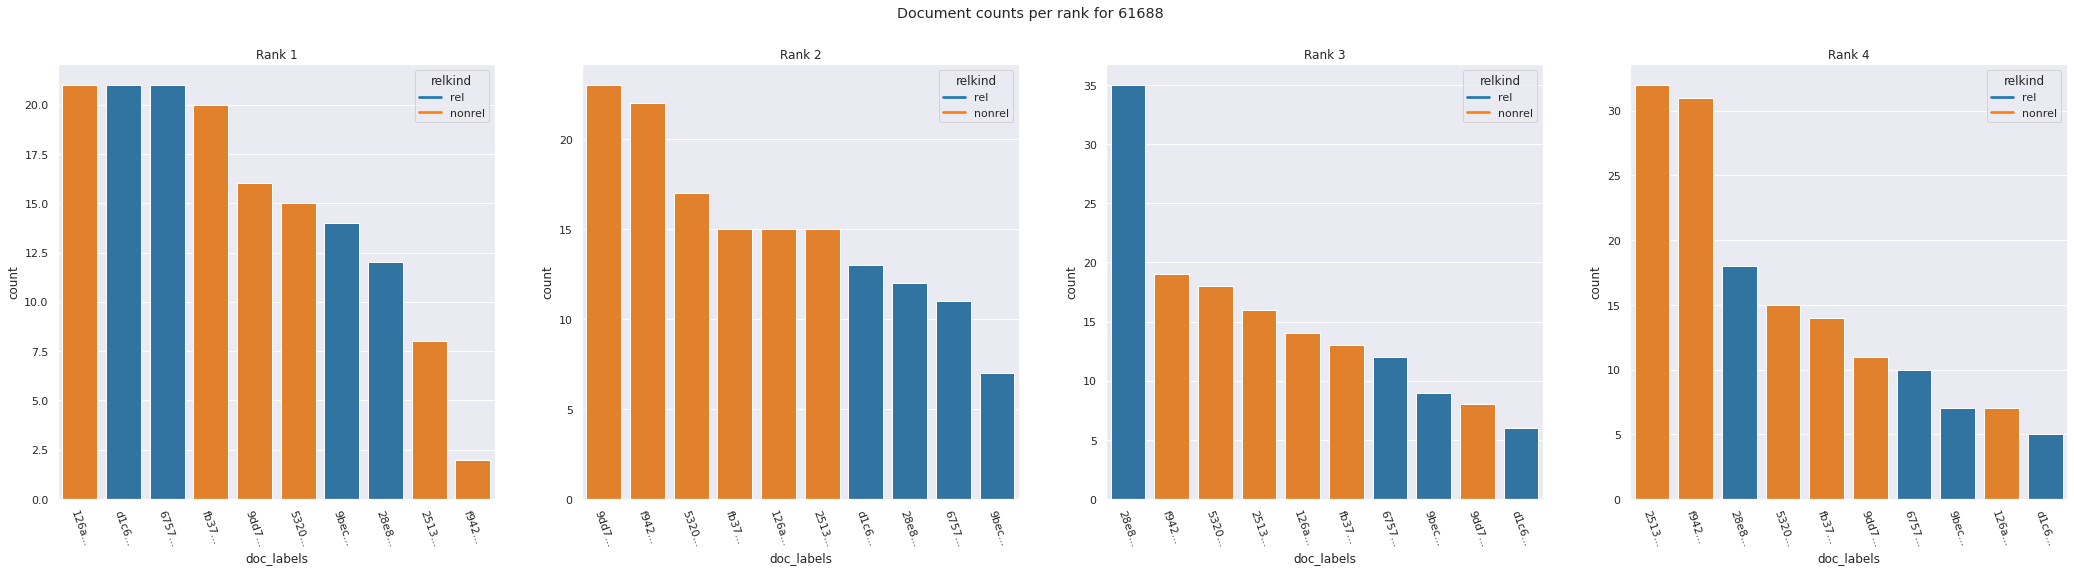

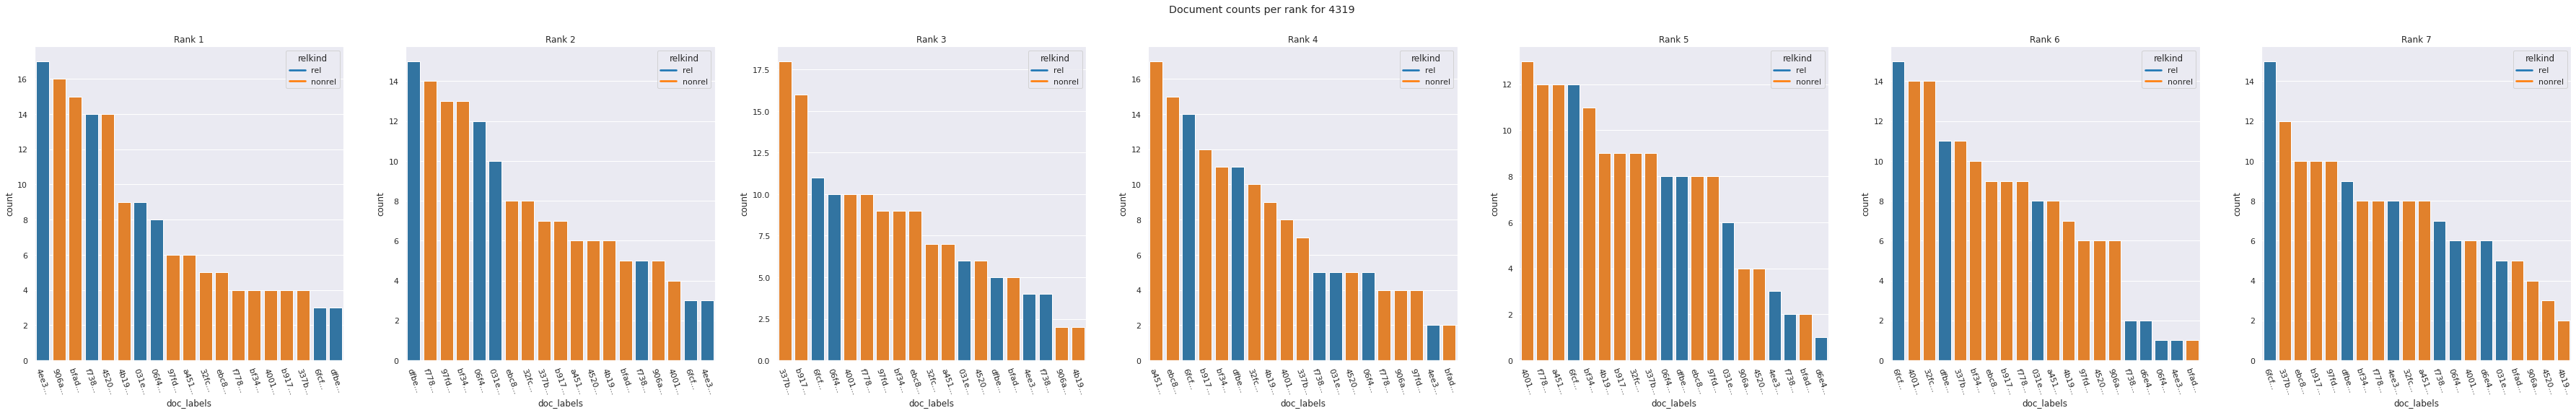

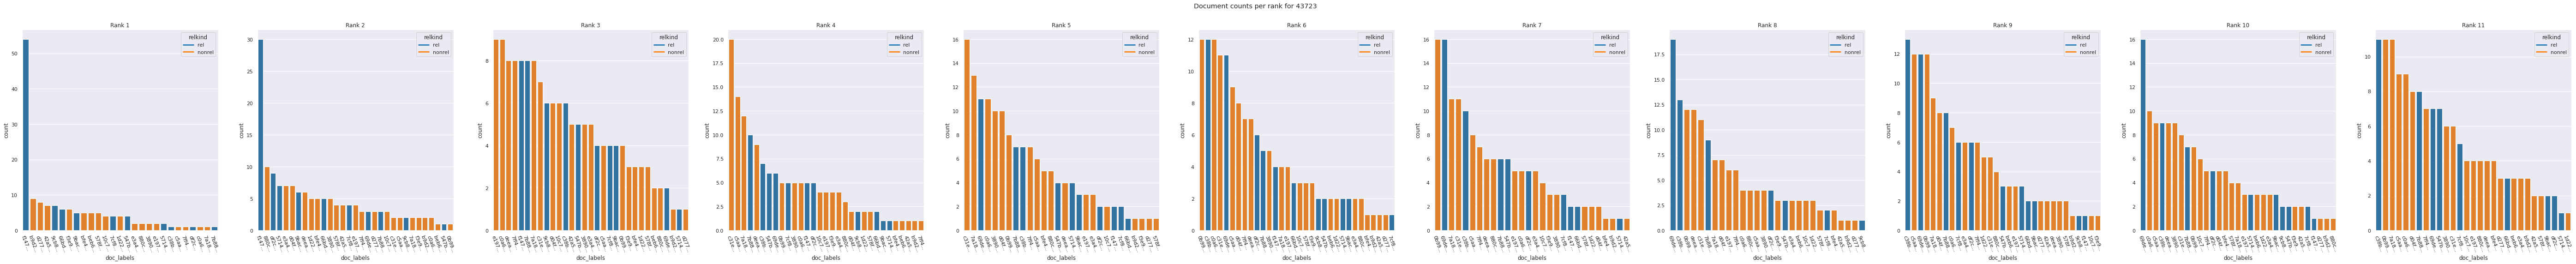

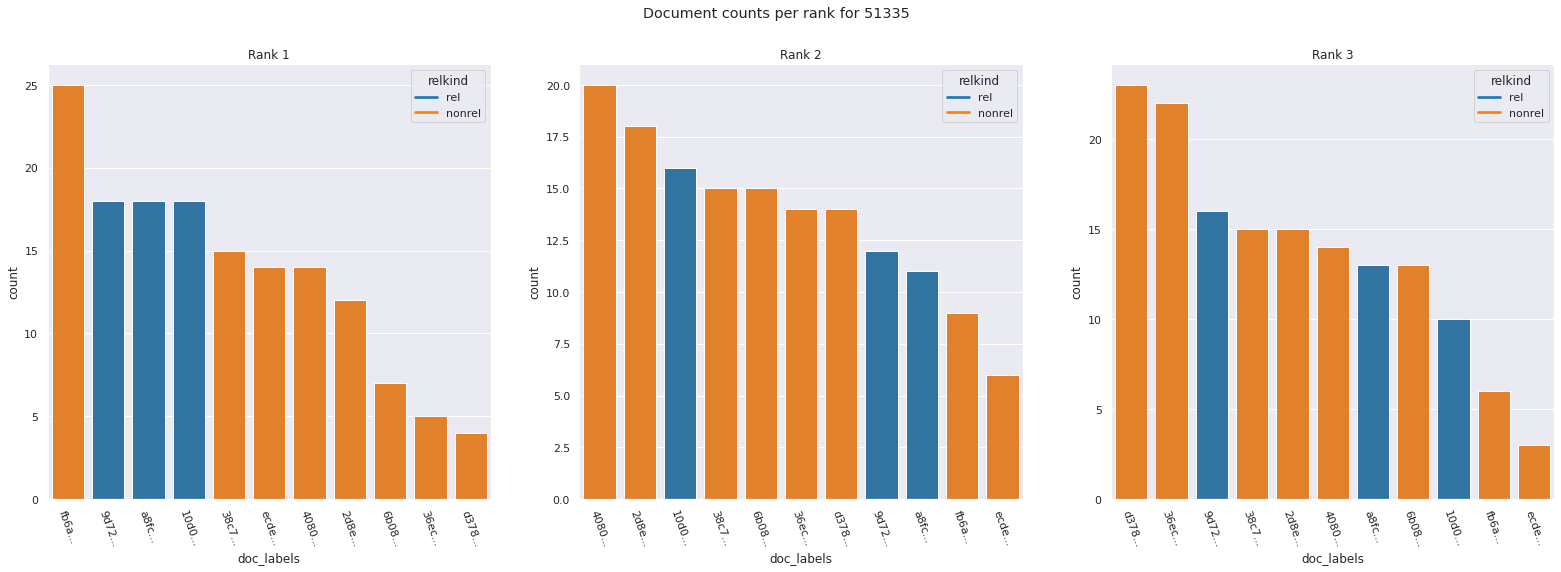

In [49]:
for q in topqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)


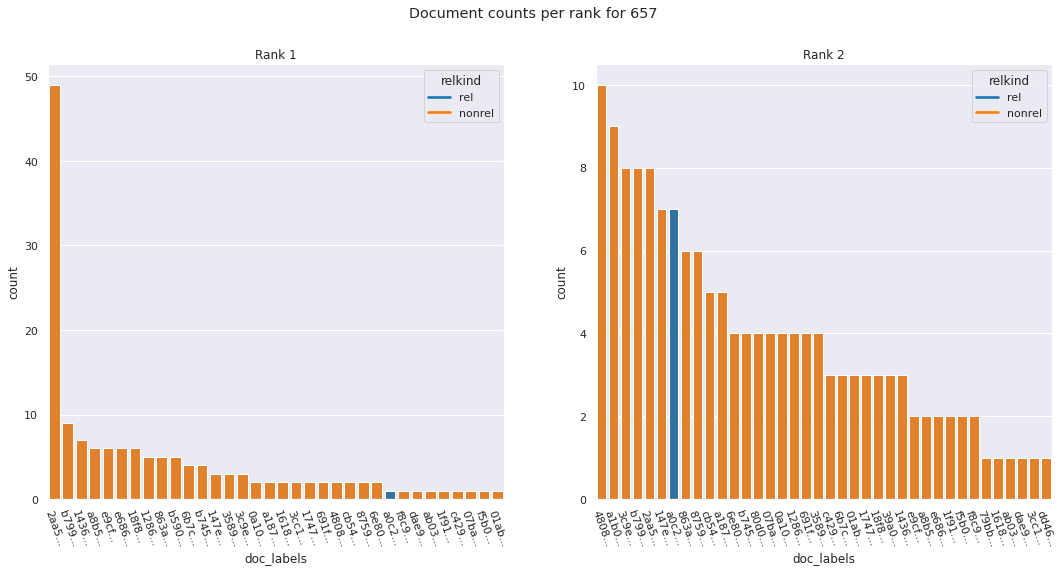

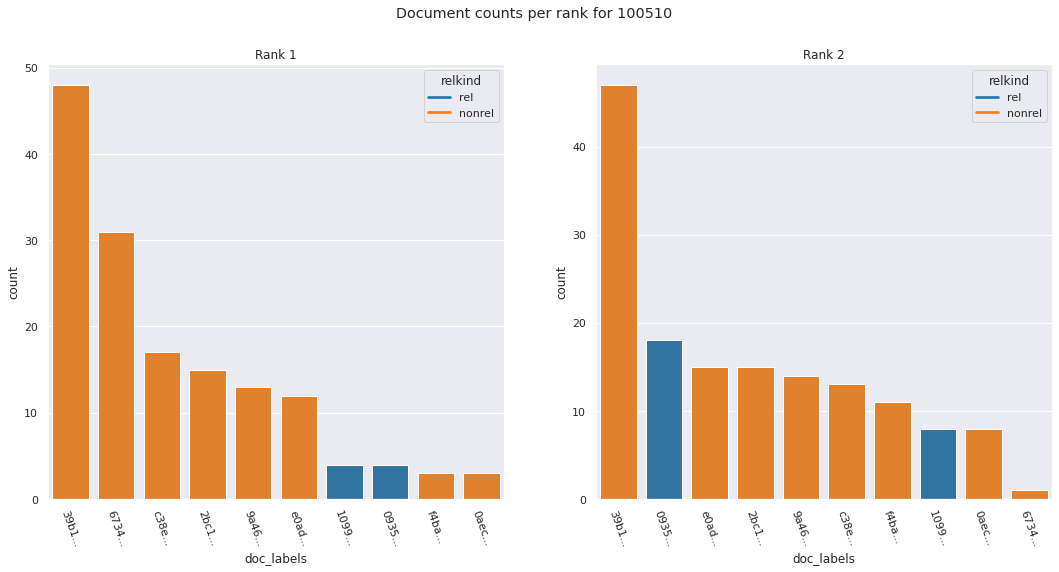

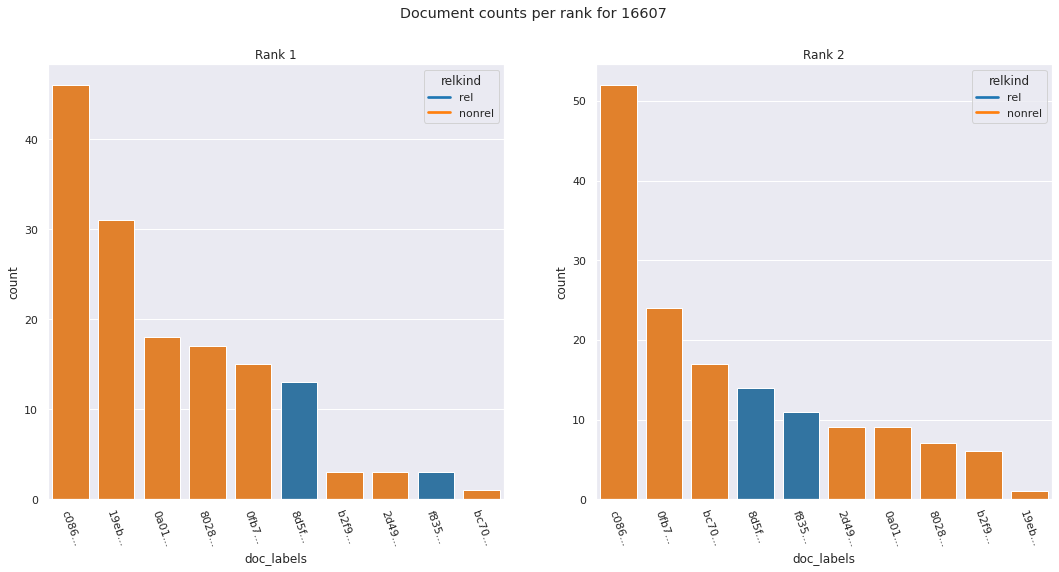

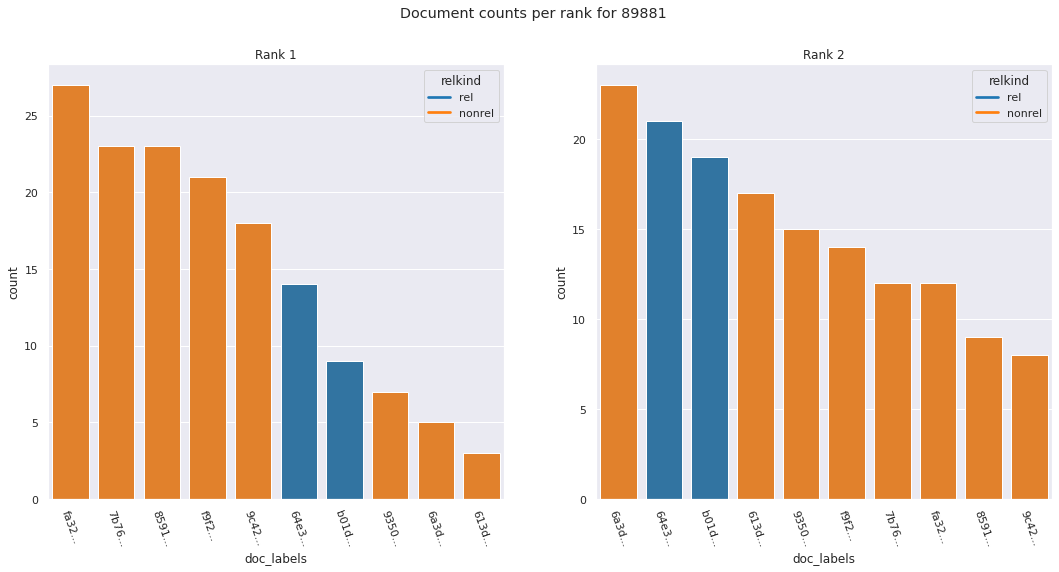

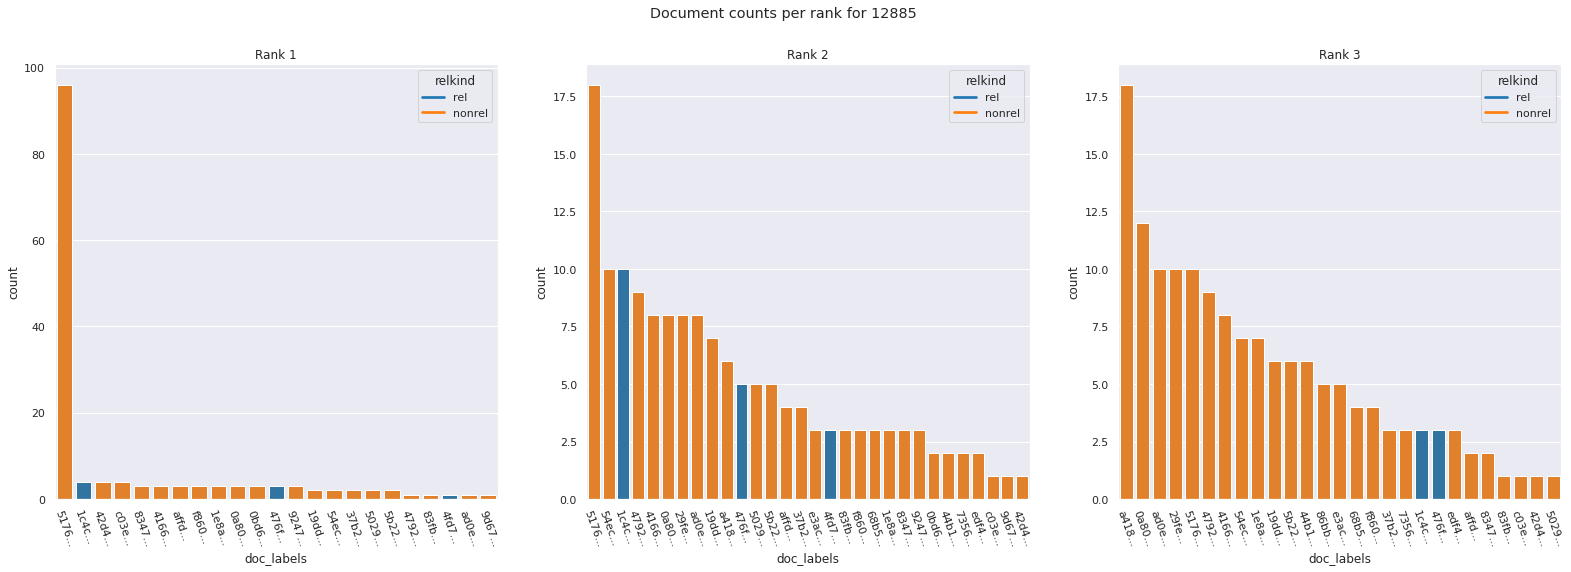

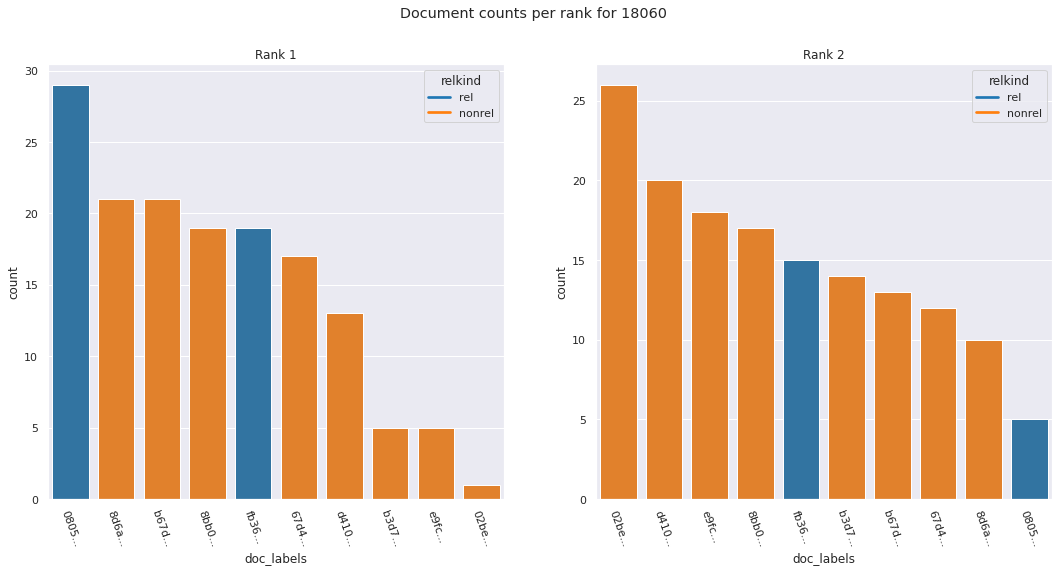

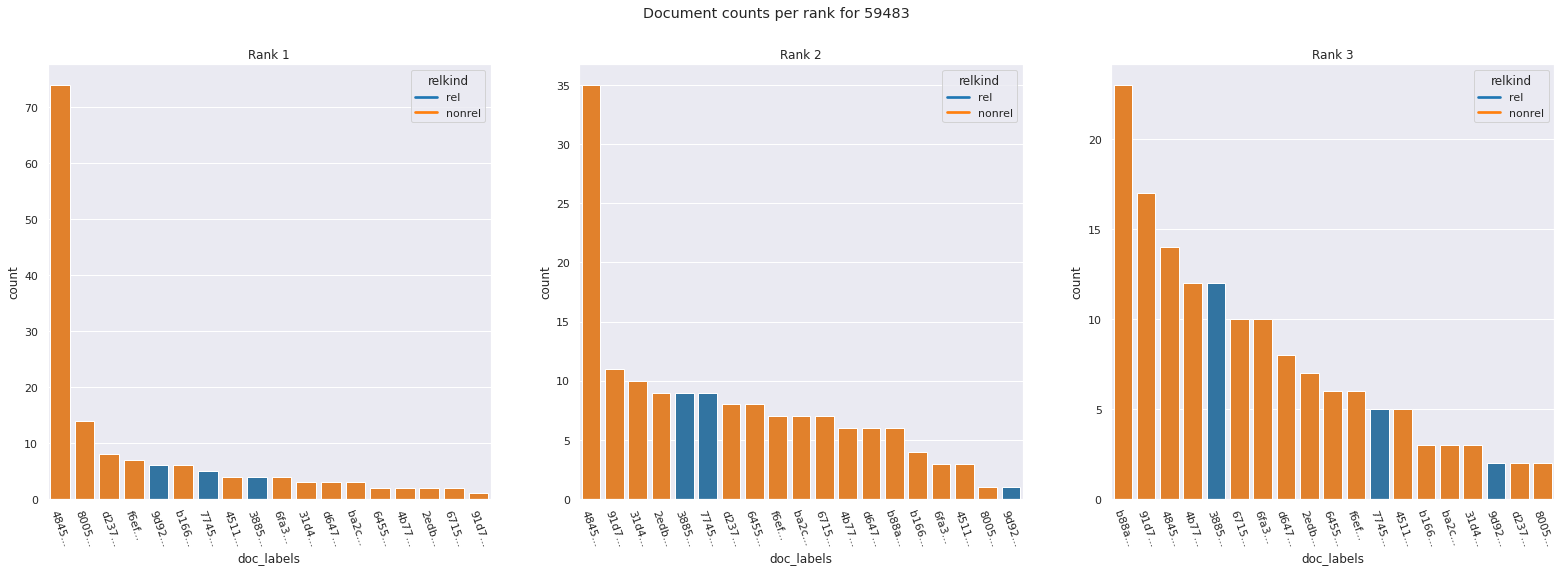

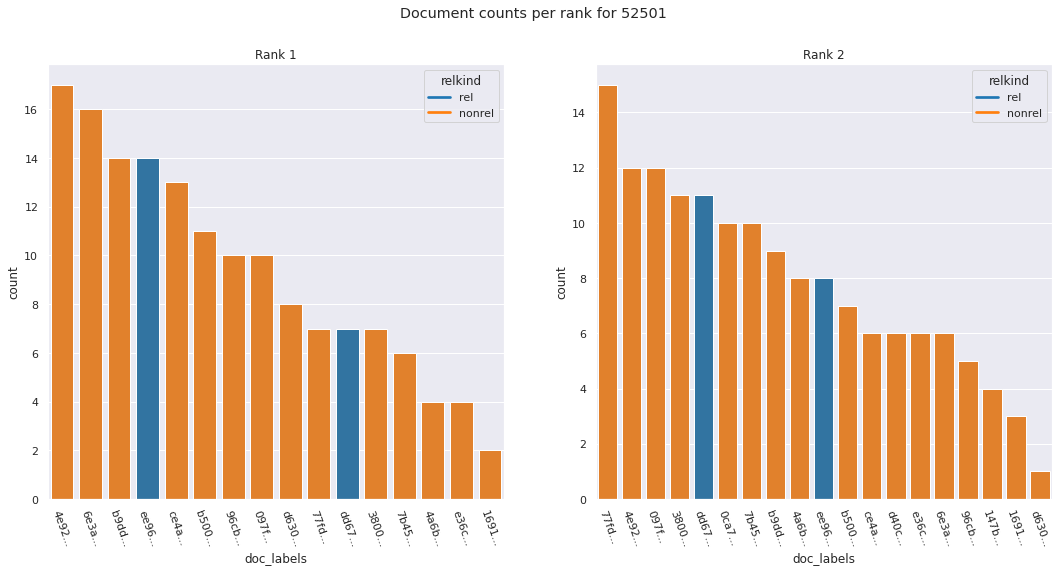

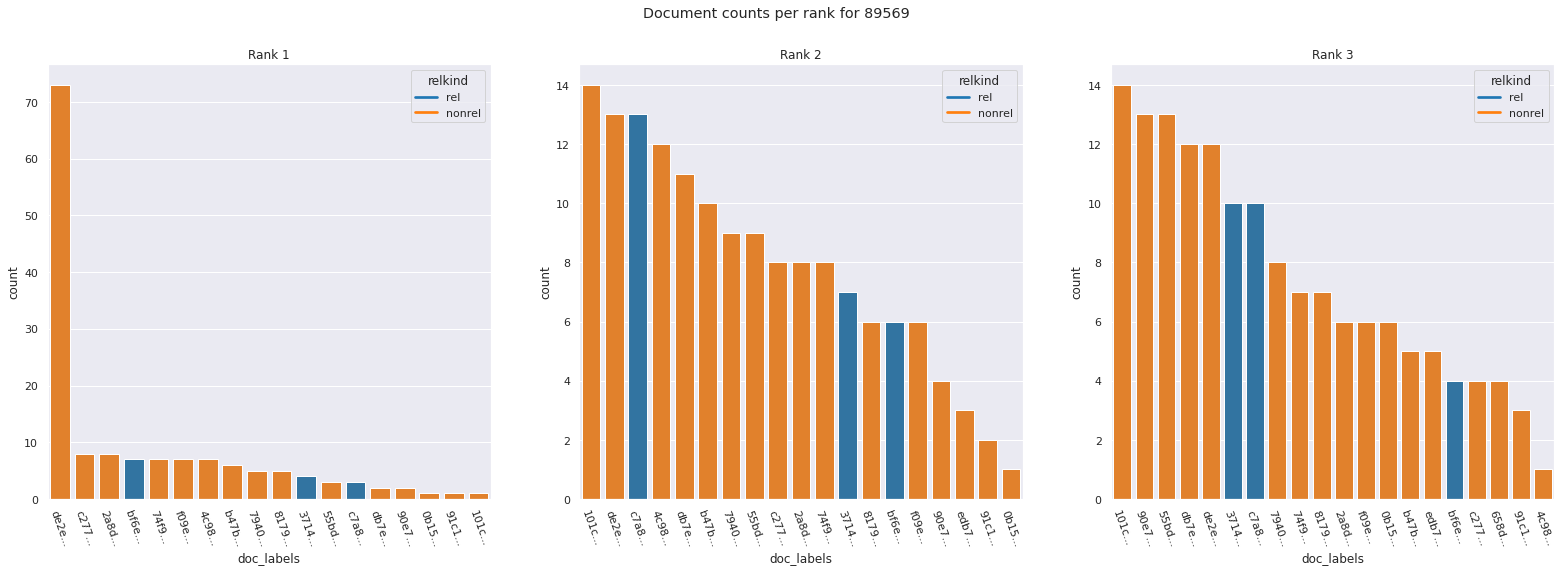

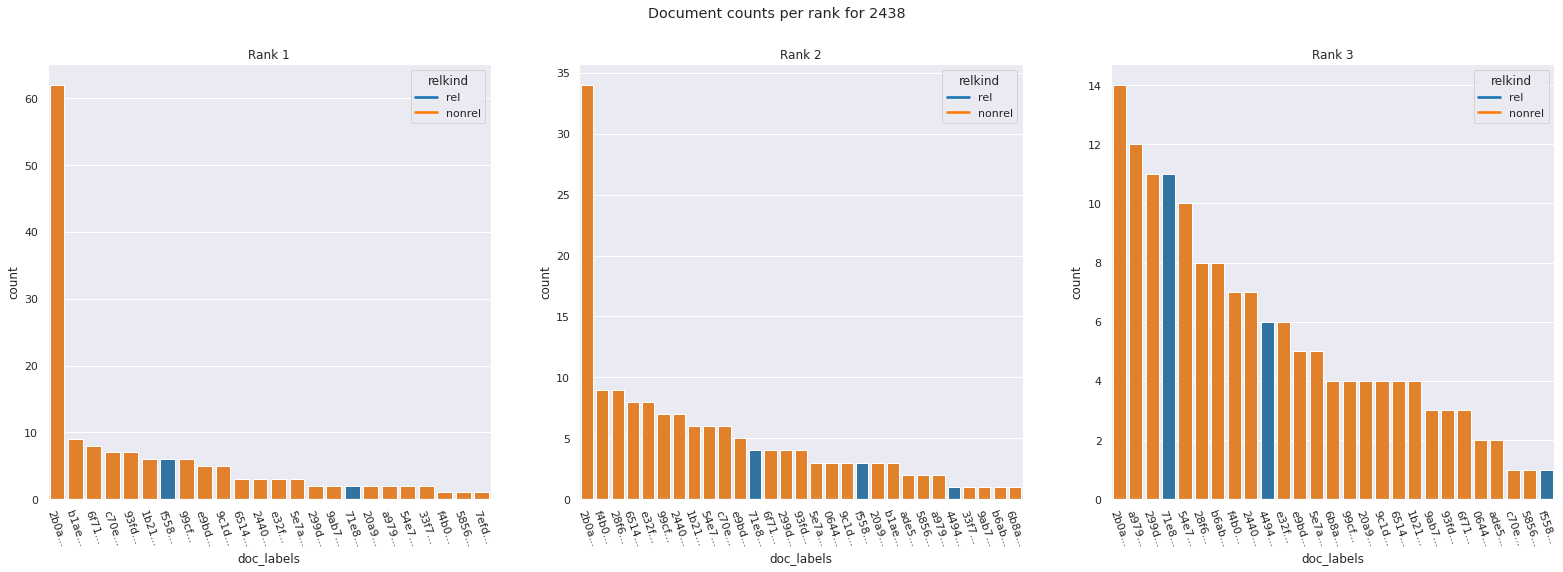

In [50]:
for q in bottomqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=rel)
    

##### Top positions

Remarks:
- The top queries have a larger number of relevant items than the bottom queries on average
  - **Hypothesis**: if a query has a larger *fraction* of relevant items it performs better, because the chance that a a relevant item lands in a top position is larger.
  
- The top queries in general have a gently diminishing distribution over the number of times documents occur in a rank, with some exceptions.


    - The top performing query, qid=91643, has a single irrelevant document spike in the first position.
        - The negative contribution of this document is offset by the fact that the rest of the top positions are reasonably often filled with relevant items?

    - 21237, 43723 have a large spiked document, but it is relevant so therefore doesn't negatively influence the DGEE?
        - Is this also an authorless document?


- For the top queries, the relevant documents all at least appear in the top positions.
     - Exception: 4319, 18118 sometimes one of the relevant docs is missing. Which one is this and why is it missing?

- Many of the bottom queries have a large spike of an irrelevant document in a top position.
    - Aside from the spike the distribution generally diminishes gently.
- Some of the bottom queries are missing a relevant document in the top position:
    - 657, 12885


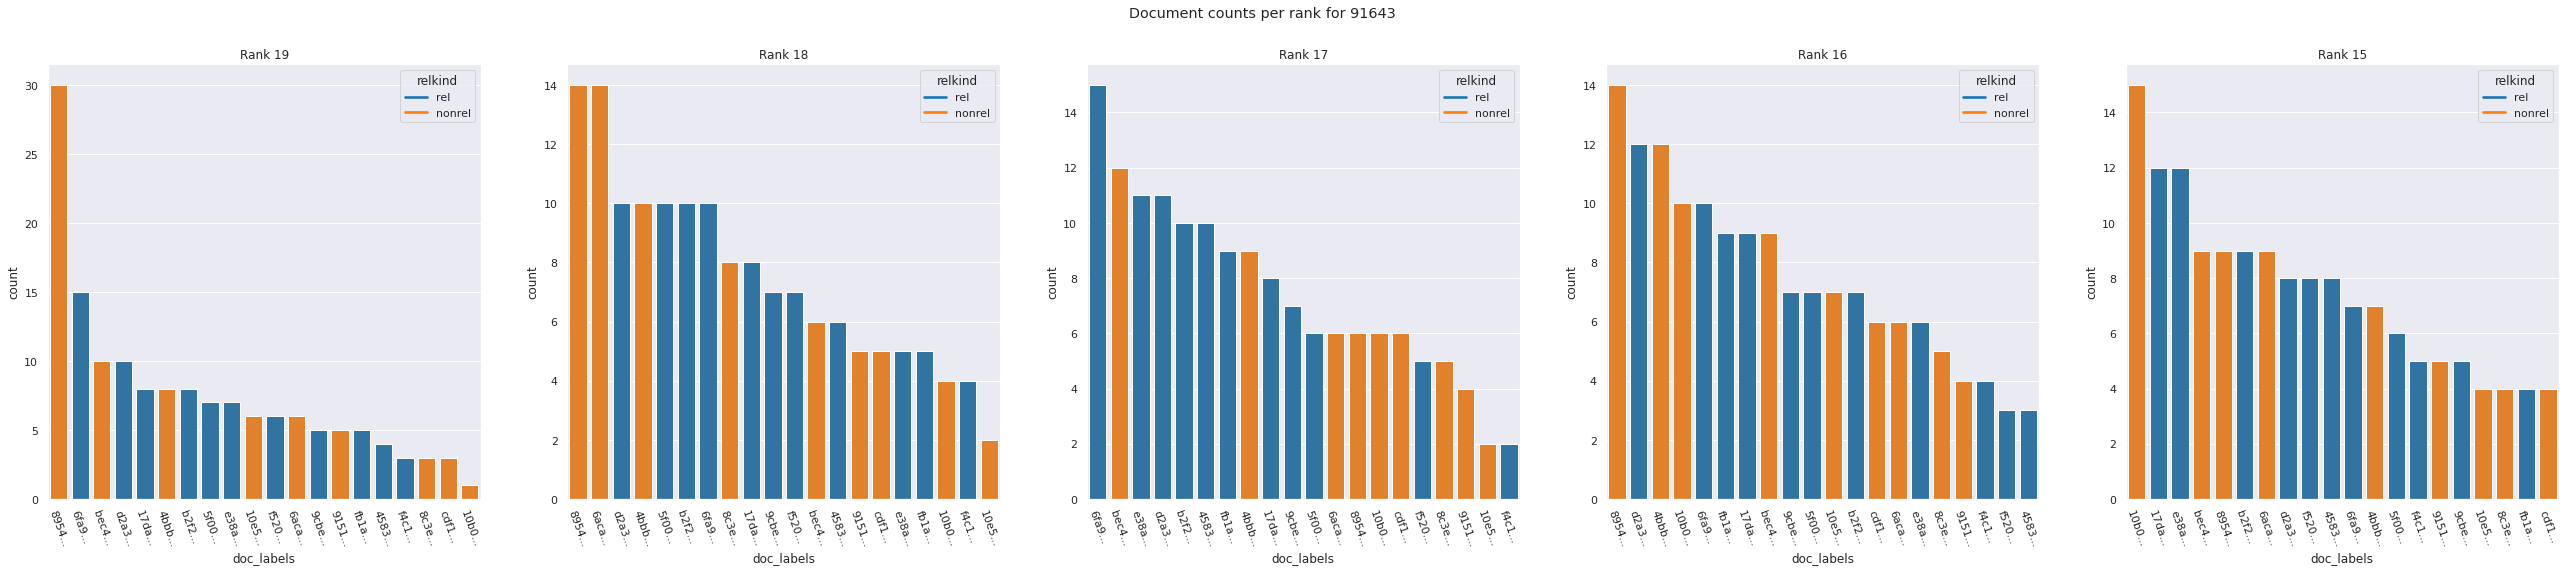

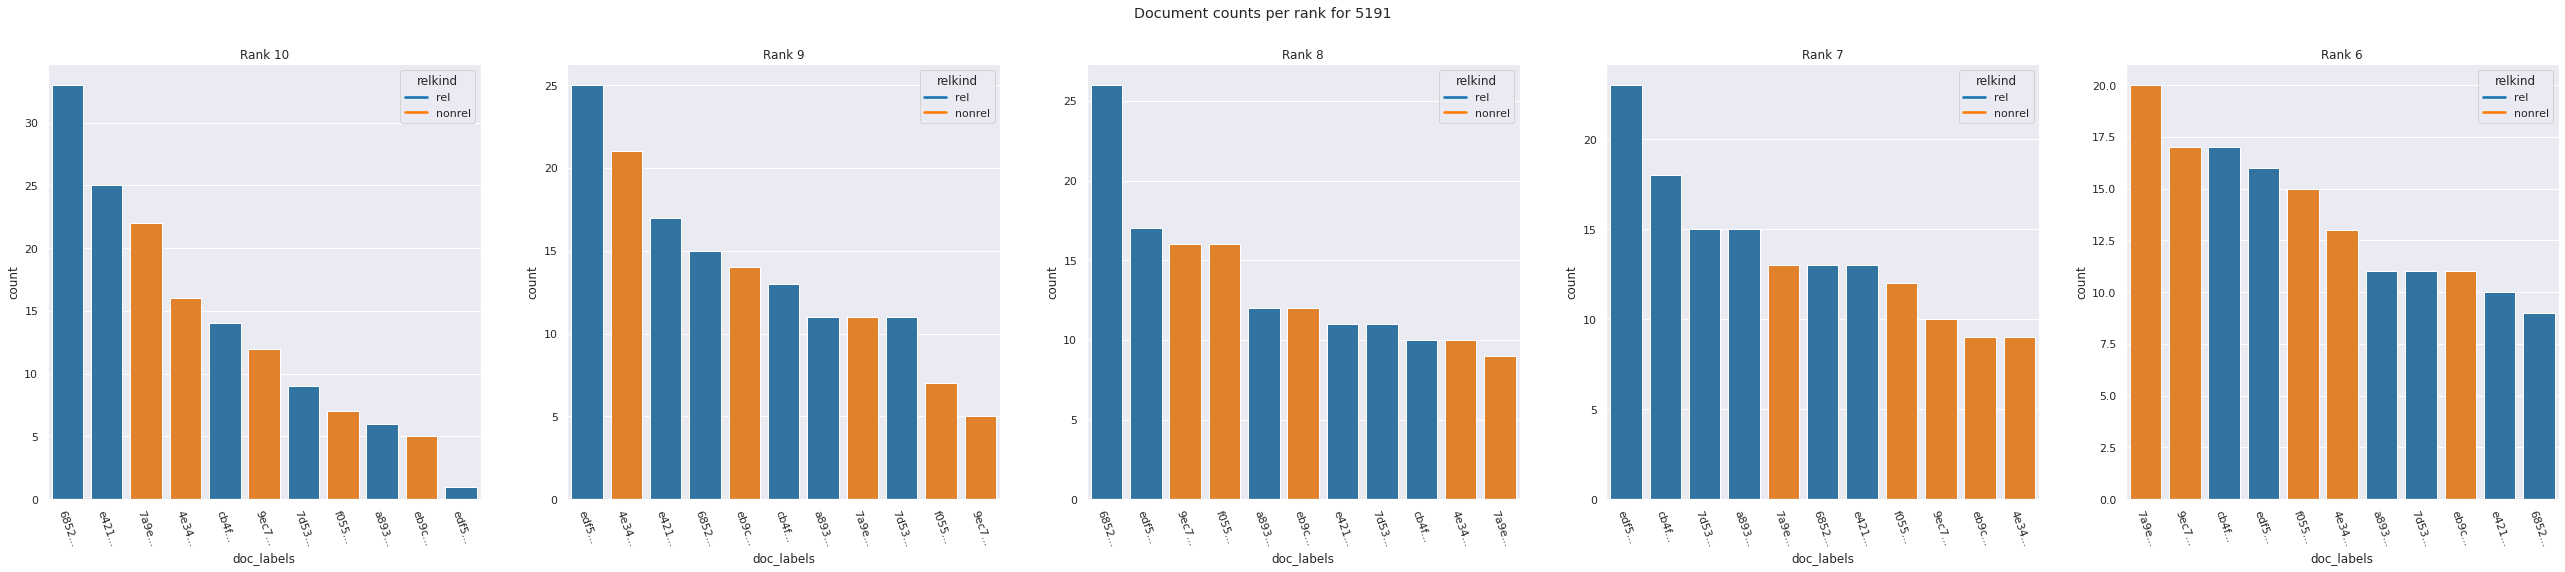

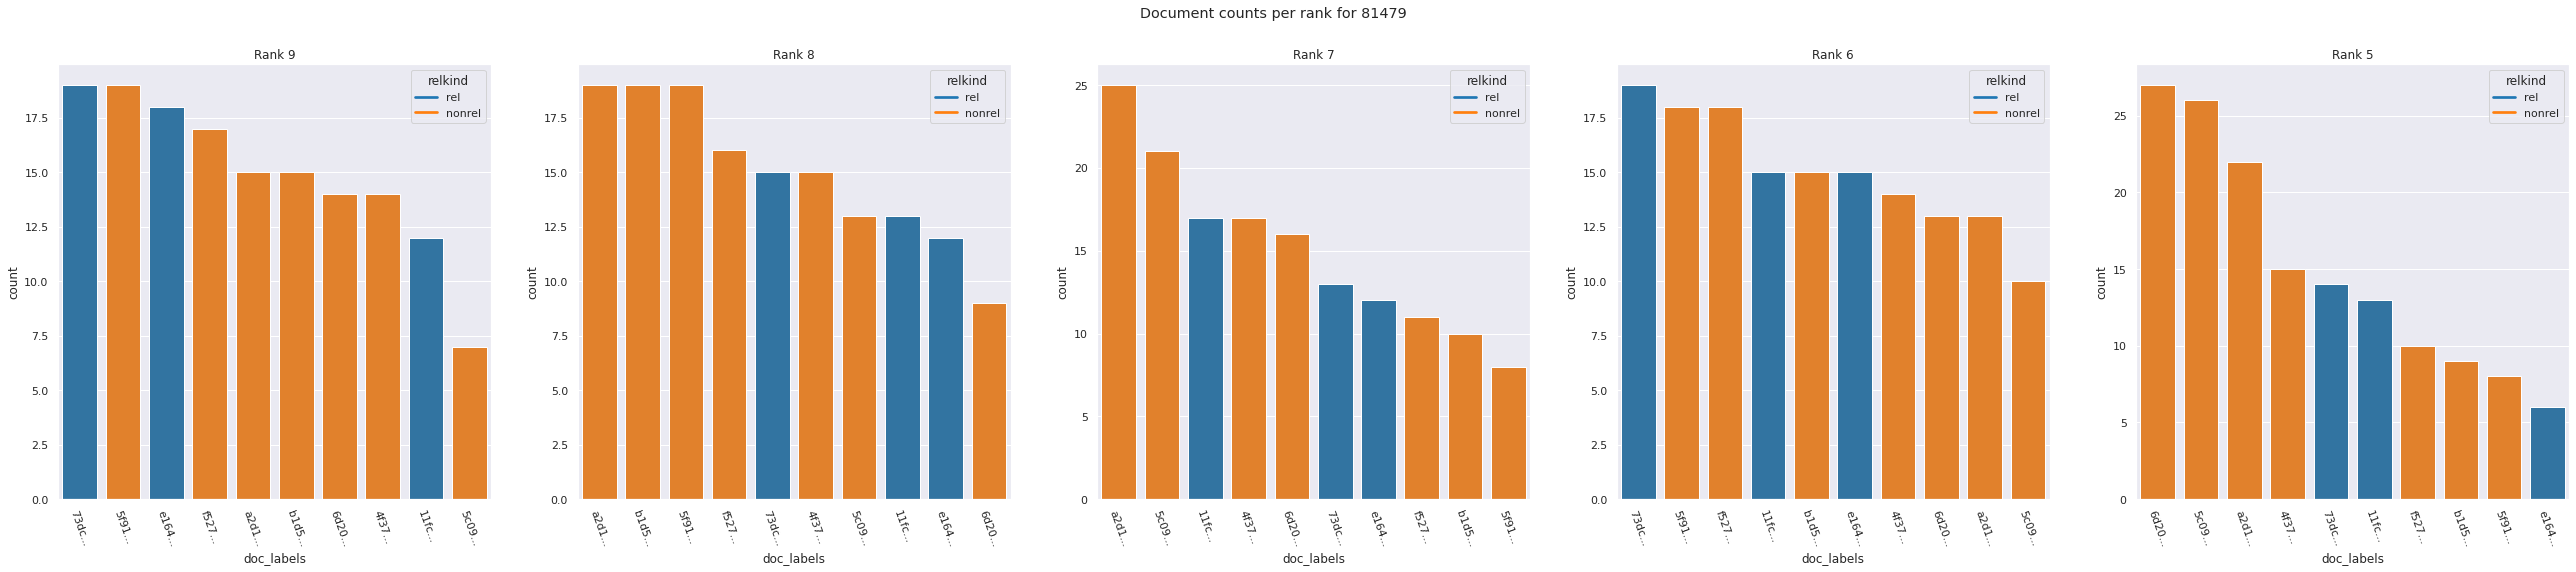

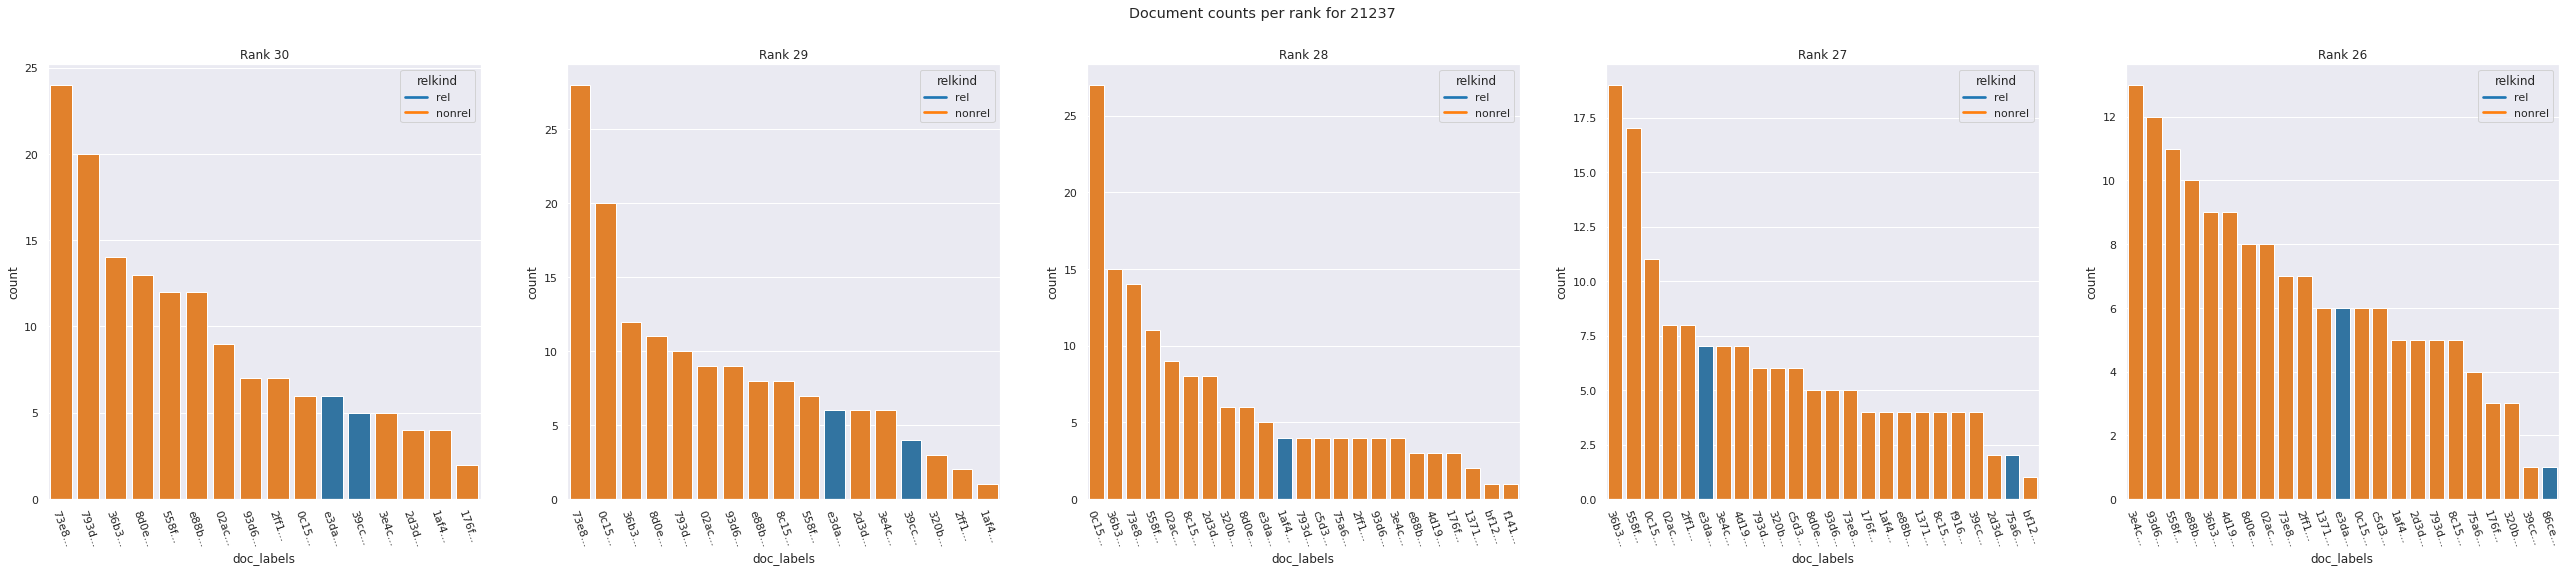

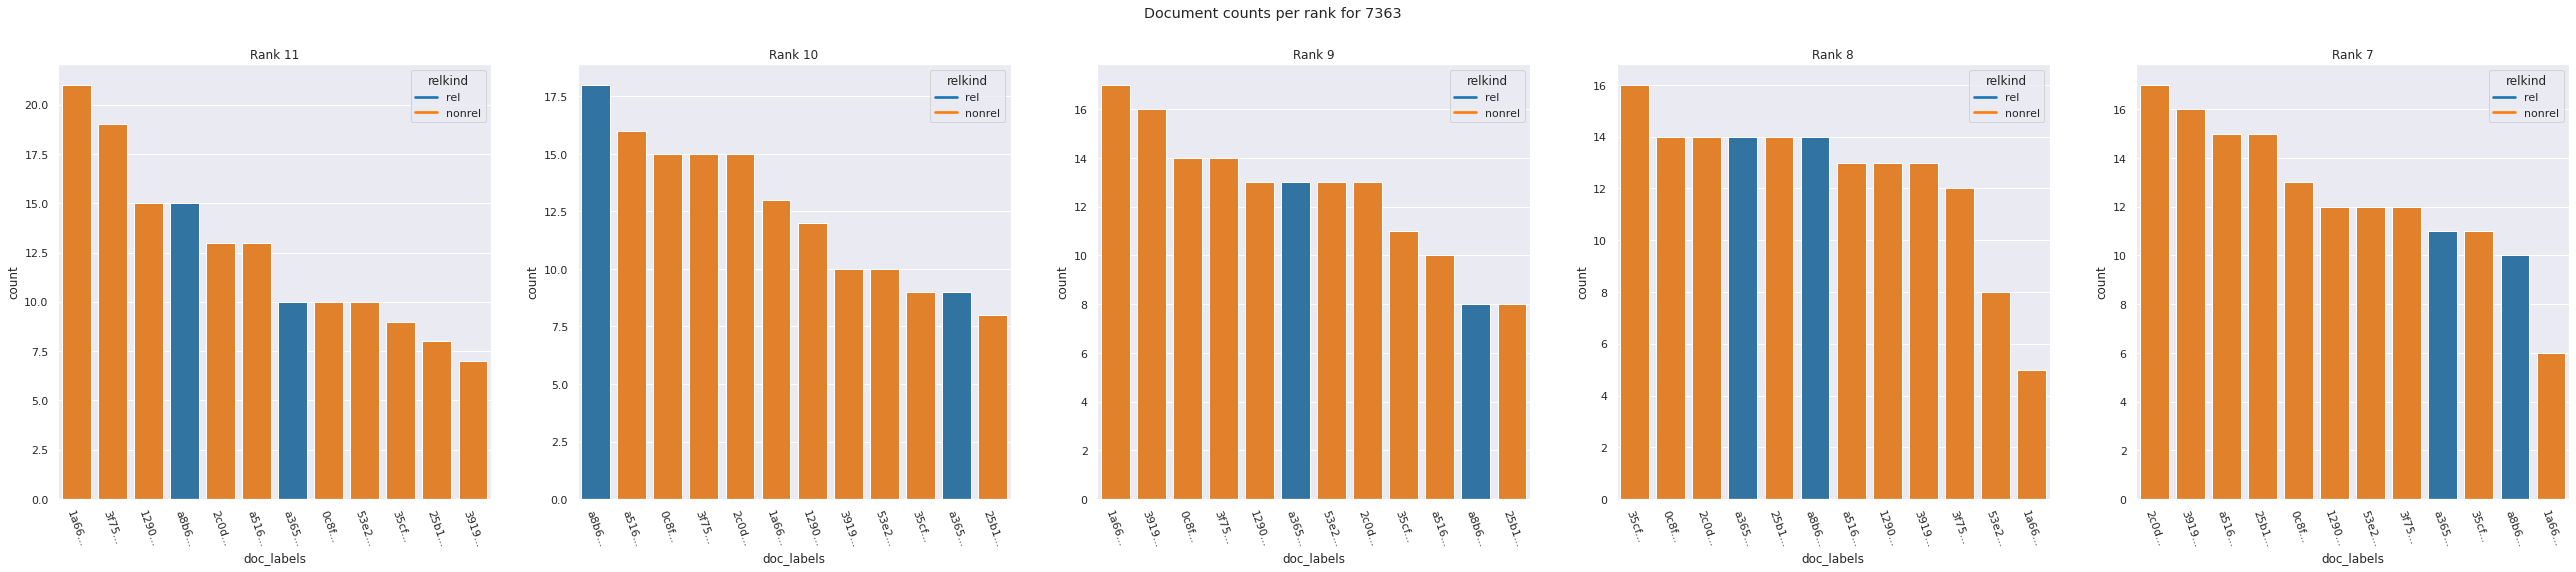

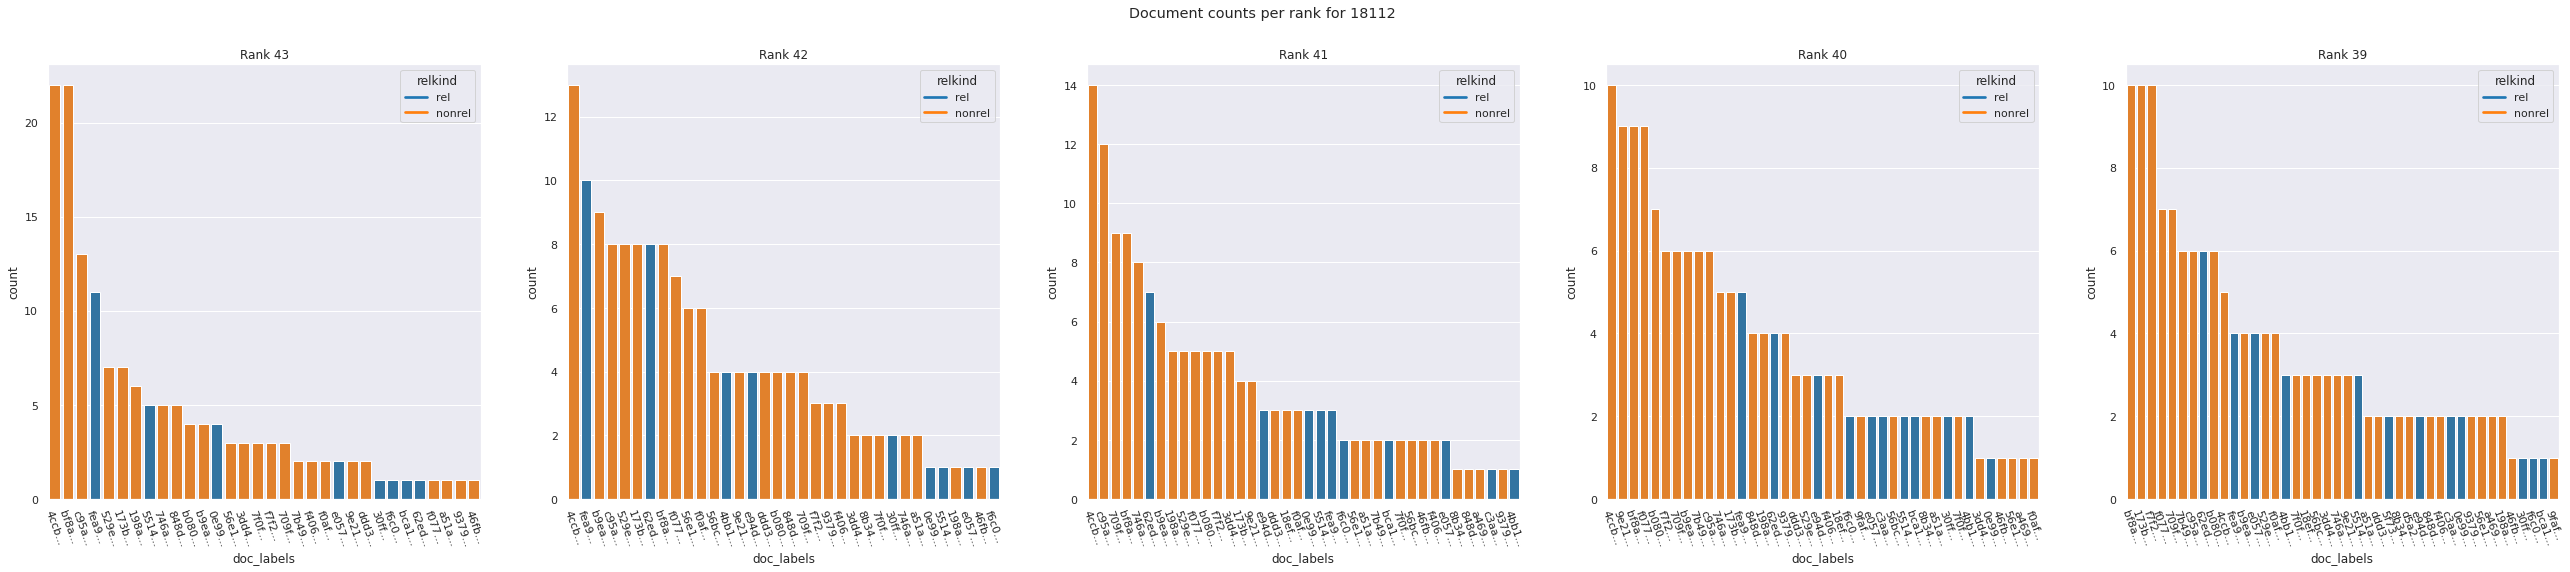

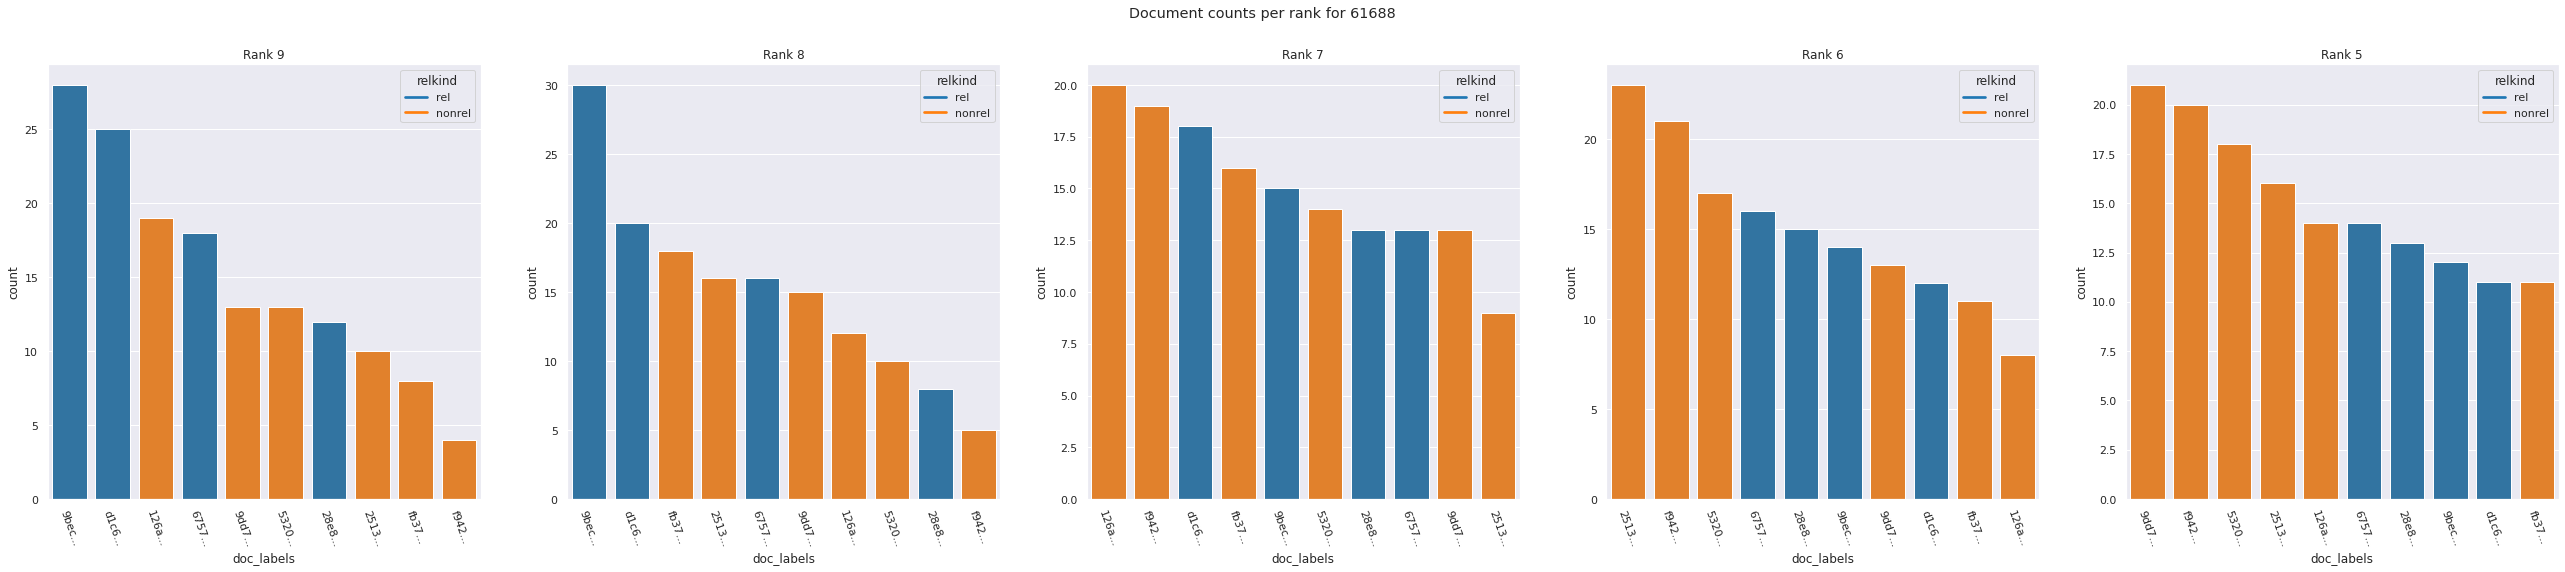

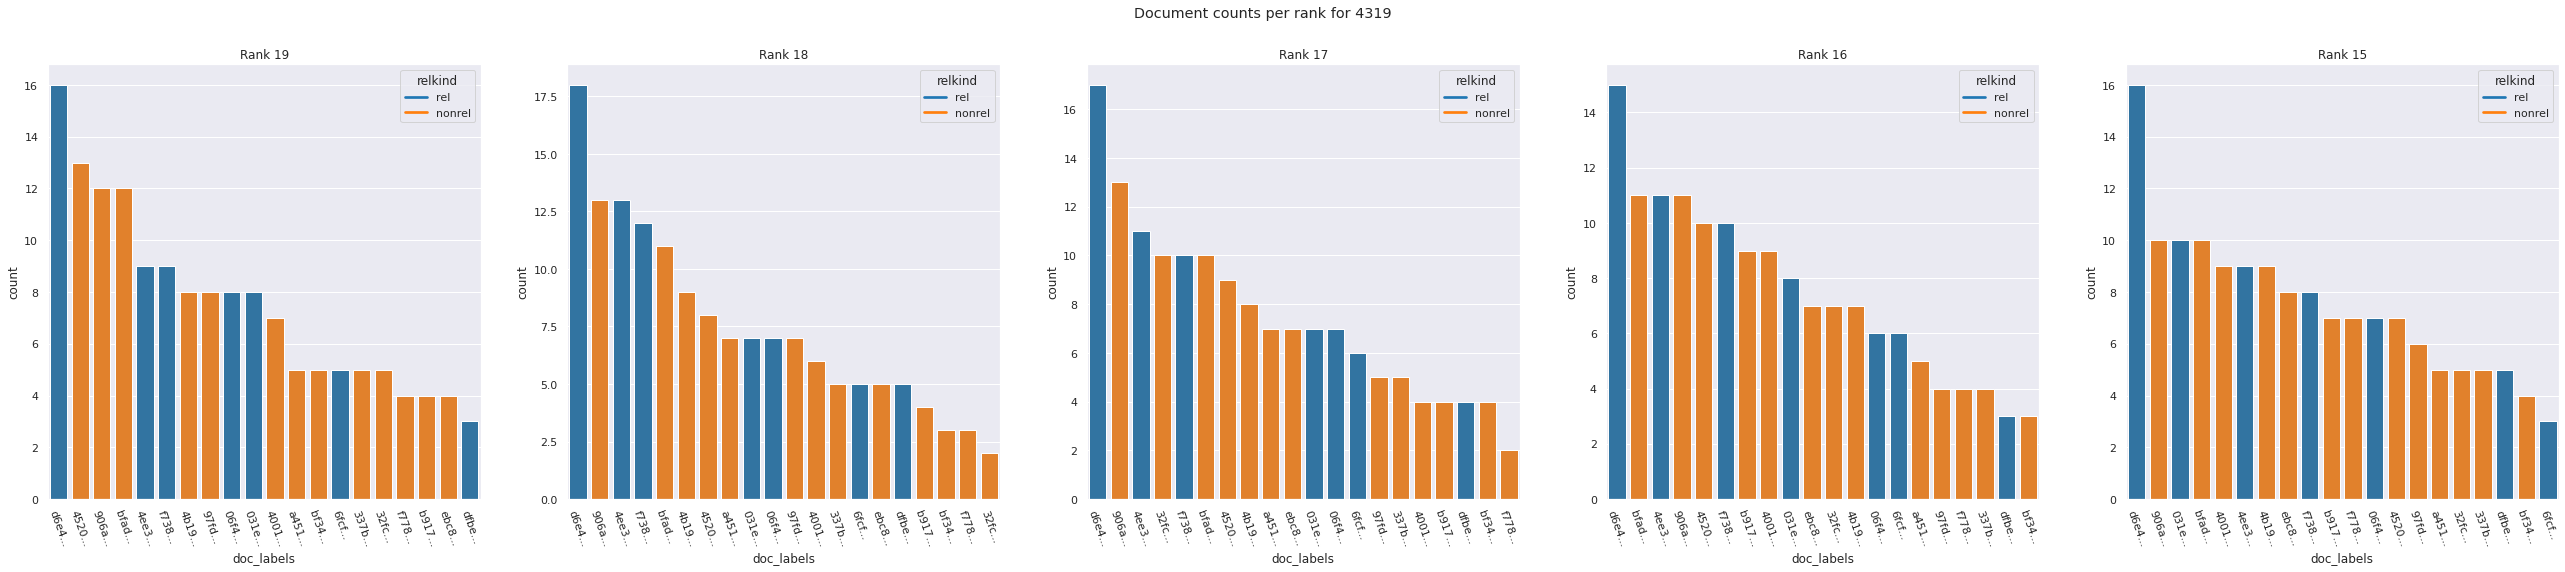

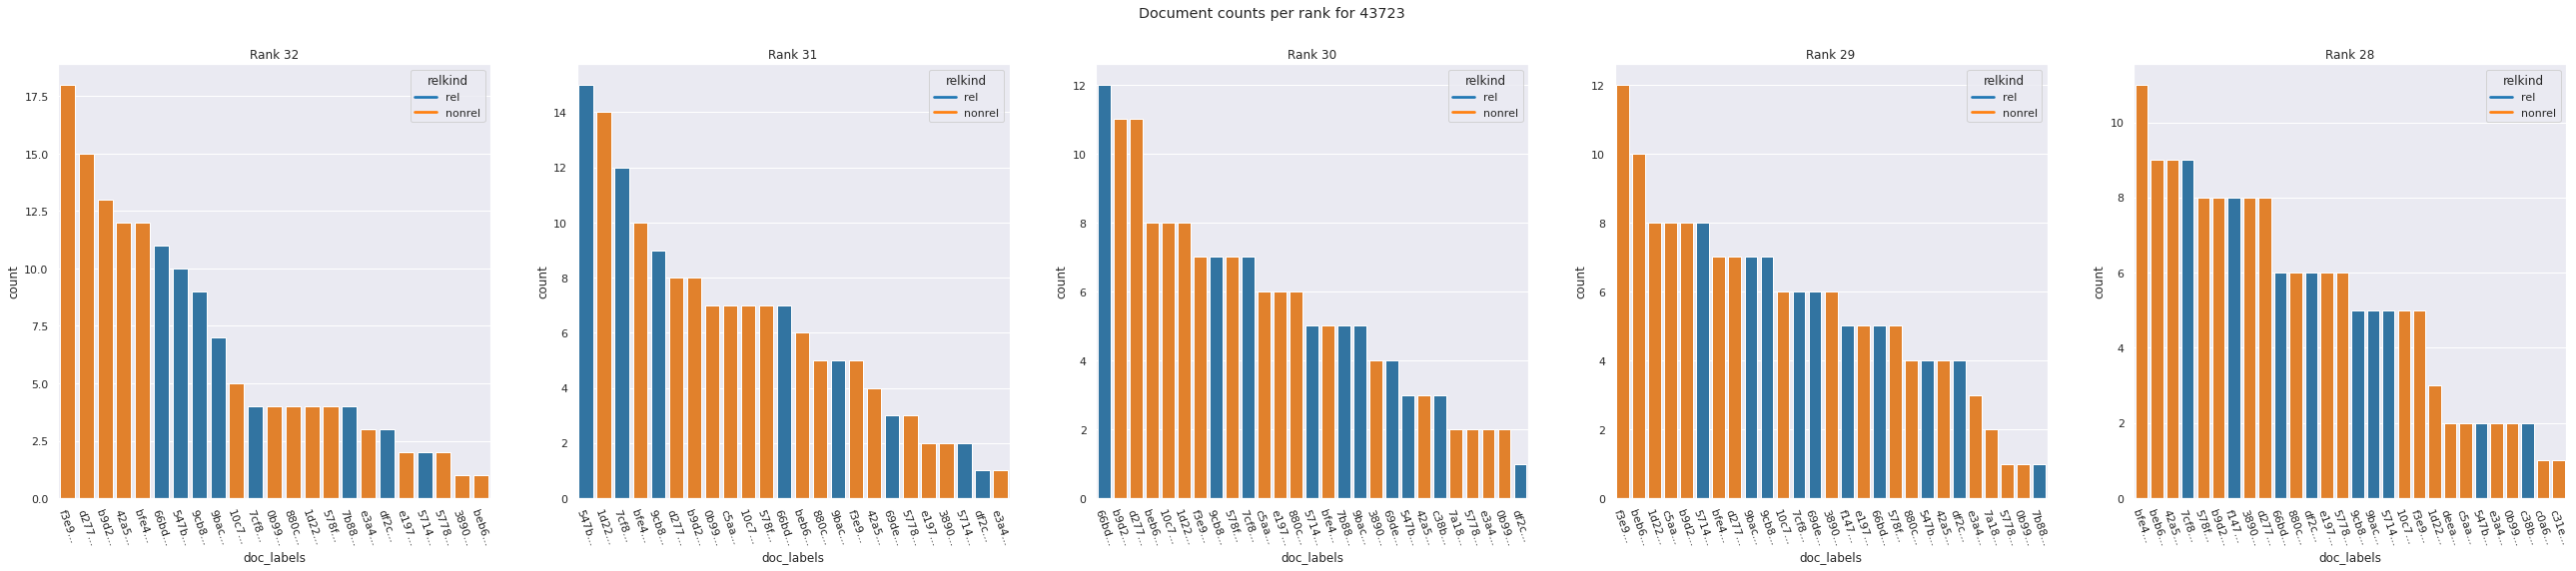

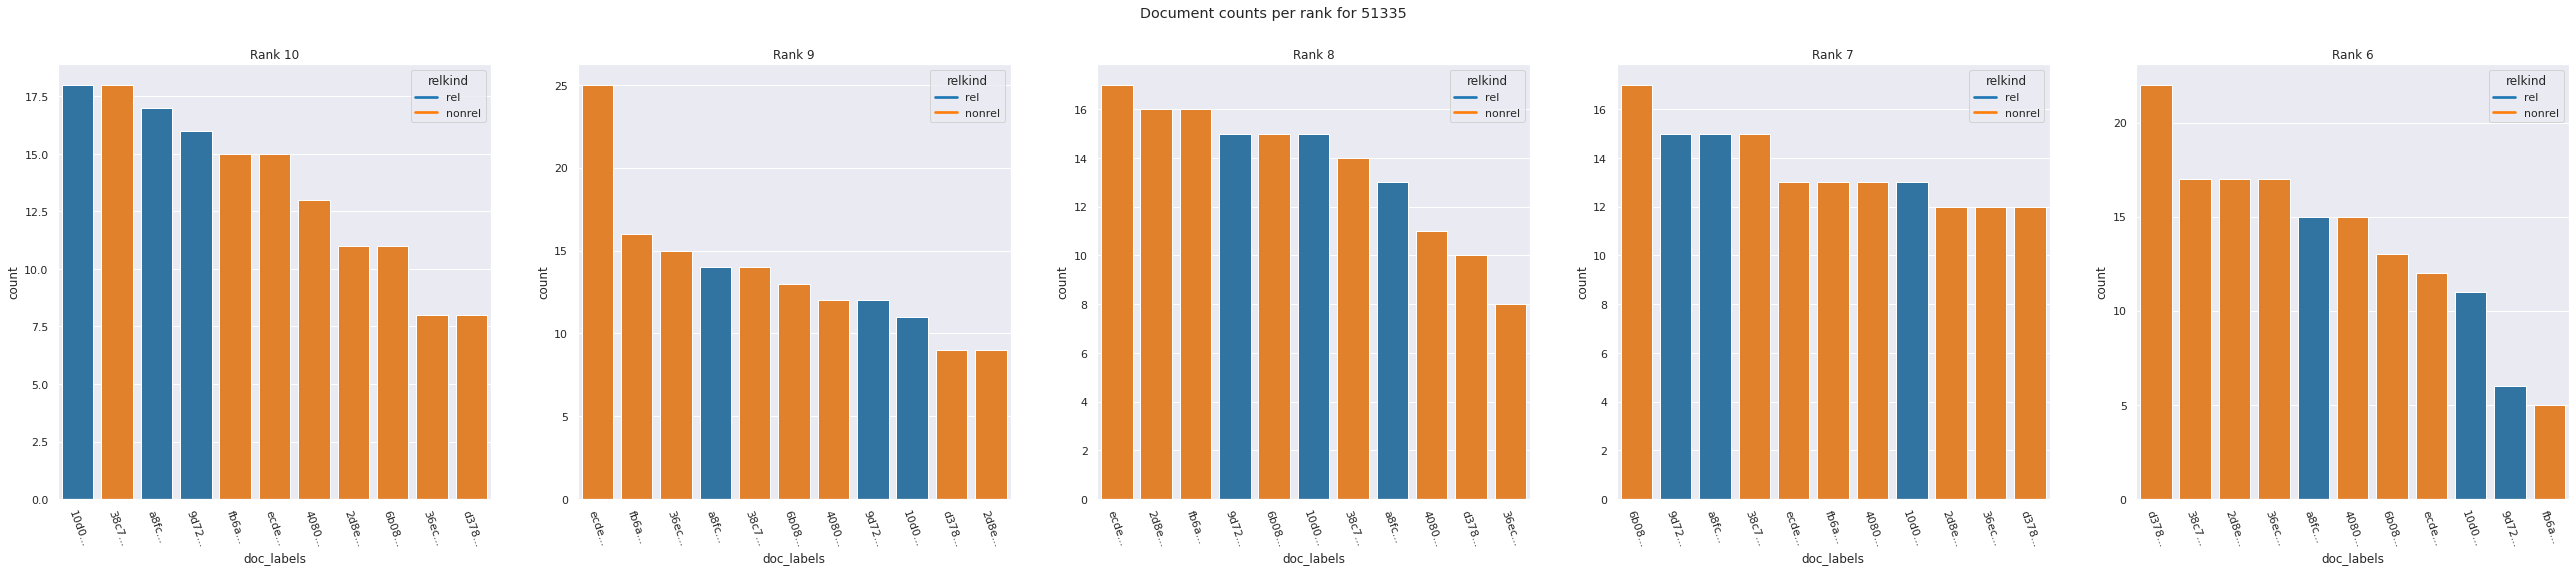

In [51]:
for q in topqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=5,rev=True)

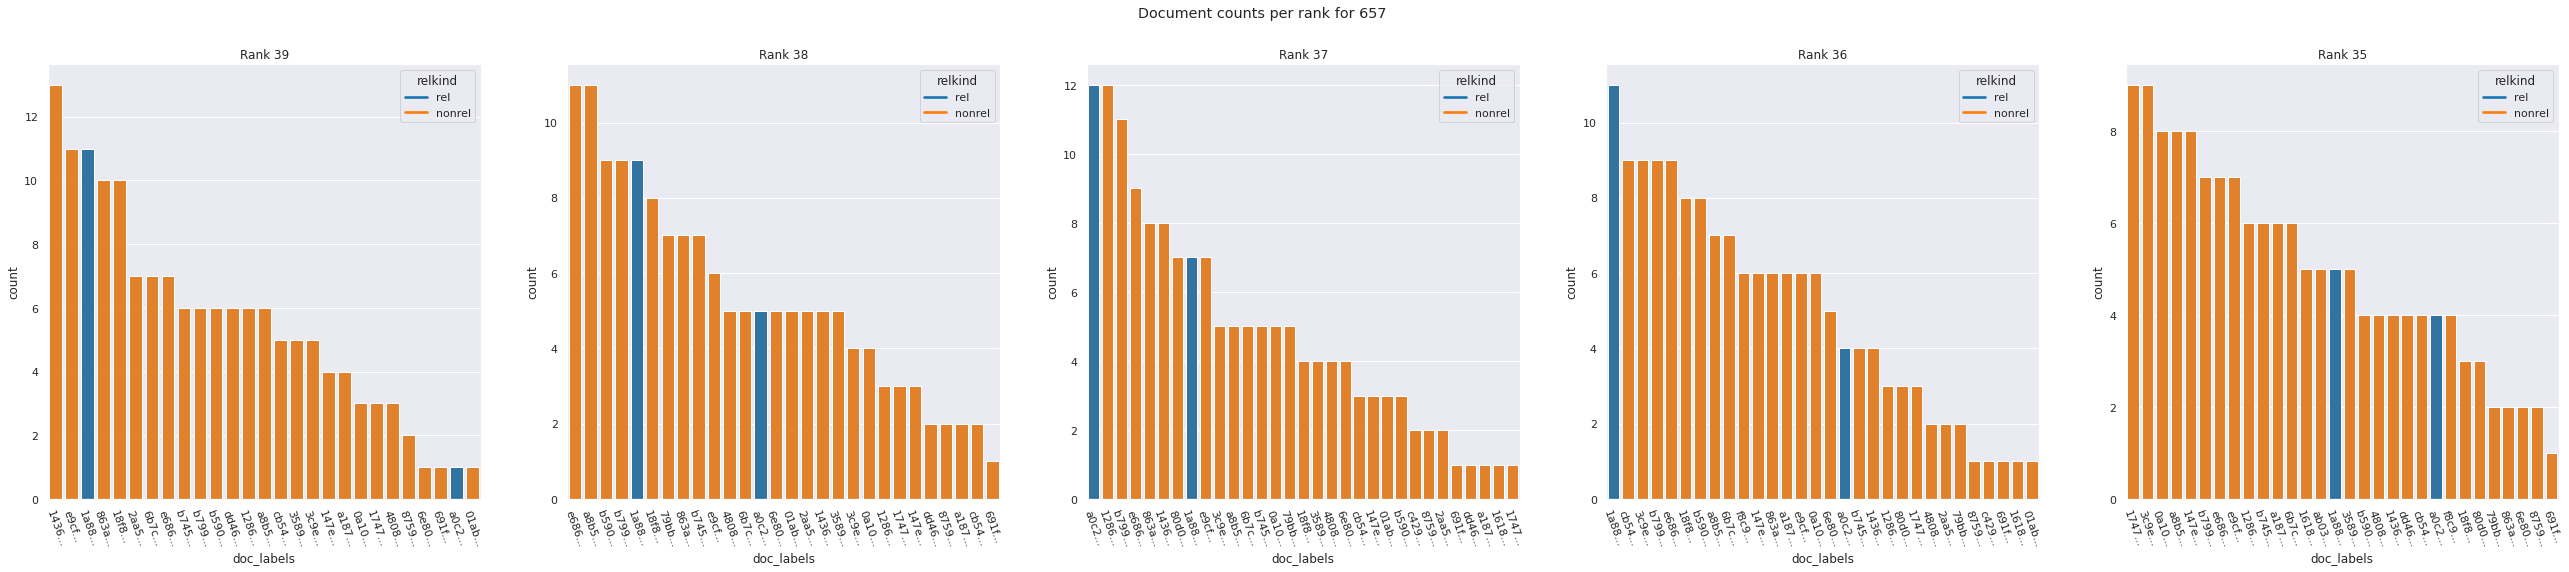

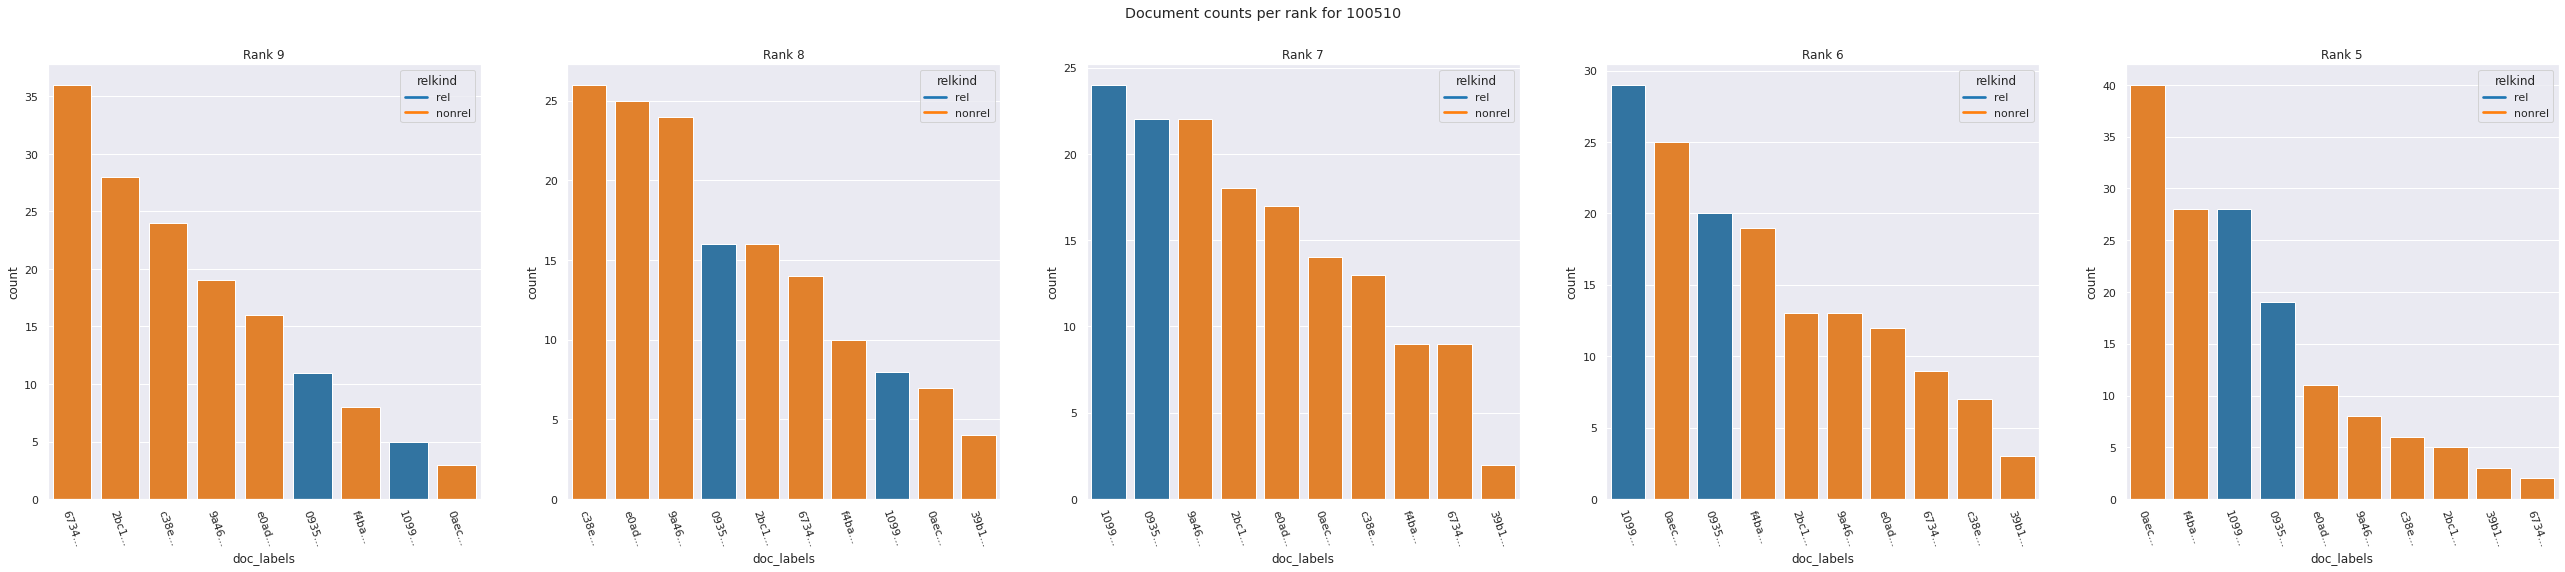

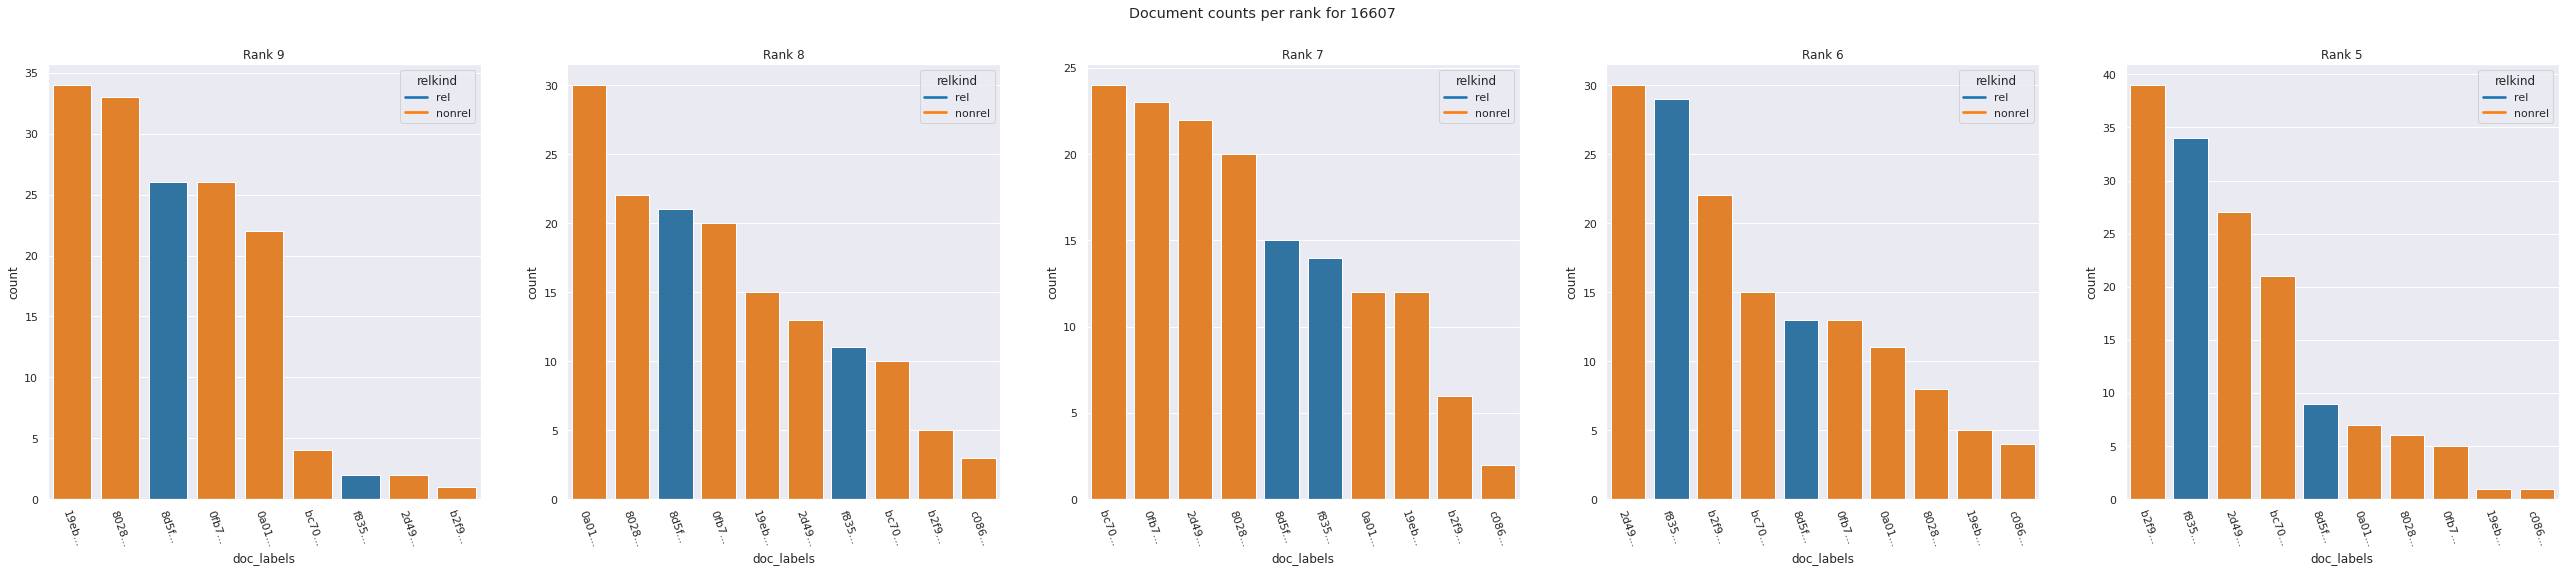

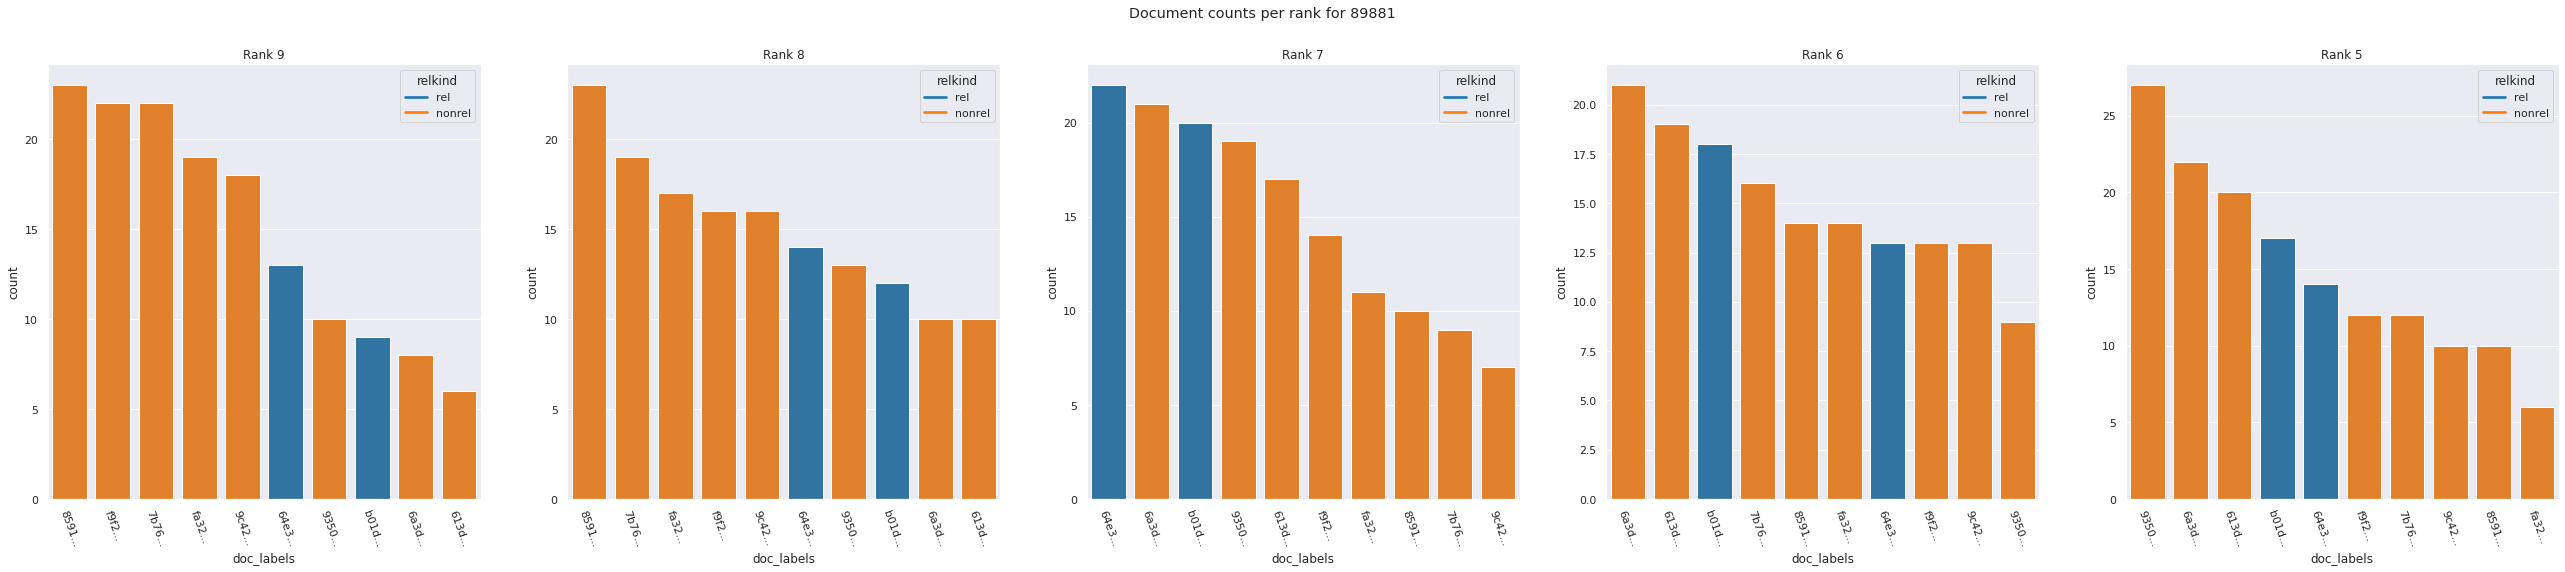

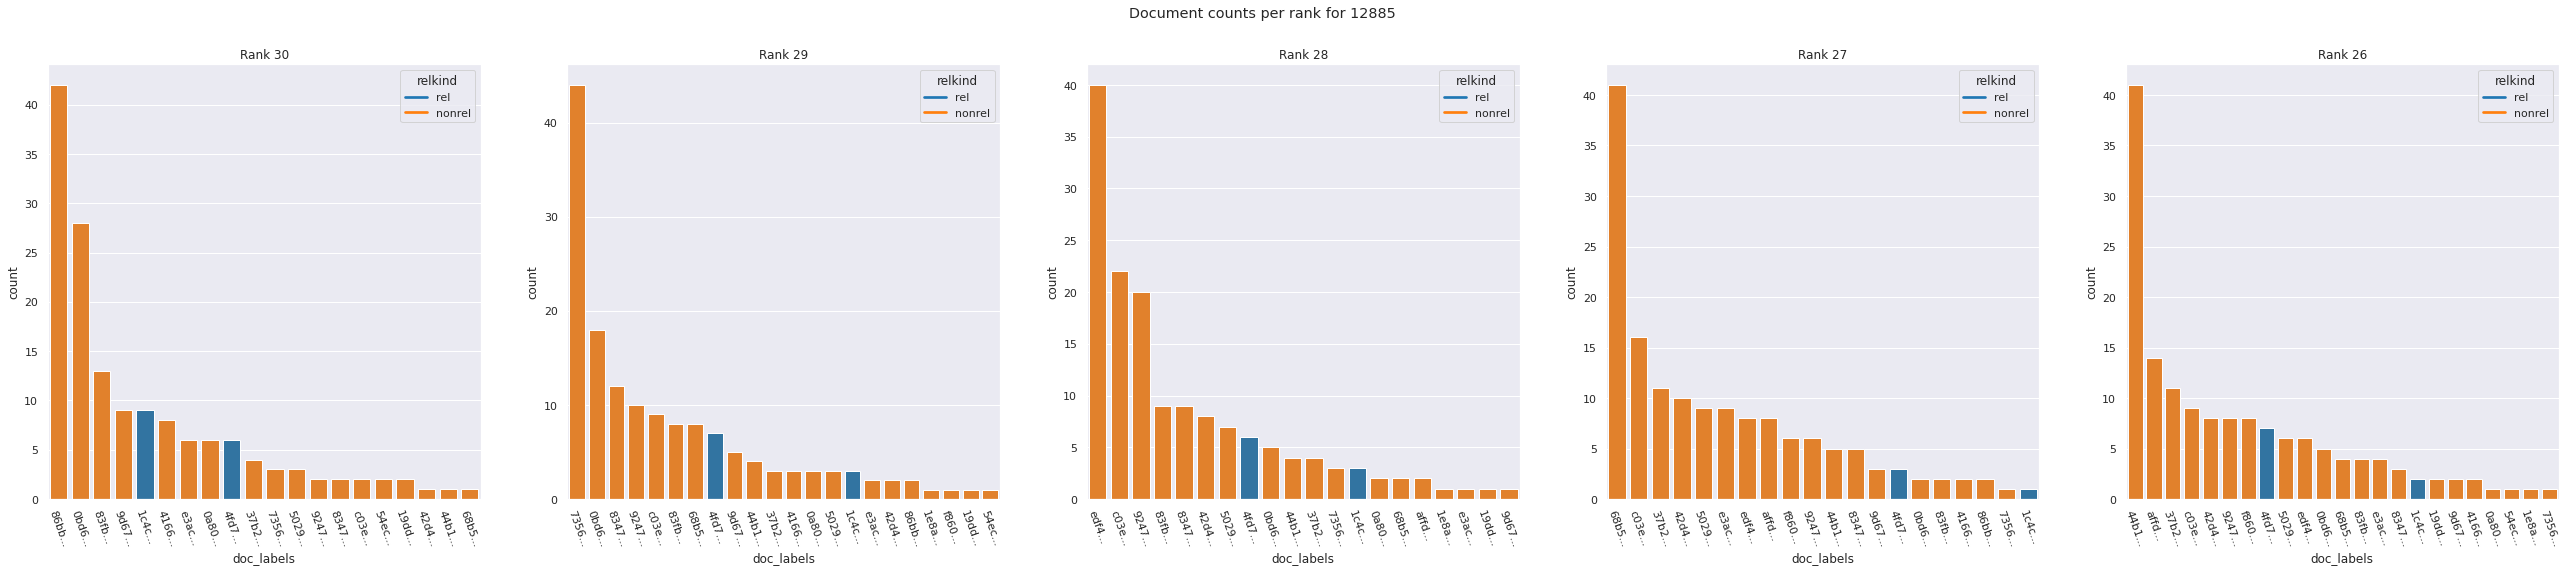

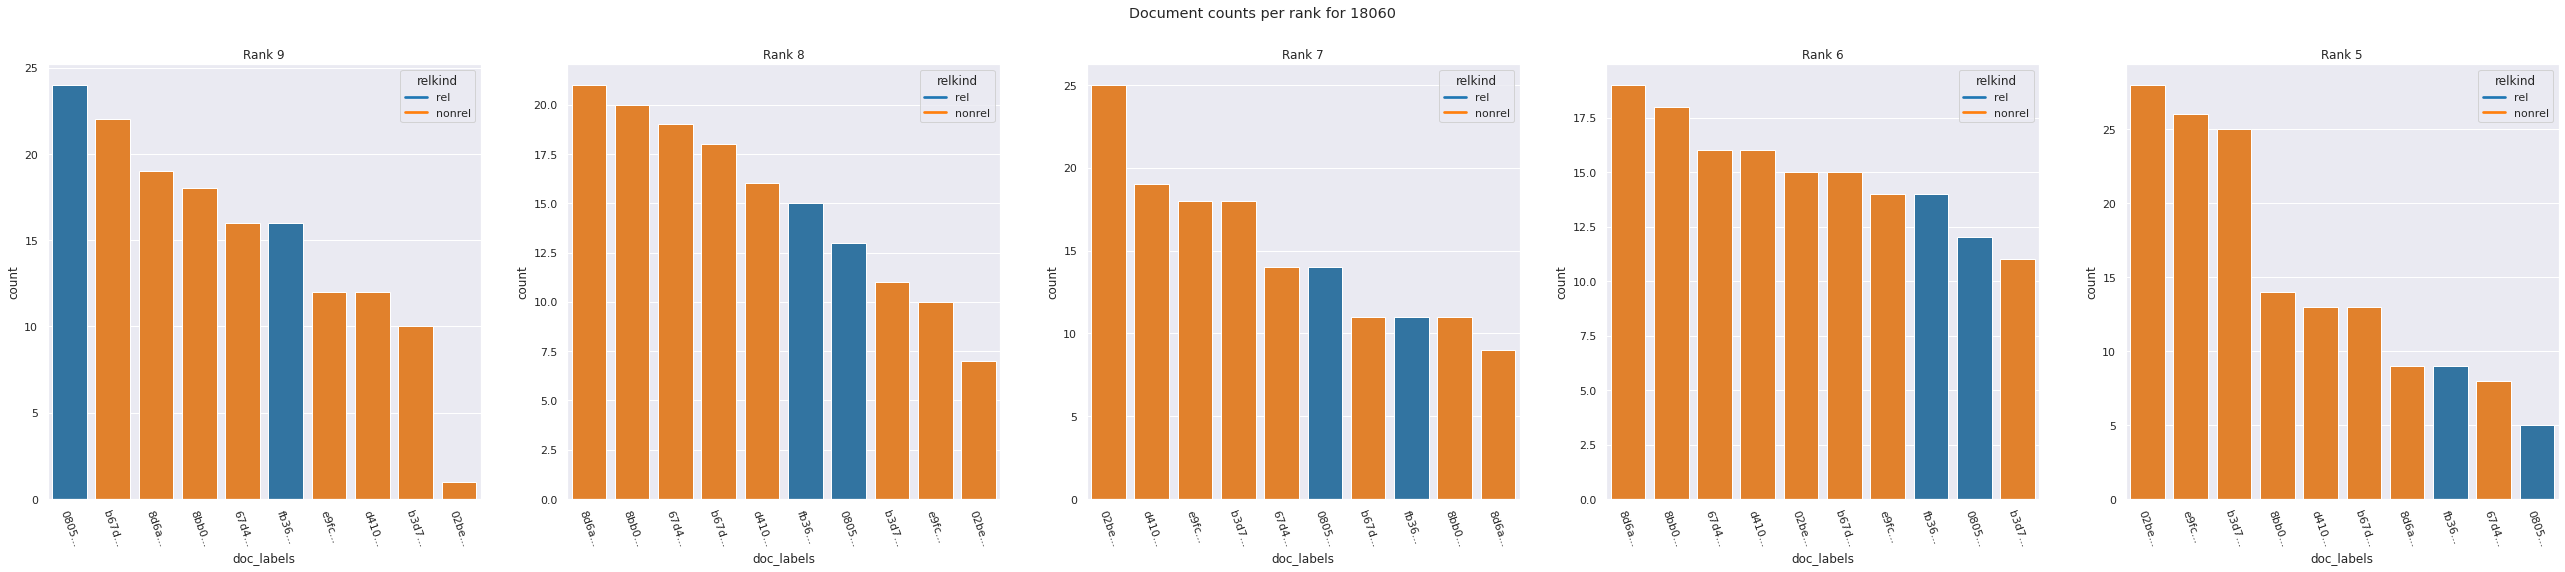

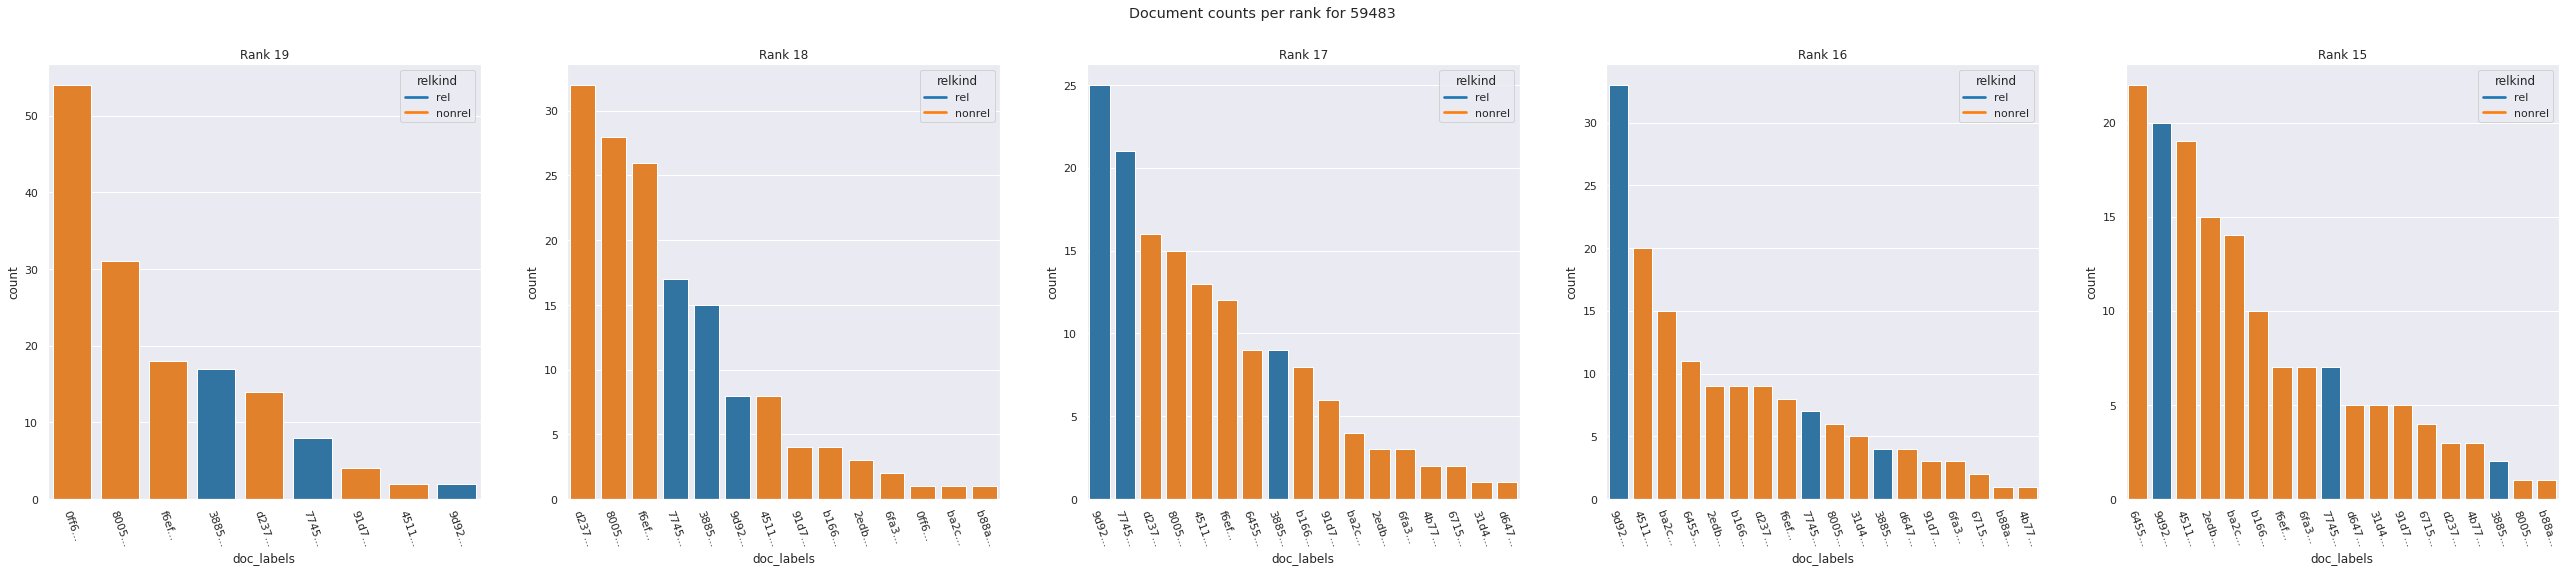

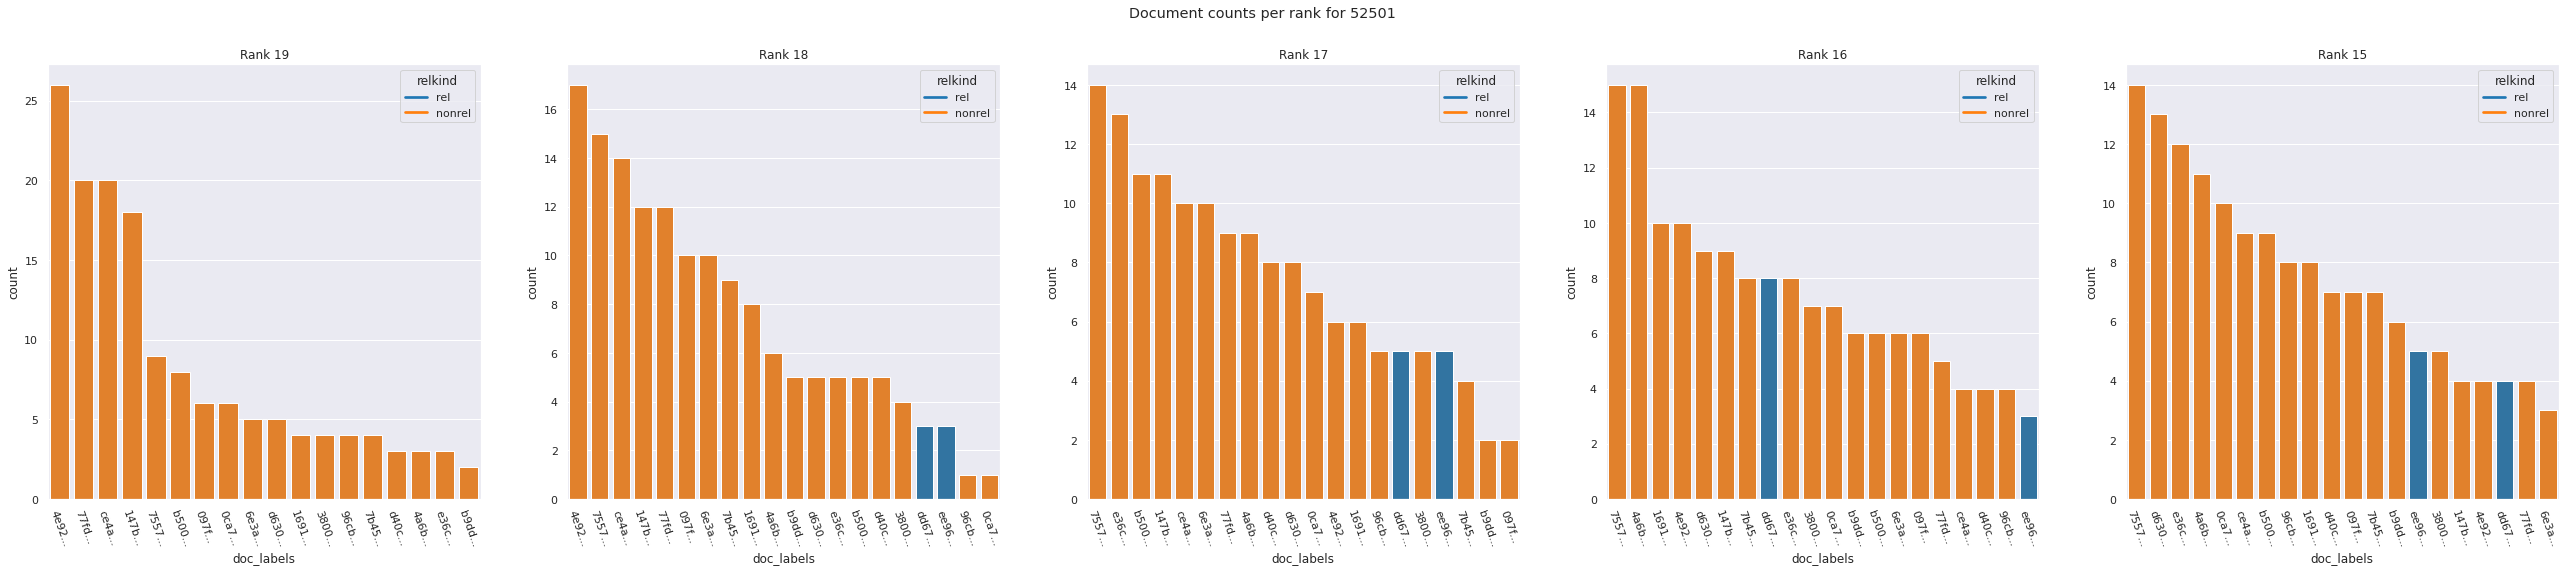

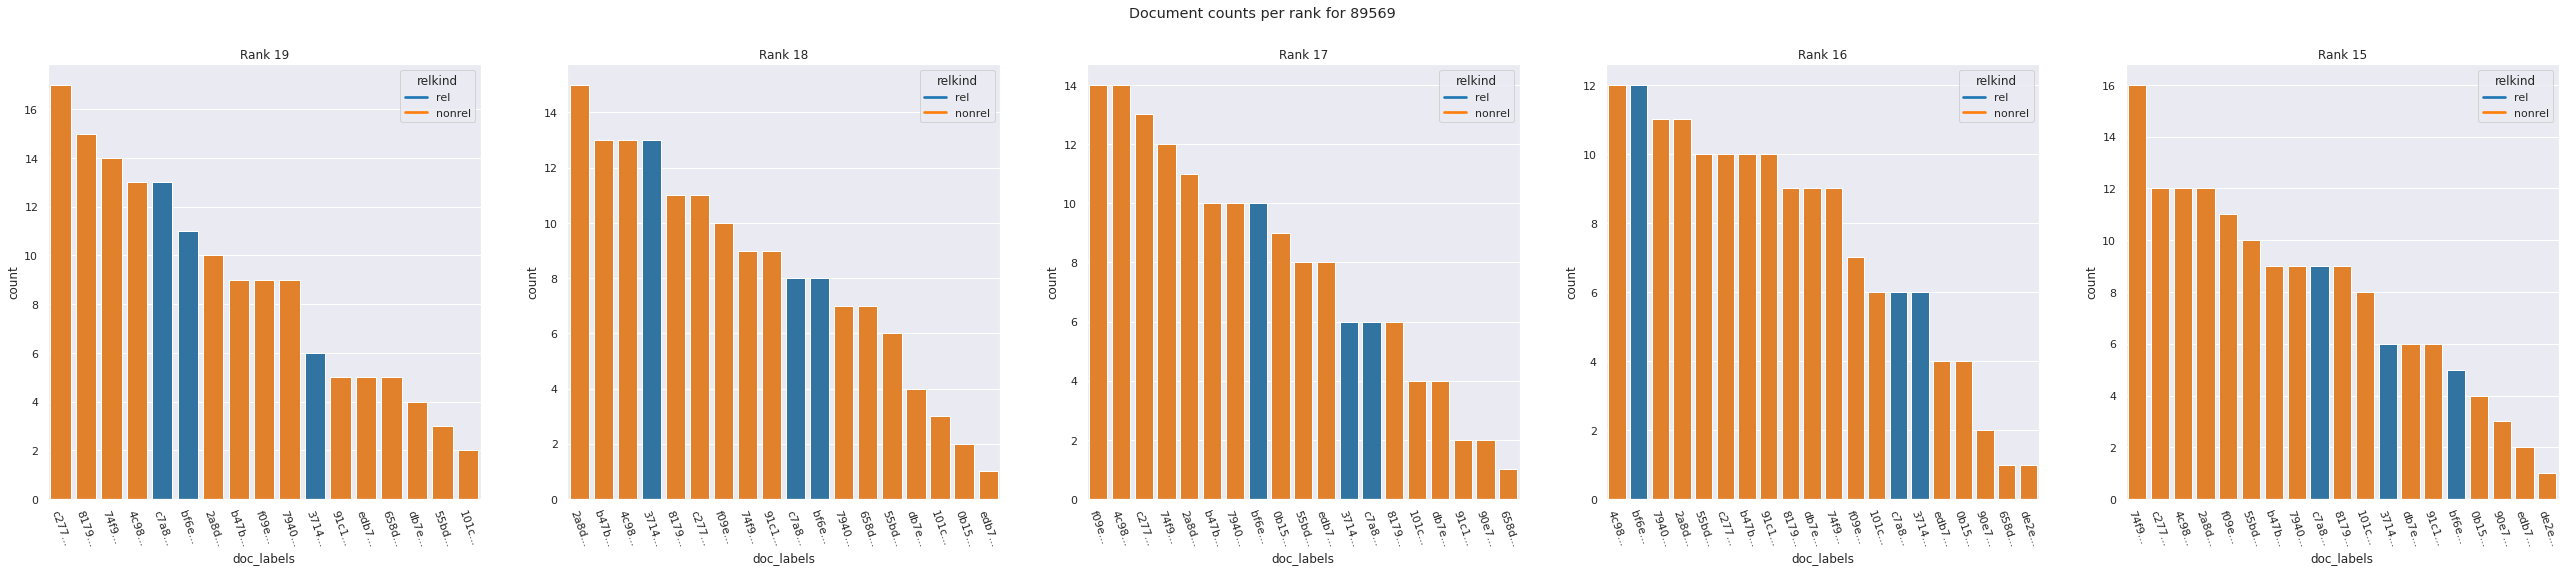

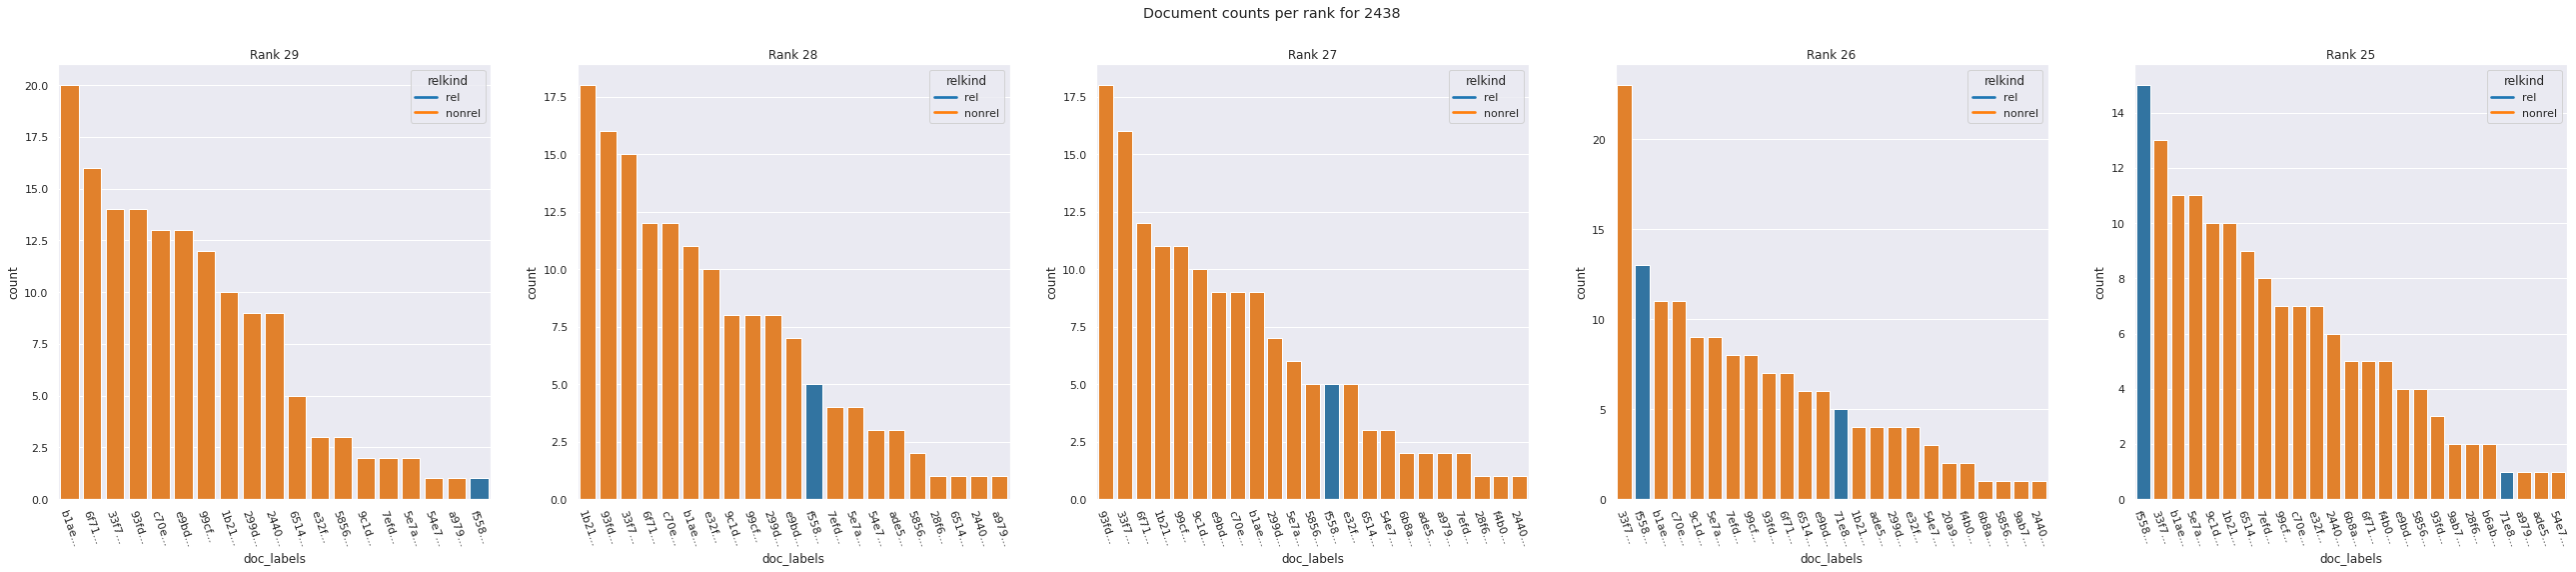

In [52]:
for q in bottomqueries.index.unique():
    rel,nonrel = count_relgrades_qid(q,reldf)
    plot_doc_occurrence_per_rank_for_qid(q,rdf,reldf,k=5,rev=True)

##### Bottom positions

The bottom positions look more regular. They diminish more gently, without big spikes. They also look pretty similar between the top and bottom queries.

An exception is top query 91643, which has a larger spike of an irrelevant document in the bottom rank.
An exception is bottom query 12885, which has a larger spike of an irrelevant document in the bottom rank.

In general, what happens in the bottom positions is less impactful than what happens at the top positions, because of the way DGEE is computed. However, for short rankings the bottom positions may still have a large influence.


### Document position (top/bottom) counts

We plot how often each document occurs in a top or bottom position. In an ideal scenario, there is a uniform distribution across relevant docs for top positions and non-relevant docs in bottom positions.

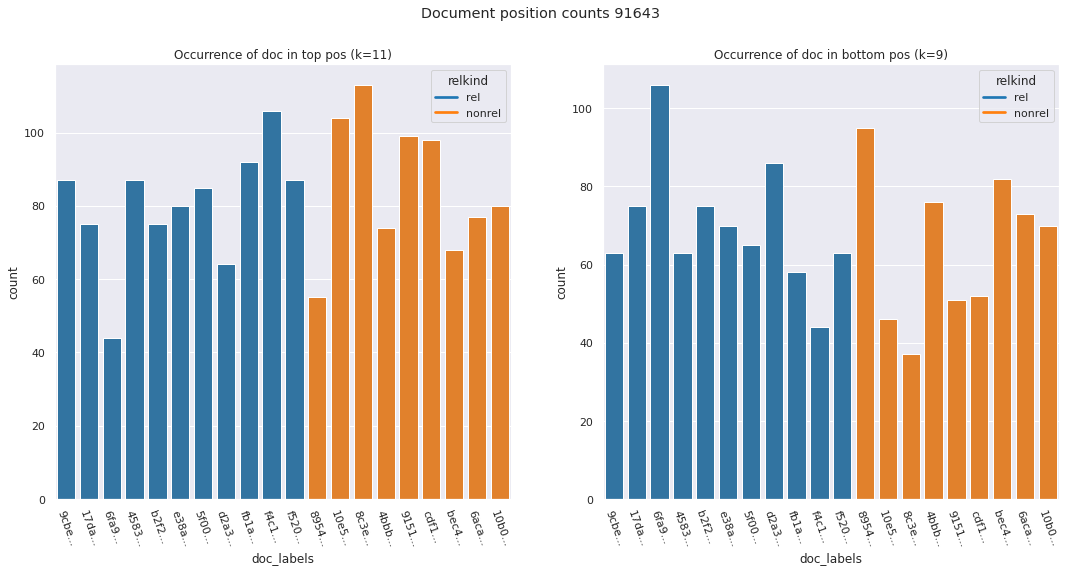

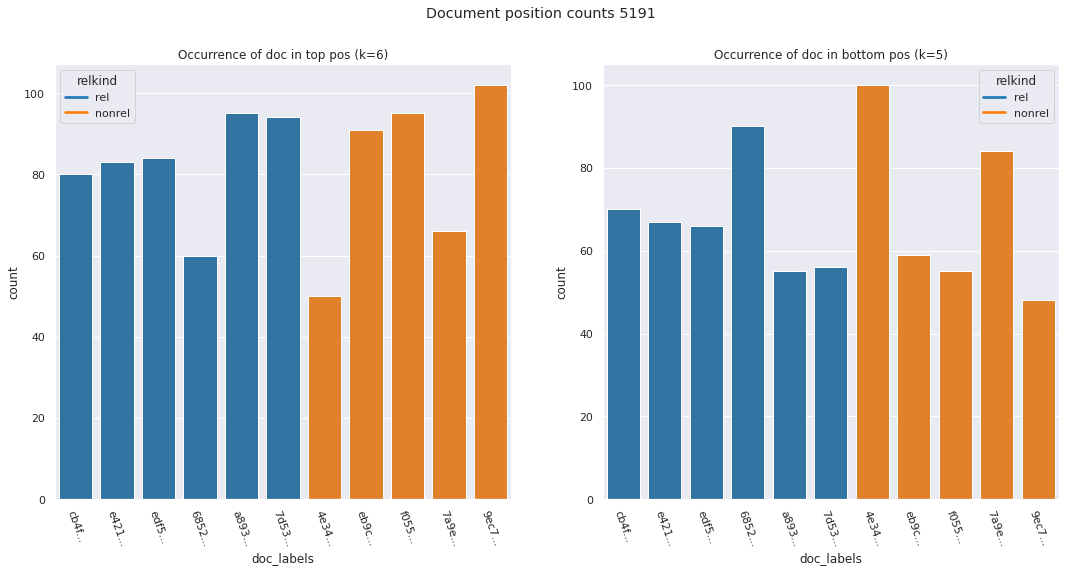

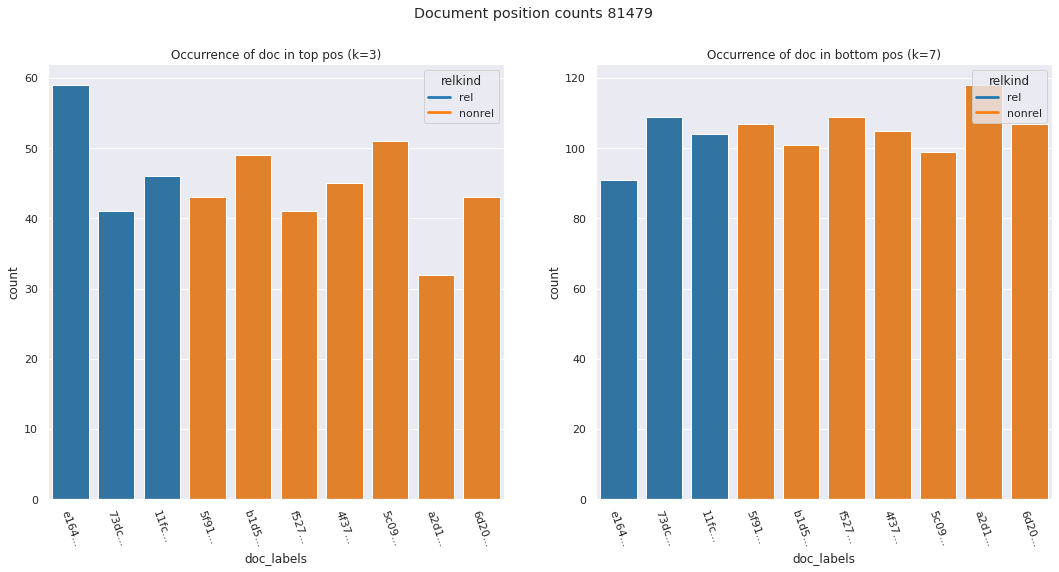

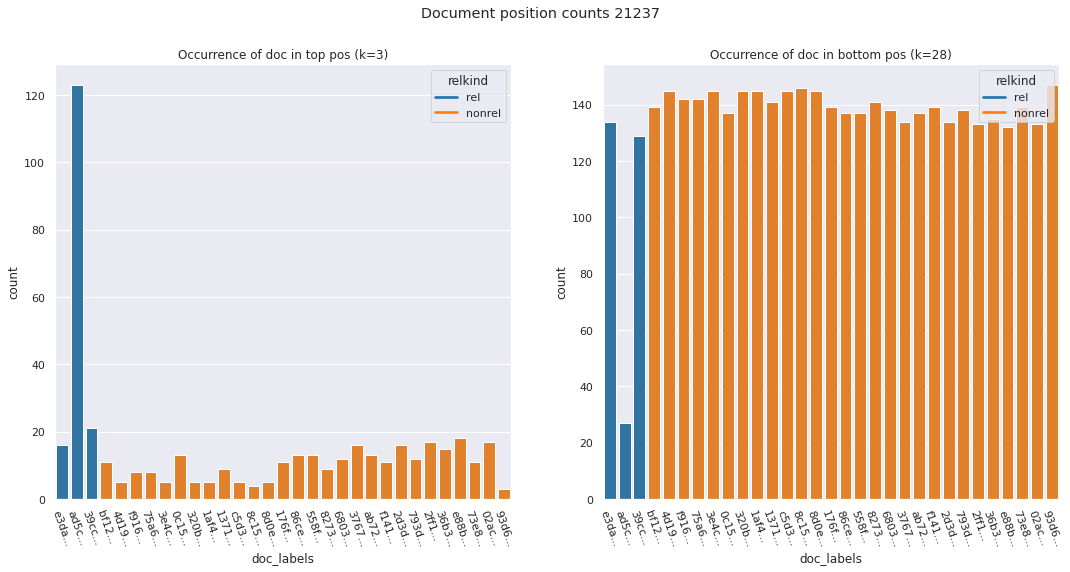

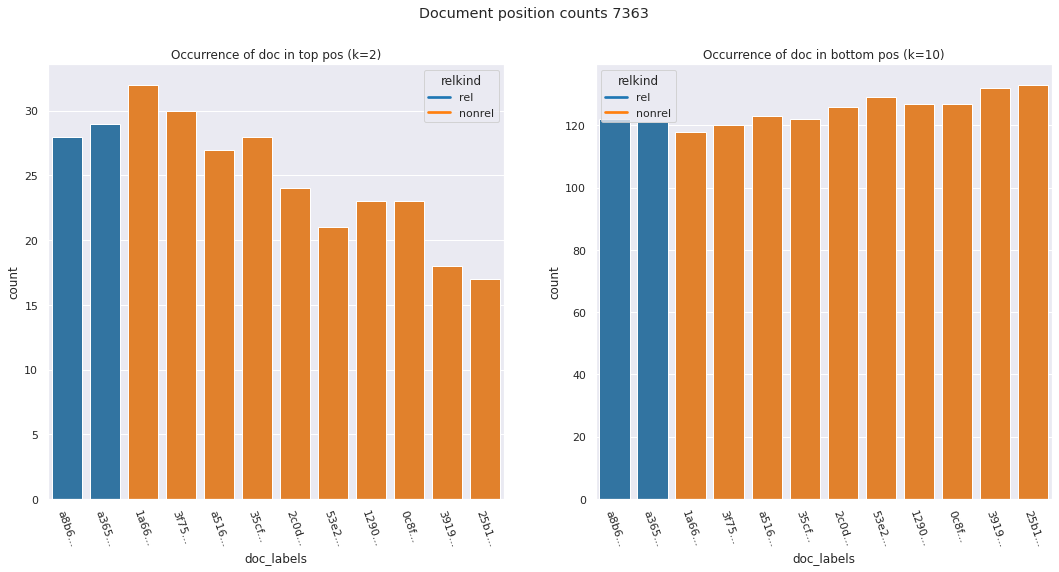

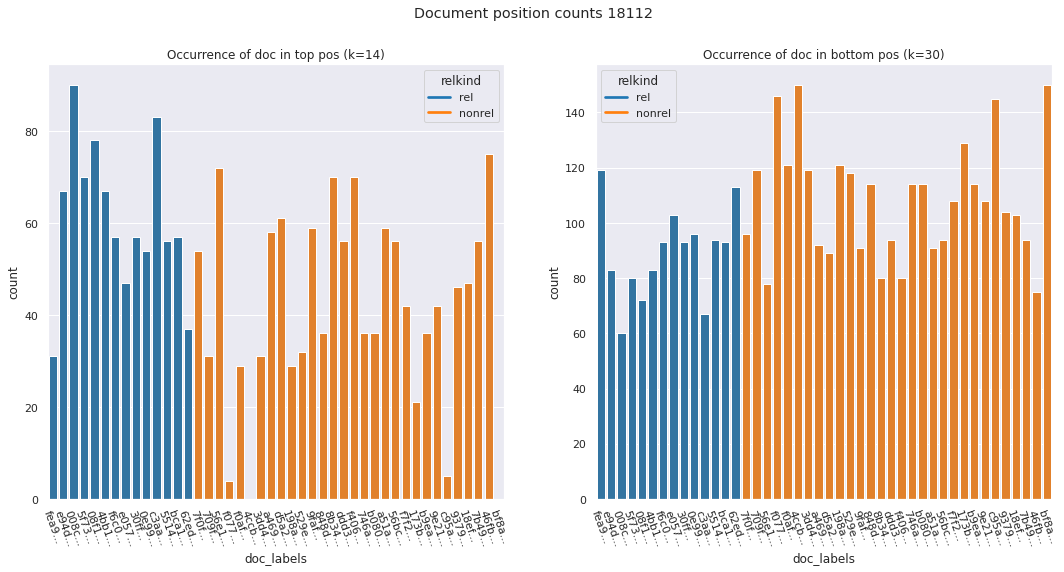

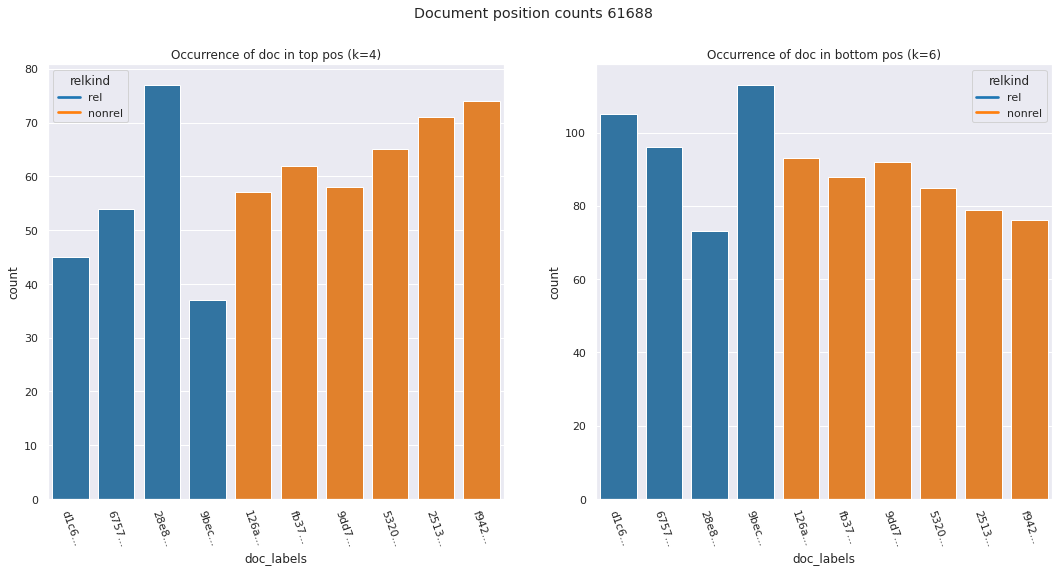

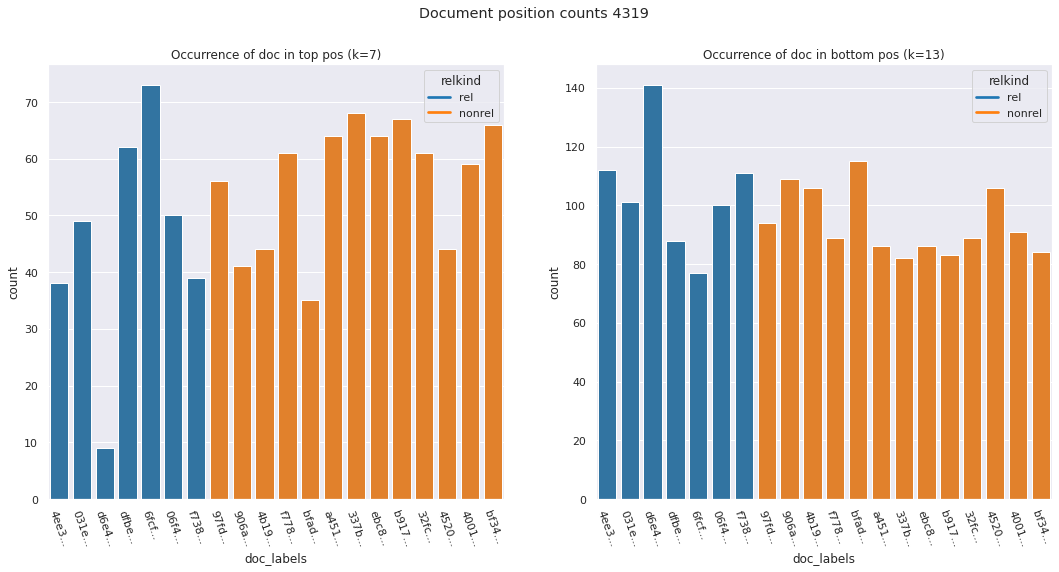

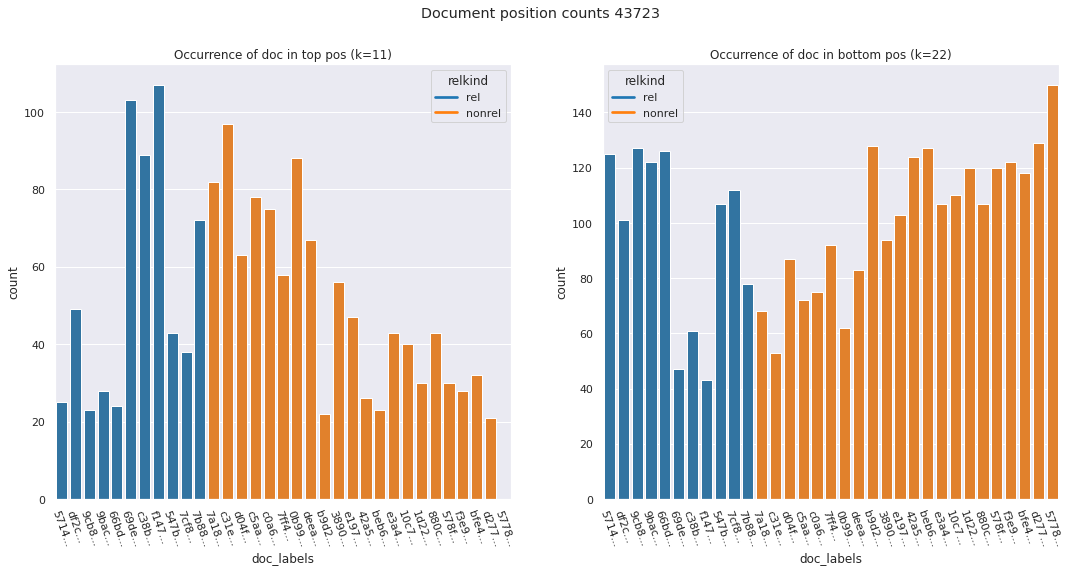

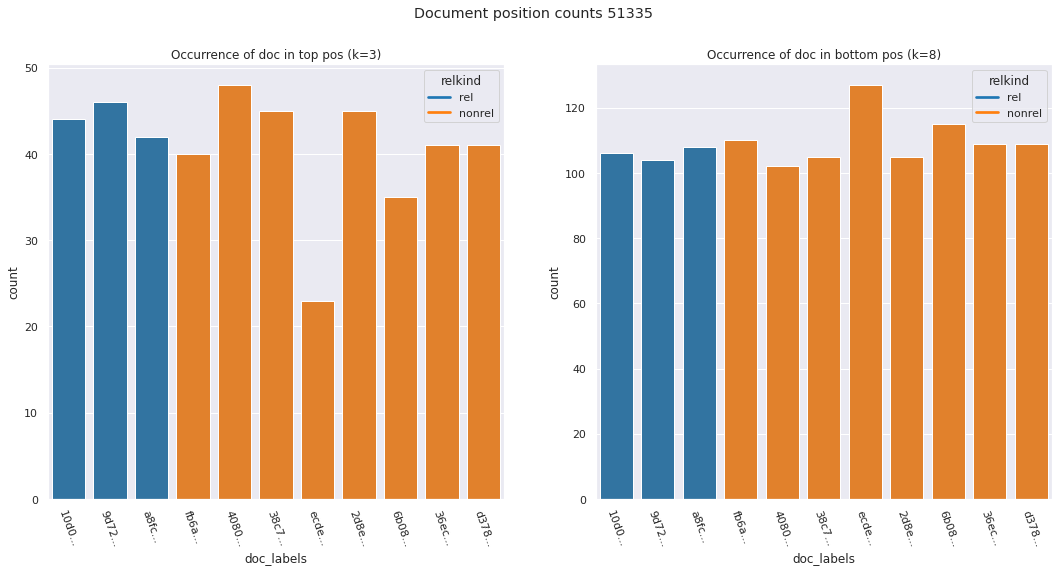

In [53]:
for q in topqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf)

##### Top queries
Some things catch the eye:
- In general, there is a reasonably even distribution across the relevant documents in top positions and non-relevant documents in bottom positions.
- However, there are a couple of queries that have a spike for a relevant document in a top position.
    - Authorless?
- There is also qid=4319 for which the top documents are more inconsistent, and one of them is even missing.
    - Why does this query still perform well? Why is that one document missing?
- There aren't necessarily fewer non-relevant documents in top positions, but they don't spike out.
- The distribution in bottom positions is reasonably even between relevant/ non-relevant documents, bar some dips that correspond to spikes in the top positions.
    

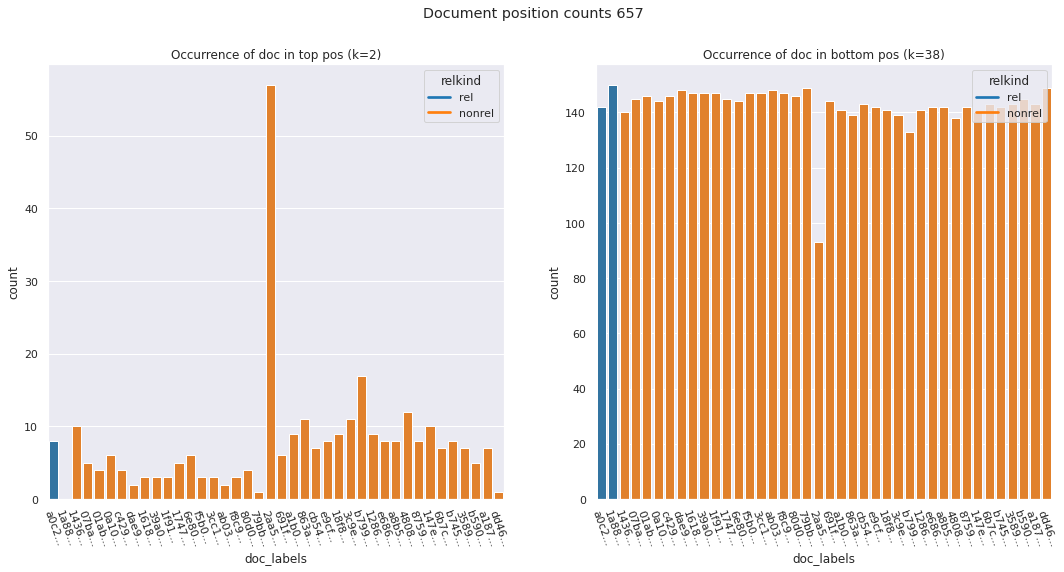

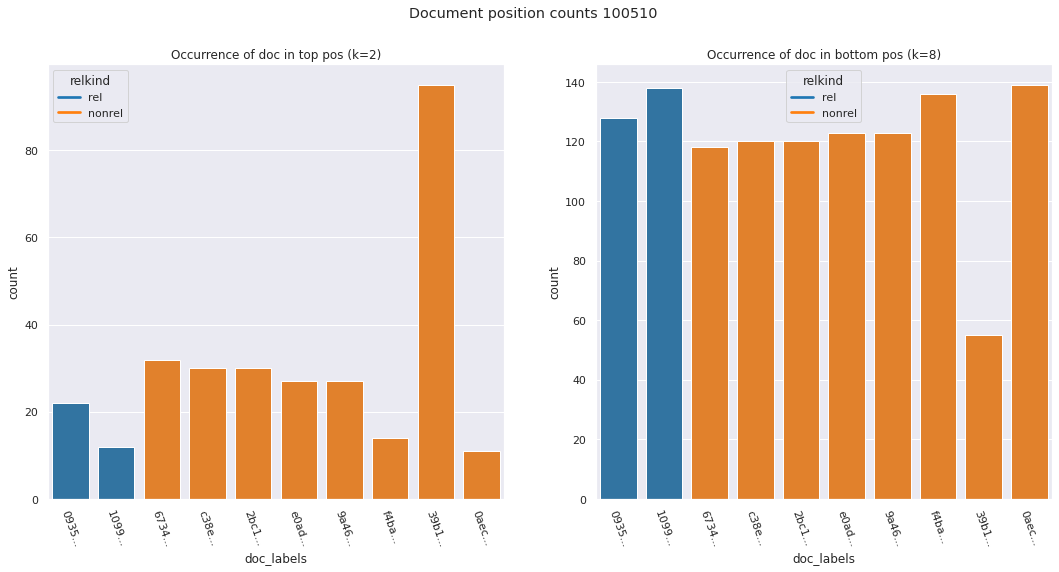

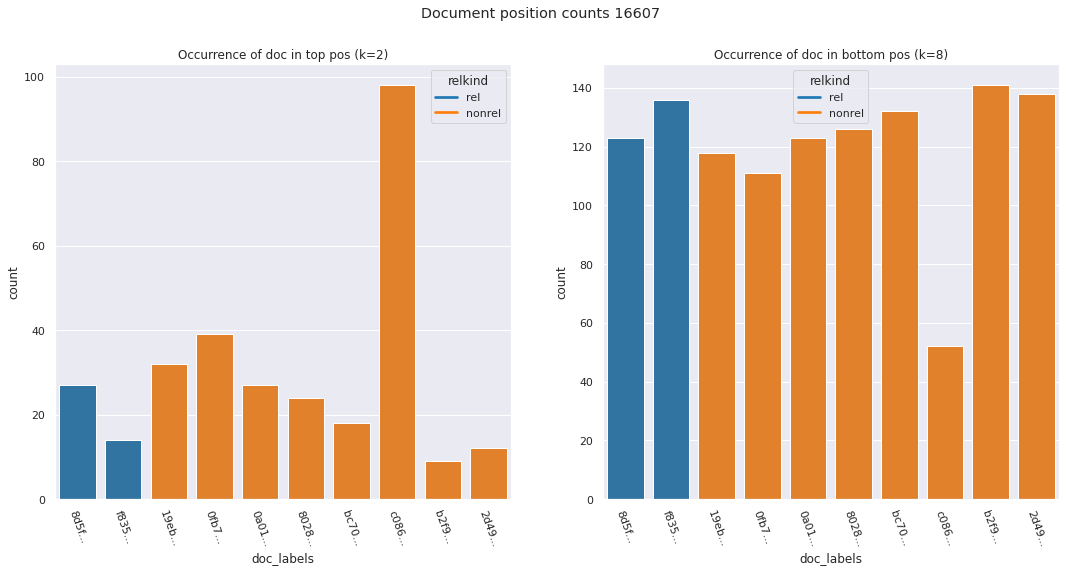

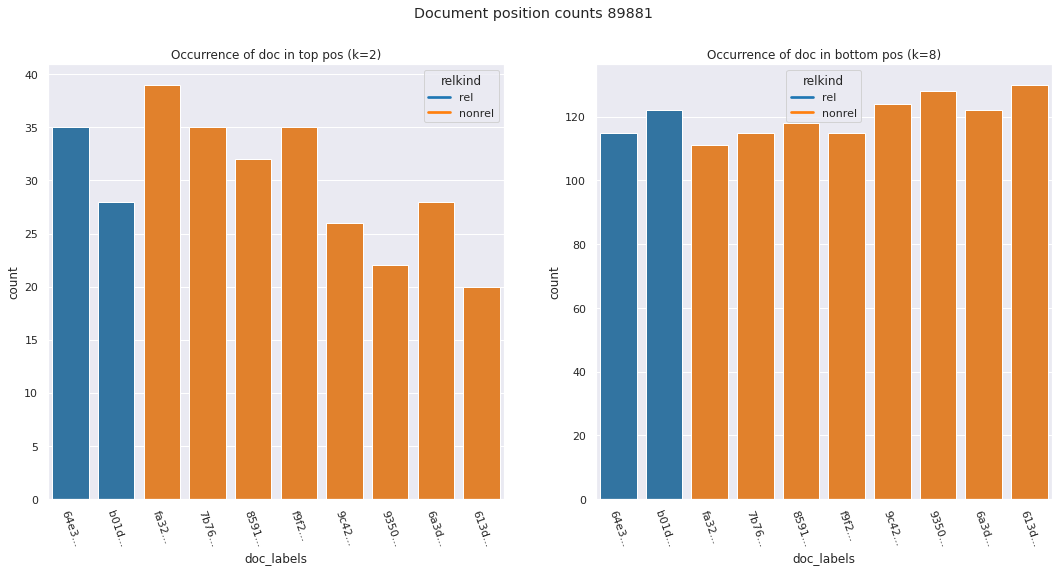

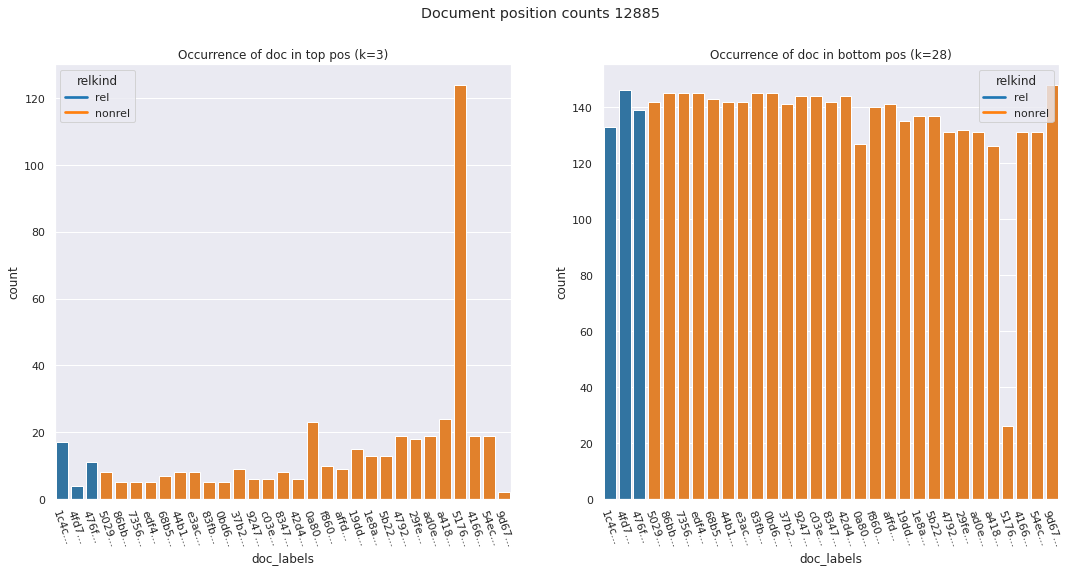

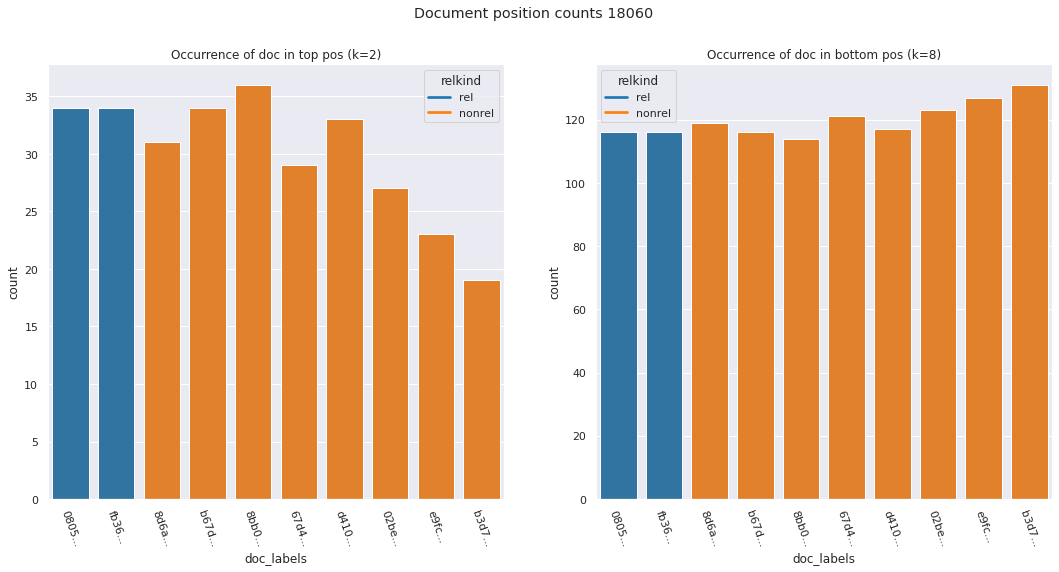

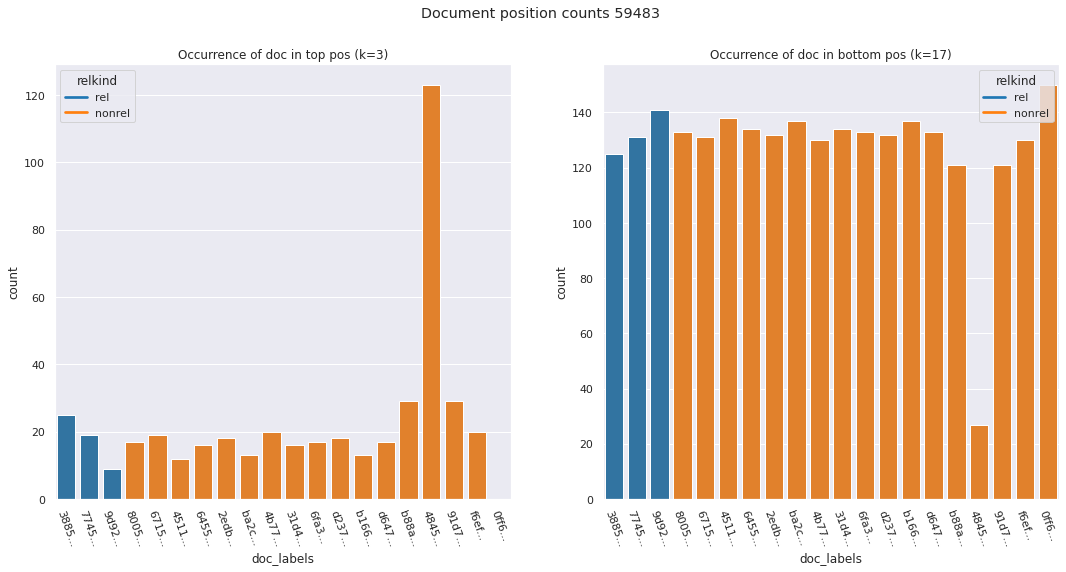

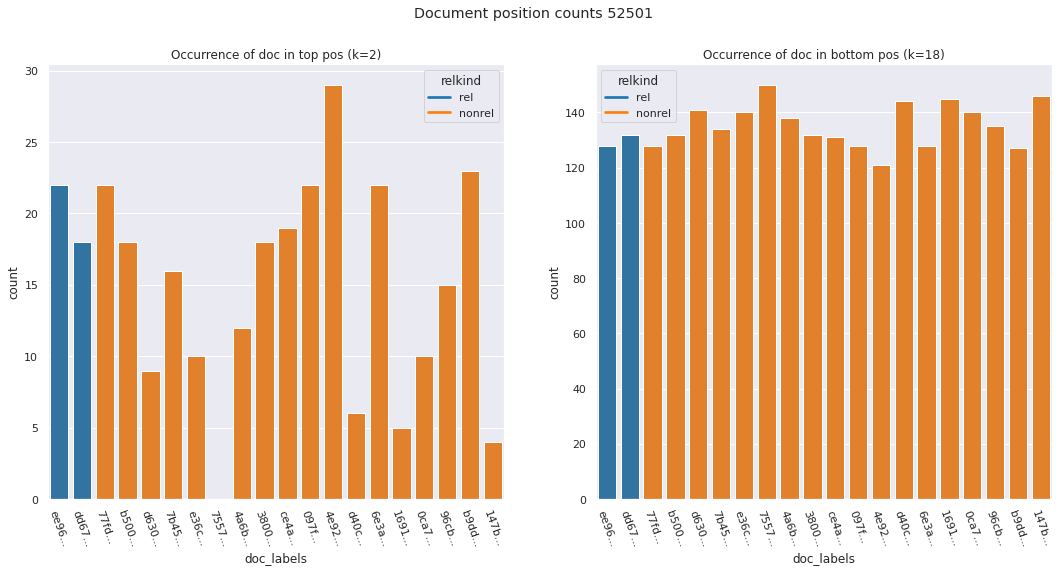

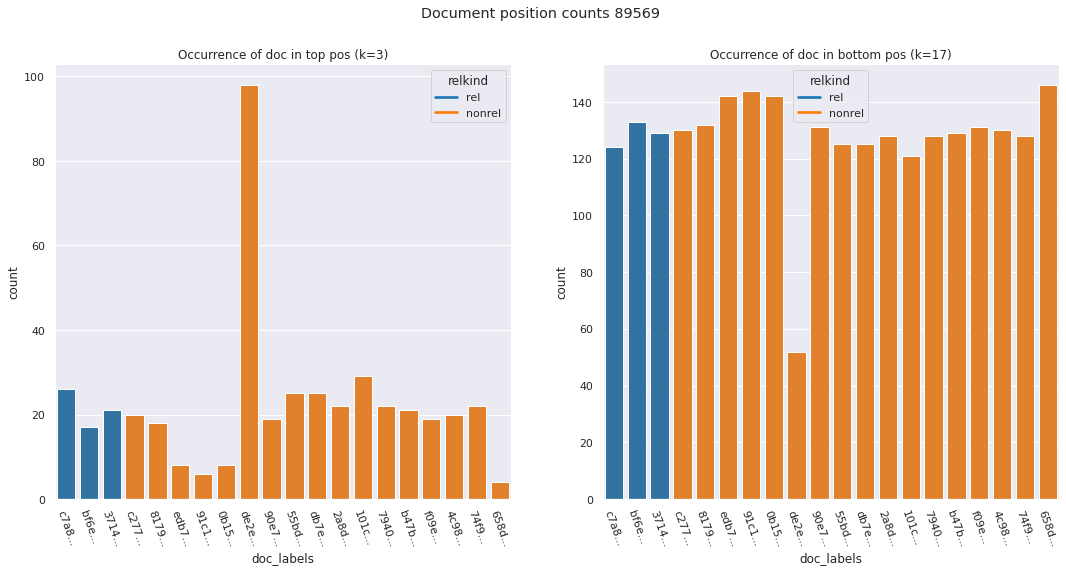

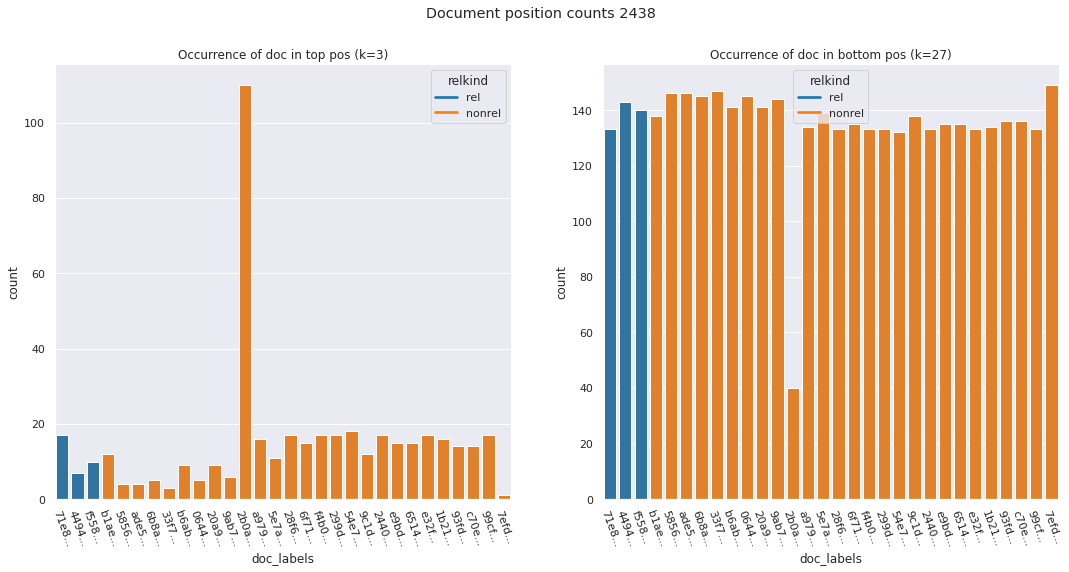

In [54]:
for q in bottomqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf)

## Hypotheses

Based on the plots we form a number of hypotheses:

1. Queries perform well when they have a high fraction of relevant items.
2. Queries perform well when they have a large number of items.
3. Queries perform poorly when they have many documents without author.
 - Conversely: queries perform well when they have many many documents without author, because then the ranking is more or less relevance-based.

4. All of the documents that spike in the rankings have no author.
5. Documents that are missing from their "proper" position (mainly relevant documents for top positions) have a low estimated relevance.



6. Documents for which the estimated relevance is too high/too low have been incorrectly judged by the NIST assessors.



7. For top queries, the documents without author are mainly relevant. For bottom queries, they are mainly irrelevant.

check:
- for each query for each rank, how often does a no-author document appear there and is it relevant or not?
    

### Hypothesis 1: Queries perform well when they have a high fraction of relevant items

In [55]:
def get_k_results(eval_df,k=10,asc=True):
    sub = eval_df.sort_values(by='difference',ascending=asc).head(k).reset_index()
    return sub

In [56]:
def rel_nonrel_stats_df(eval_df, k=10, asc=True):
    sub = get_k_results(eval_df,k,asc)
    sub[['r','nr']] = sub.apply(lambda row: count_relgrades_qid(row.qid,reldf), axis='columns', result_type='expand')
    sub[['rfrac','nrfrac']] = sub.apply(lambda row: {'rfrac': row.r / (row.r + row.nr), 'nrfrac': row.nr / (row.r + row.nr) }, axis='columns', result_type='expand')
    return sub

There are 62 items with a difference higher than the total mean, and 138 items with a difference lower than the total mean.

In [57]:
print("DGEE > mean:\t", len(edf[edf.difference > edf.difference.mean()]))
print()
print("DGEE <= mean:\t", len(edf[edf.difference <= edf.difference.mean()]))

DGEE > mean:	 62

DGEE <= mean:	 138


Taking the average across all queries that have a difference lower (higher) than the mean, the items with a lower mean have a higher fraction of relevant items than the items that have a higher mean.

In [58]:
top = rel_nonrel_stats_df(edf, k=138)
bot = rel_nonrel_stats_df(edf, k=62, asc=False)

print("topqueries relmean:\t", top.rfrac.mean(),'\t',"botqueries relmean:\t\t", bot.rfrac.mean())
print("topqueries non-relmean:\t", top.nrfrac.mean(),'\t',"botqueries non-relmean:\t",bot.nrfrac.mean())


topqueries relmean:	 0.18171789232594615 	 botqueries relmean:		 0.14500607975914462
topqueries non-relmean:	 0.8182821076740538 	 botqueries non-relmean:	 0.8549939202408553


The effect is even more clear if we look at the top and bottom 20 queries.

In [59]:
top = rel_nonrel_stats_df(edf,k=20)
bot = rel_nonrel_stats_df(edf,k=20,asc=False)
print("topk=20 relmean:\t",top.rfrac.mean(),'\tbotk=20 relmean:\t',bot.rfrac.mean())
print("topk=20 nrelmean:\t",top.nrfrac.mean(),'\tbotk=20 nrelmean:\t',bot.nrfrac.mean())


topk=20 relmean:	 0.3009910461346338 	botk=20 relmean:	 0.12824308755760372
topk=20 nrelmean:	 0.6990089538653661 	botk=20 nrelmean:	 0.8717569124423964


In [60]:
for i in range(1,21):
    top = rel_nonrel_stats_df(edf,k=i)
    bot = rel_nonrel_stats_df(edf,k=i,asc=False)
    print(f"k={i}")
    print(f"top r:\t",round(top.rfrac.mean(),2),f'\tbot r:\t',round(bot.rfrac.mean(),2))
    print(f"top nr:\t",round(top.nrfrac.mean(),2),f'\tbot nr:\t',round(bot.nrfrac.mean(),2))
    print()

k=1
top r:	 0.45 	bot r:	 0.95
top nr:	 0.55 	bot nr:	 0.05

k=2
top r:	 0.55 	bot r:	 0.12
top nr:	 0.45 	bot nr:	 0.88

k=3
top r:	 0.47 	bot r:	 0.15
top nr:	 0.53 	bot nr:	 0.85

k=4
top r:	 0.37 	bot r:	 0.16
top nr:	 0.63 	bot nr:	 0.84

k=5
top r:	 0.33 	bot r:	 0.15
top nr:	 0.67 	bot nr:	 0.85

k=6
top r:	 0.33 	bot r:	 0.16
top nr:	 0.67 	bot nr:	 0.84

k=7
top r:	 0.34 	bot r:	 0.16
top nr:	 0.66 	bot nr:	 0.84

k=8
top r:	 0.34 	bot r:	 0.15
top nr:	 0.66 	bot nr:	 0.85

k=9
top r:	 0.34 	bot r:	 0.15
top nr:	 0.66 	bot nr:	 0.85

k=10
top r:	 0.33 	bot r:	 0.14
top nr:	 0.67 	bot nr:	 0.86

k=11
top r:	 0.33 	bot r:	 0.14
top nr:	 0.67 	bot nr:	 0.86

k=12
top r:	 0.33 	bot r:	 0.13
top nr:	 0.67 	bot nr:	 0.87

k=13
top r:	 0.32 	bot r:	 0.13
top nr:	 0.68 	bot nr:	 0.87

k=14
top r:	 0.31 	bot r:	 0.13
top nr:	 0.69 	bot nr:	 0.87

k=15
top r:	 0.3 	bot r:	 0.12
top nr:	 0.7 	bot nr:	 0.88

k=16
top r:	 0.3 	bot r:	 0.13
top nr:	 0.7 	bot nr:	 0.87

k=17
top r:	 0.29 	bo

In [61]:
data = rel_nonrel_stats_df(edf,k=200).reset_index()
data.head(5)

key  index    qid  difference  disparity  relevance   r  nr     rfrac  \
0        0  91643    0.019822   1.006921   0.868206  11   9  0.550000   
1        1   5191    0.044683   1.448939   1.344147   6   5  0.545455   
2        2  81479    0.046552   2.044160   1.889465   3   7  0.300000   
3        3  21237    0.053041   1.358547   1.149610   3  28  0.096774   
4        4   7363    0.053171   1.313280   1.085770   2  10  0.166667   

key    nrfrac  
0    0.450000  
1    0.454545  
2    0.700000  
3    0.903226  
4    0.833333

<AxesSubplot:xlabel='index', ylabel='rfrac'>

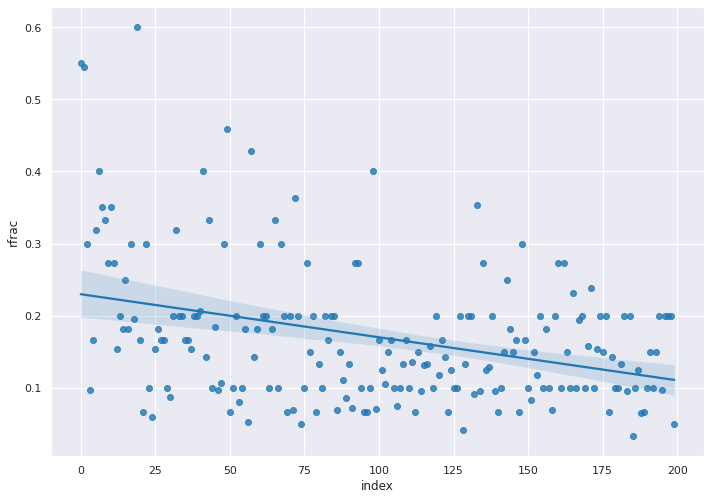

In [62]:
# sns.scatterplot(data=data, x="index", y="rfrac")
sns.regplot(data=data,x="index", y="rfrac")

We see a light descending line; the hypothesis is confirmed. The top queries have a higher fraction of relevant versus non-relevant items.

#### Subypothesis: The top queries have a higher average predicted relevance

- sum of estimated relevances for each relkind divided by number of items for that relkind

In [65]:
rel_and_estrel = pd.merge(pd.merge(edf.reset_index(),reldf[['qid','doc_rel','doc_id']], on='qid'),est_rel_meta, on=['qid','doc_id'])
rel_and_estrel['rel_estrel_diff'] = rel_and_estrel.apply(lambda row: abs(row.doc_rel - row.est_relevance),axis=1)
rel_and_estrel.head()

qid  difference  disparity  relevance  doc_rel  \
0   95    0.351999   2.936763   1.949844        0   
1   95    0.351999   2.936763   1.949844        0   
2   95    0.351999   2.936763   1.949844        0   
3   95    0.351999   2.936763   1.949844        0   
4   95    0.351999   2.936763   1.949844        1   

                                     doc_id  est_relevance  rel_estrel_diff  
0  b747dd12ec11da6ac79a29c9775a578dac354700       0.134897         0.134897  
1  0deef7e050171f0fb38e0d0733c9de67298891f7       0.186678         0.186678  
2  e32e8d862107f0758498e978be0afaa94f461340       0.188114         0.188114  
3  7b3b7bdba270b8c19c9e5af1c7c538f81a6e159c       0.214673         0.214673  
4  544cfaa2399034eea4a69426a7b2823ca7437d65       0.197669         0.802331

In [66]:
mean_estrel_per_relkind = rel_and_estrel.groupby(['qid','doc_rel']).mean().reset_index()
mean_estrel_per_relkind.head()

qid  doc_rel  difference  disparity  relevance  est_relevance  \
0   95        0    0.351999   2.936763   1.949844       0.159947   
1   95        1    0.351999   2.936763   1.949844       0.148076   
2  612        0    0.991691   1.731472   1.256254       0.152498   
3  612        1    0.991691   1.731472   1.256254       0.171778   
4  657        0    3.700546   2.631709   0.255715       0.155163   

   rel_estrel_diff  
0         0.159947  
1         0.851924  
2         0.152498  
3         0.828222  
4         0.155163

In [67]:
desired_index = edf.reset_index().sort_values(by='difference').reset_index(drop=True).reset_index()
desired_index.head()

key  index    qid  difference  disparity  relevance
0        0  91643    0.019822   1.006921   0.868206
1        1   5191    0.044683   1.448939   1.344147
2        2  81479    0.046552   2.044160   1.889465
3        3  21237    0.053041   1.358547   1.149610
4        4   7363    0.053171   1.313280   1.085770

In [68]:
mean_estrel_with_index = pd.merge(mean_estrel_per_relkind,desired_index[['index','qid']],on='qid')
mean_estrel_with_index.head()

qid  doc_rel  difference  disparity  relevance  est_relevance  \
0   95        0    0.351999   2.936763   1.949844       0.159947   
1   95        1    0.351999   2.936763   1.949844       0.148076   
2  612        0    0.991691   1.731472   1.256254       0.152498   
3  612        1    0.991691   1.731472   1.256254       0.171778   
4  657        0    3.700546   2.631709   0.255715       0.155163   

   rel_estrel_diff  index  
0         0.159947    128  
1         0.851924    128  
2         0.152498    181  
3         0.828222    181  
4         0.155163    199

<AxesSubplot:xlabel='index', ylabel='est_relevance'>

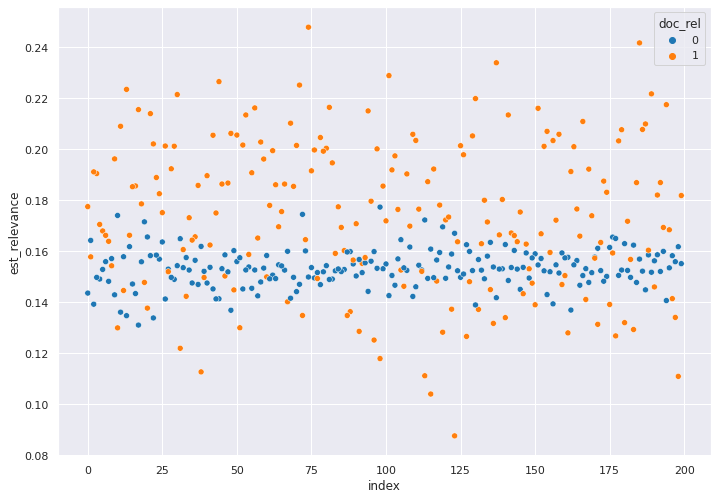

In [69]:
sns.scatterplot(data=mean_estrel_with_index,x='index',y='est_relevance',hue='doc_rel')

The top queries do *not* have a higher average predicted relevance than the bottom queries, so the discrepancy is likely *not* because of the estimated relevances.

#### Subhypothesis: The top queries have a higher fraction of items for which the actual and the predicted relevance are close to each other

Blur factor, fig 1 in [3], blur closer to true relevance is less unfairness compared to Plackett-Luce. May be because is better able to predict based on relevance also?

If the predicted relevances are closer to the actual relevances the ranker is better able to take relevance into account, leading to better results?

Plot: mean difference between predicted and actual relevances
Subplots: split by GT rel and nonrel items

In [70]:
rel_and_estrel = pd.merge(pd.merge(edf.reset_index(),reldf[['qid','doc_rel','doc_id']], on='qid'),est_rel_meta, on=['qid','doc_id'])
rel_and_estrel['rel_estrel_diff'] = rel_and_estrel.apply(lambda row: abs(row.doc_rel - row.est_relevance),axis=1)
rel_and_estrel.head()

qid  difference  disparity  relevance  doc_rel  \
0   95    0.351999   2.936763   1.949844        0   
1   95    0.351999   2.936763   1.949844        0   
2   95    0.351999   2.936763   1.949844        0   
3   95    0.351999   2.936763   1.949844        0   
4   95    0.351999   2.936763   1.949844        1   

                                     doc_id  est_relevance  rel_estrel_diff  
0  b747dd12ec11da6ac79a29c9775a578dac354700       0.134897         0.134897  
1  0deef7e050171f0fb38e0d0733c9de67298891f7       0.186678         0.186678  
2  e32e8d862107f0758498e978be0afaa94f461340       0.188114         0.188114  
3  7b3b7bdba270b8c19c9e5af1c7c538f81a6e159c       0.214673         0.214673  
4  544cfaa2399034eea4a69426a7b2823ca7437d65       0.197669         0.802331

In [71]:
mean_estrel_diff = rel_and_estrel.groupby('qid', as_index=False).mean()[['qid','difference','doc_rel','rel_estrel_diff']]
estrel_diff_sorted = mean_estrel_diff.sort_values(by='difference').reset_index(drop=True).reset_index()
estrel_diff_sorted.head()

index    qid  difference   doc_rel  rel_estrel_diff
0      0  91643    0.019822  0.550000         0.516999
1      1   5191    0.044683  0.545455         0.534038
2      2  81479    0.046552  0.300000         0.340151
3      3  21237    0.053041  0.096774         0.213623
4      4   7363    0.053171  0.166667         0.262525

In [72]:
desired_index = edf.reset_index().sort_values(by='difference').reset_index(drop=True).reset_index()
splitdata = rel_and_estrel.sort_values(by='difference').reset_index(drop=True)
splitdata = pd.merge(splitdata,desired_index[['qid','index']],on='qid')
splitdata.head()

qid  difference  disparity  relevance  doc_rel  \
0  91643    0.019822   1.006921   0.868206        0   
1  91643    0.019822   1.006921   0.868206        0   
2  91643    0.019822   1.006921   0.868206        1   
3  91643    0.019822   1.006921   0.868206        1   
4  91643    0.019822   1.006921   0.868206        1   

                                     doc_id  est_relevance  rel_estrel_diff  \
0  9151adf8caa27053bd3bc4adf1390fdfb3205fa2       0.154875         0.154875   
1  8954067bccf3f36cfb46f22c40df207028ecb63a       0.226915         0.226915   
2  5f009ab833e1f9ad39a7d86c70150e80378977f7       0.183269         0.816731   
3  9cbe474540321289c6c321bc8325f5ac28613c8f       0.145132         0.854868   
4  f520d727e7e76253c1d77f26c573474437858593       0.148823         0.851177   

   index  
0      0  
1      0  
2      0  
3      0  
4      0

Text(0.5, 0.98, 'Mean difference between actual and predicted relevances for each query (sorted by ascending DGEE)')

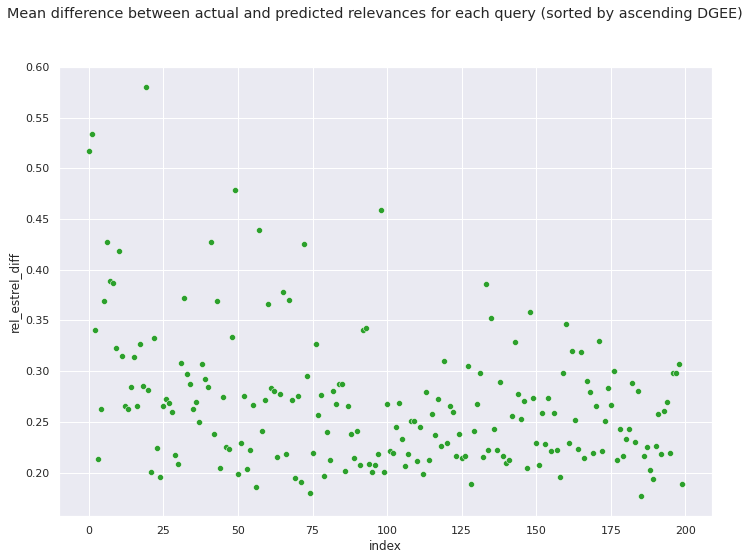

In [73]:
fig, ax = plt.subplots(1,1)
pi = iter(sns.color_palette())
next(pi)
next(pi)
sns.scatterplot(data=estrel_diff_sorted,x='index',y='rel_estrel_diff',ax=ax,color=next(pi))
fig.suptitle("Mean difference between actual and predicted relevances for each query (sorted by ascending DGEE)")

Text(0.5, 0.98, 'Difference between estimated and actual relevance for non-relevant documents for each query, ordered by ascending DGEE')

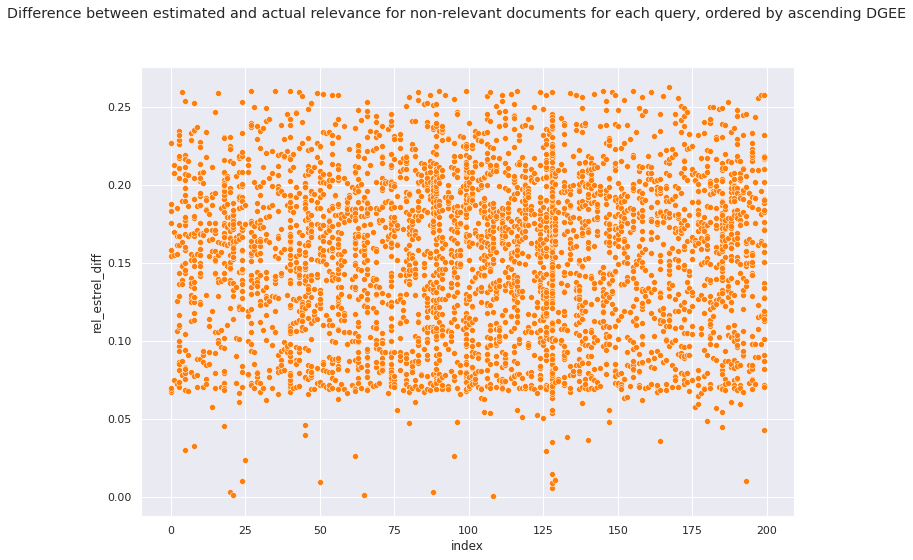

In [74]:
fig, ax = plt.subplots(1,1)
pi = iter(sns.color_palette())
next(pi)
sns.scatterplot(data=splitdata[splitdata.doc_rel == 0],x='index',y='rel_estrel_diff', color=next(pi))
fig.suptitle('Difference between estimated and actual relevance for non-relevant documents for each query, ordered by ascending DGEE')

Text(0.5, 0.98, 'Difference between estimated and actual relevance for relevant documents for each query, ordered by ascending DGEE')

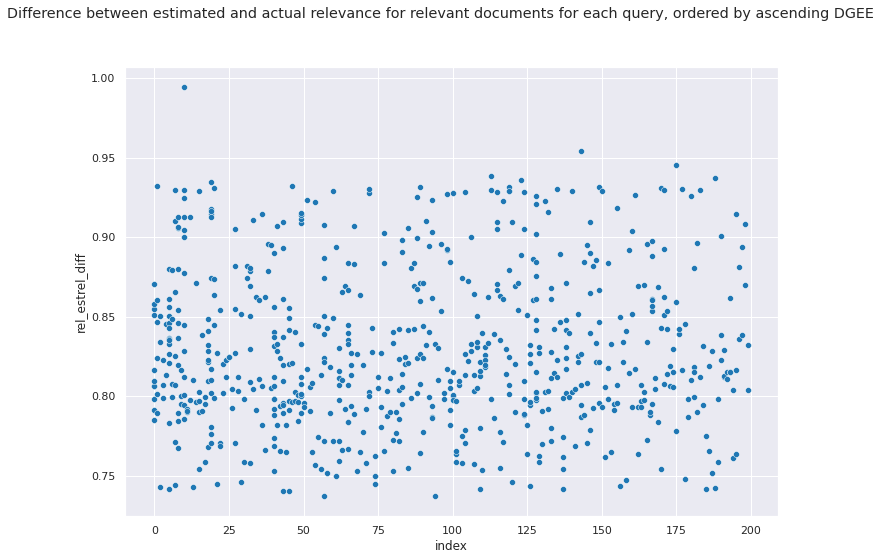

In [75]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=splitdata[splitdata.doc_rel == 1],x='index',y='rel_estrel_diff')
fig.suptitle('Difference between estimated and actual relevance for relevant documents for each query, ordered by ascending DGEE')

We see a couple of things:
1. The mean difference between estimated relevance and actual relevance is larger for the best queries. Contrary to our hypothesis.
2. For the non-relevant items, the difference in estimated and actual relevance is reasonably the same across all queries.
3. For the relevant items, we see a couple of outliers for which the difference is much larger than for the rest of the documents. 

#### To find out
- [ ] Which documents correspond to the outliers?
- [ ] What is their impact on the quality of the rankings?

### Hypothesis 2: Queries perform well when they have a large number of items
The thought being: many items give a chance for averaging out mistakes.

### Hypothesis 4: All of the documents that spike in the rankings have no author.

Show the documents without author in a different color.

In [76]:
def find_docs_without_author(relevance):
    es = Elasticsearch([{'timeout':300}])
    
    all_ids = list(relevance.doc_id.unique())
    res = es.search(index='semanticscholar2020og', body={'size':len(all_ids),'query':{'ids':{'values':all_ids}}})
    returned_ids = [hit['_id'] for hit in res['hits']['hits']]
    not_in_index = list(set(all_ids) - set(returned_ids))
    no_author_in_idx = [hit['_id'] for hit in res['hits']['hits'] if not hit['_source']['author_ids']]
    
    no_author = list(set(not_in_index + no_author_in_idx))
    return no_author

In [77]:
def has_author_df(no_author_ids, relevance):
    relevance['has_author'] = relevance.apply(lambda row: row.doc_id not in no_author_ids,axis='columns')
    return relevance[['doc_id','has_author']].drop_duplicates()

In [78]:
noauth_ids = find_docs_without_author(reldf)

In [79]:
author_info = has_author_df(find_docs_without_author(reldf),reldf)
author_info.head()

doc_id  has_author
0  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4        True
0  008a2a2c765485af2e035a2572ba9fc1102eabff        True
0  4a1472c575488ed9acee6c5481f68b95a0c34092        True
0  ff8df0745136fb183ea72b783ff38f8a7ad5ceec        True
0  90605deb1da5e3d5548da12dc130fc0341a6a255        True

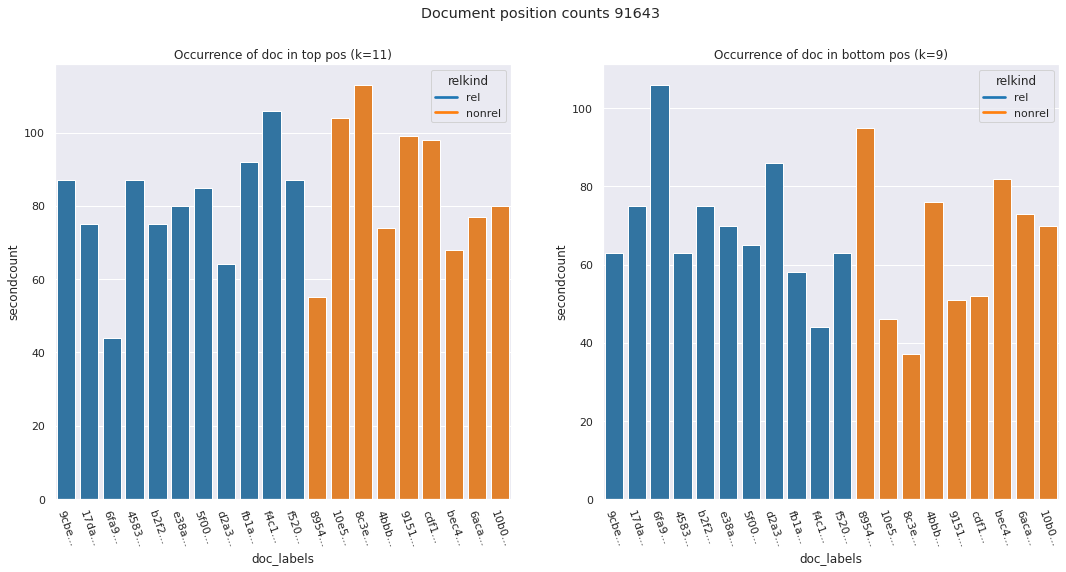

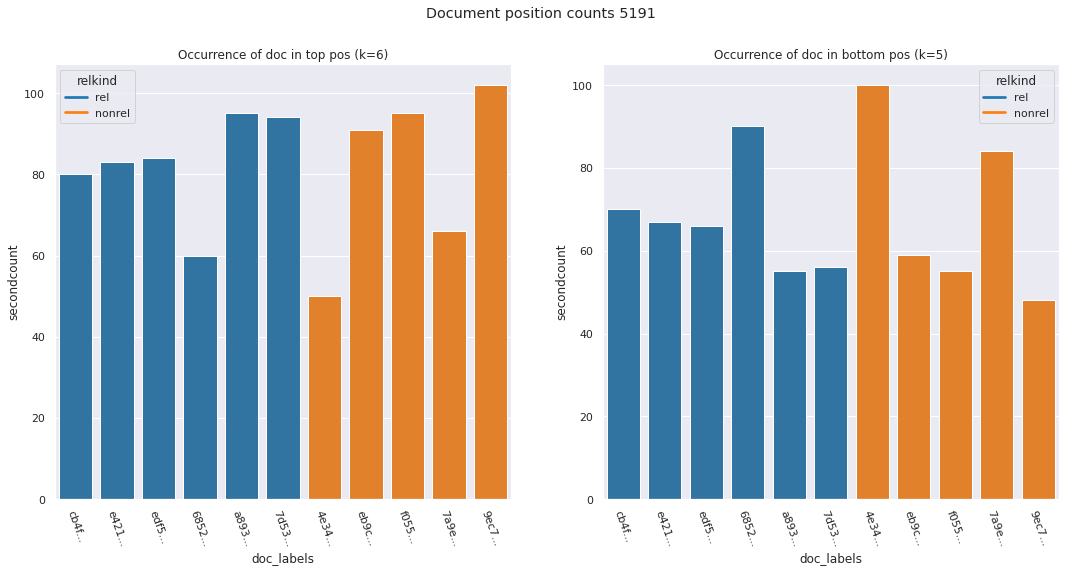

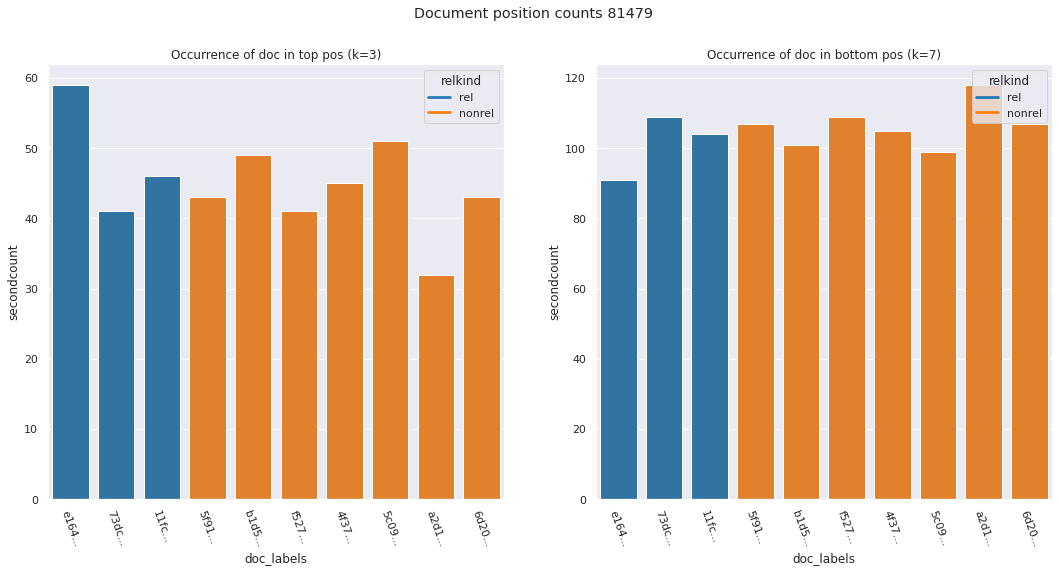

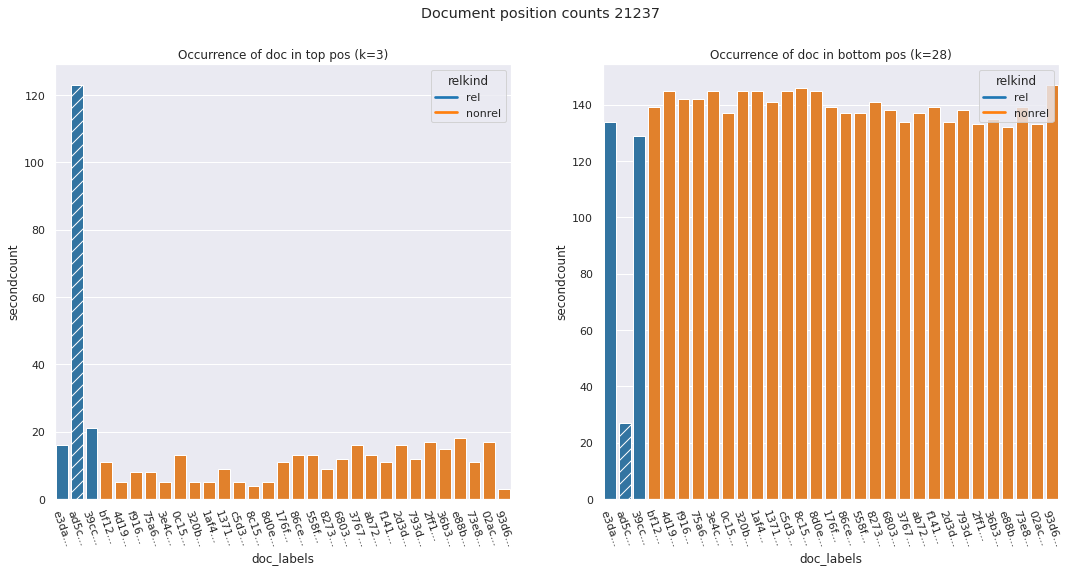

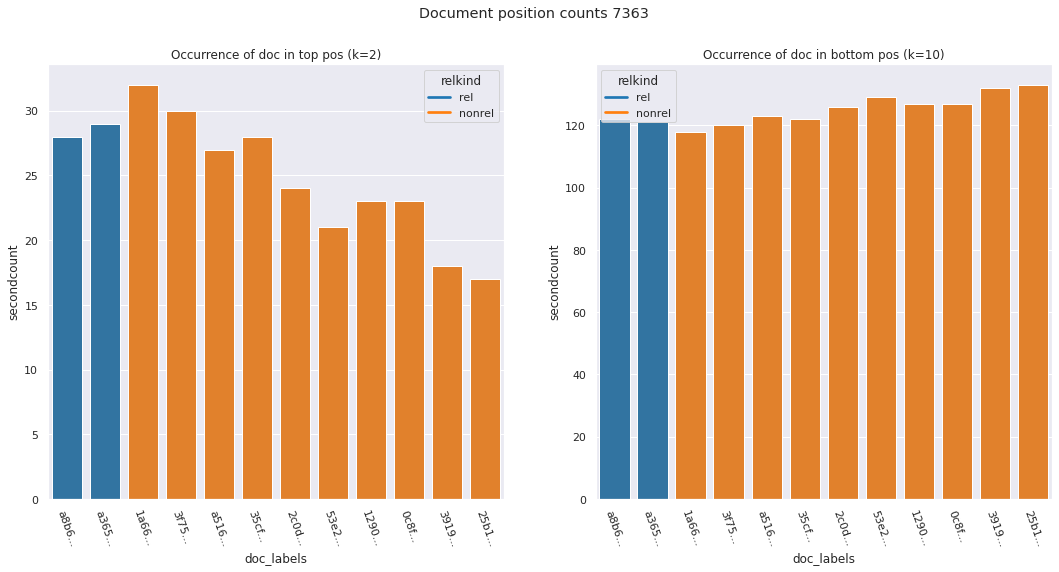

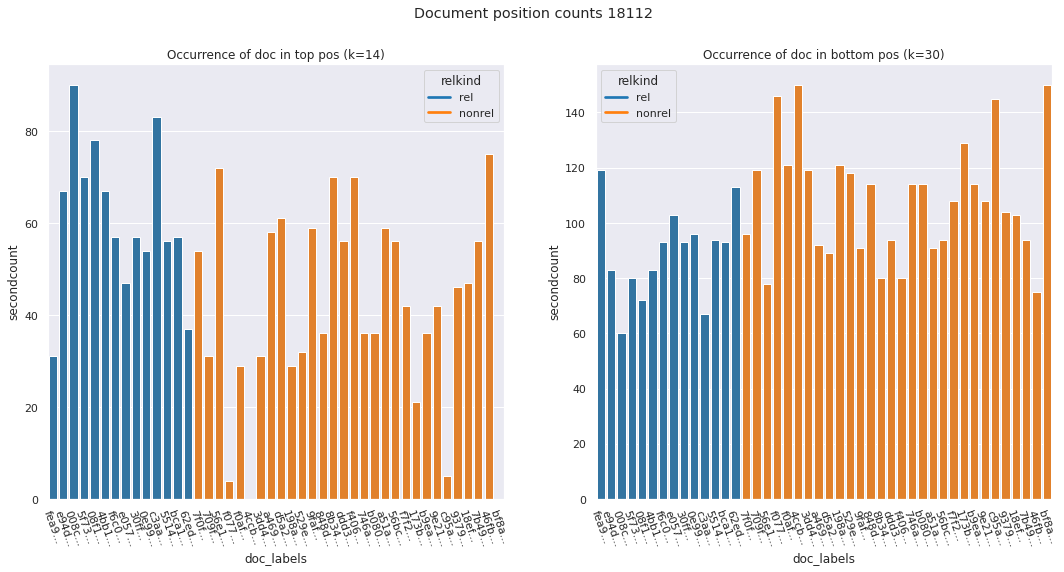

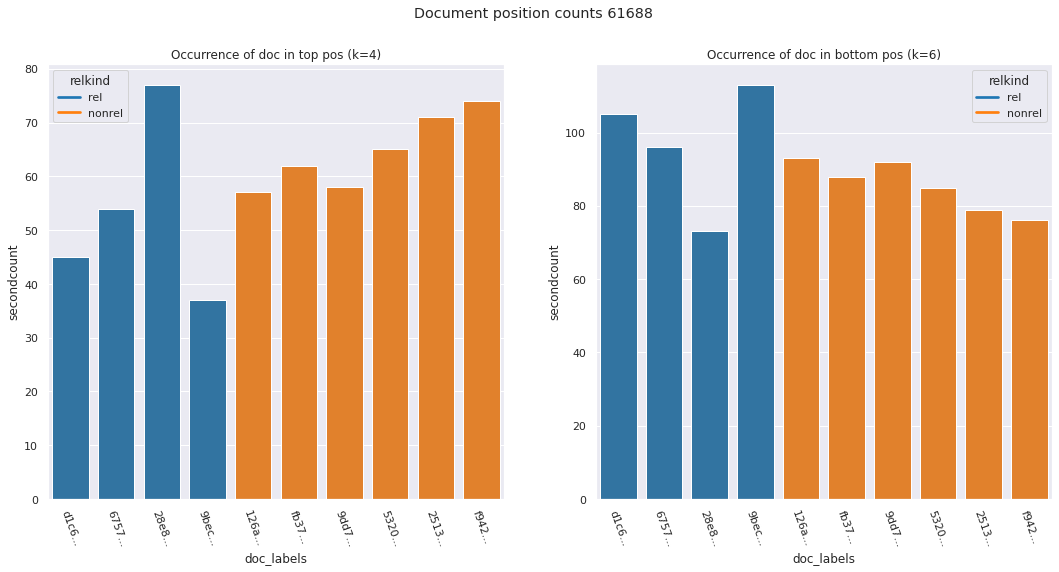

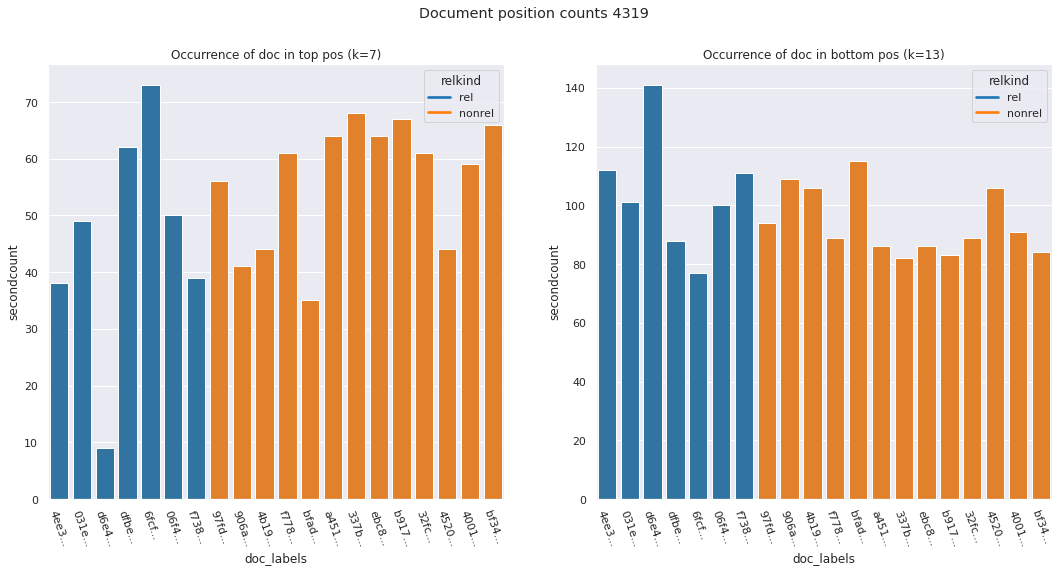

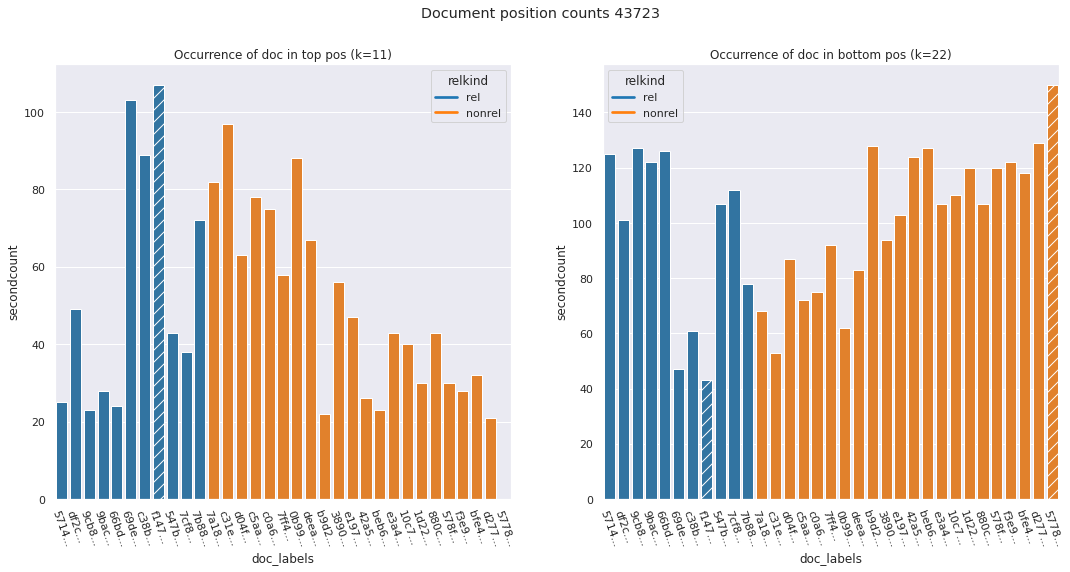

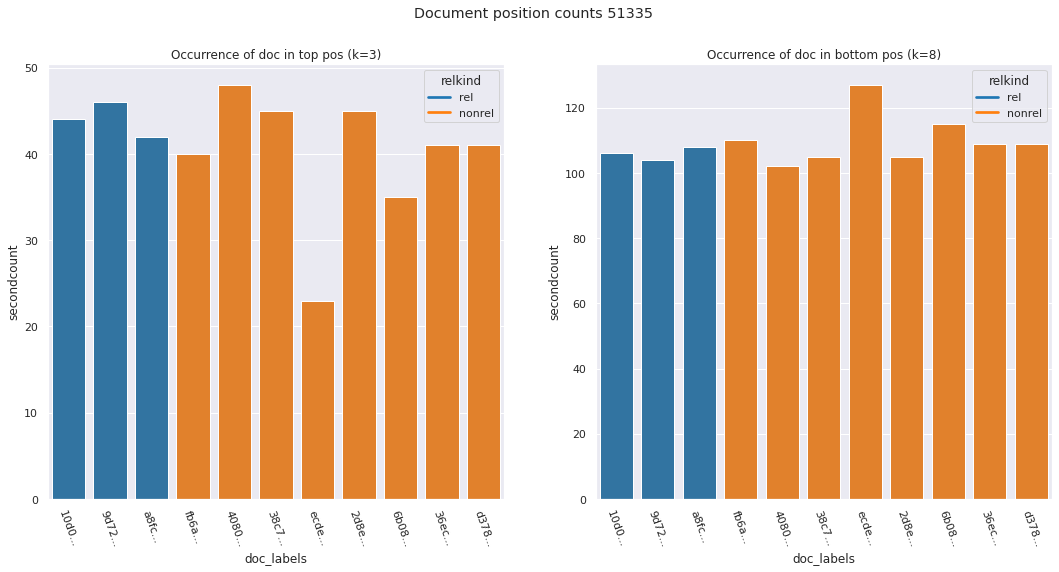

In [80]:
for q in topqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf,noauth_ids)

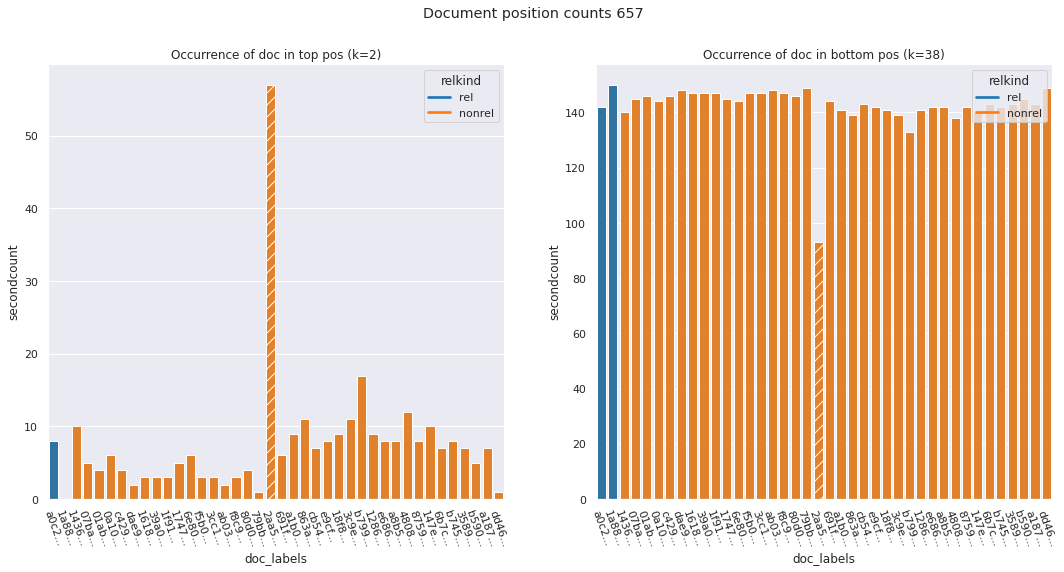

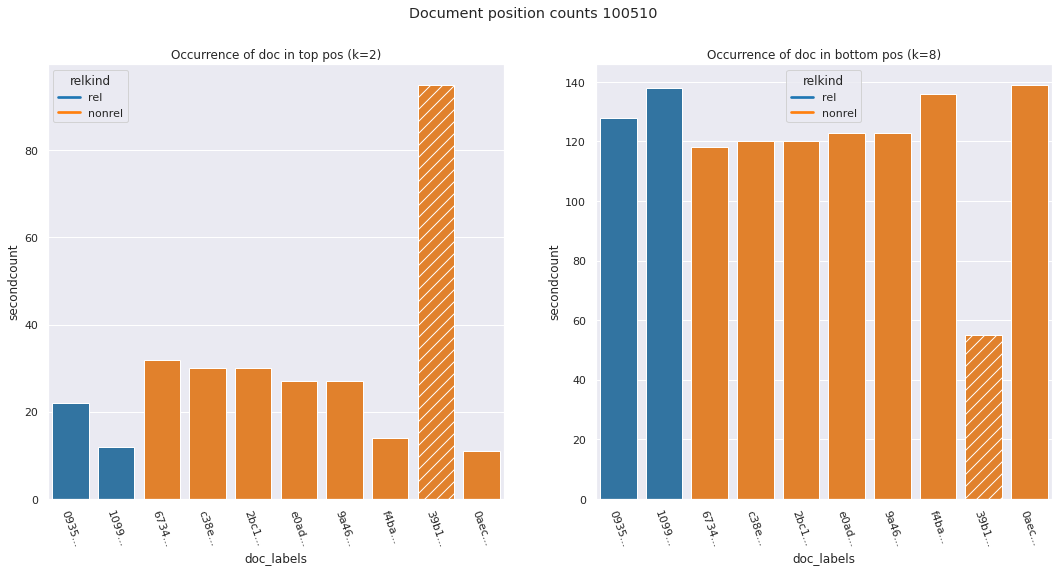

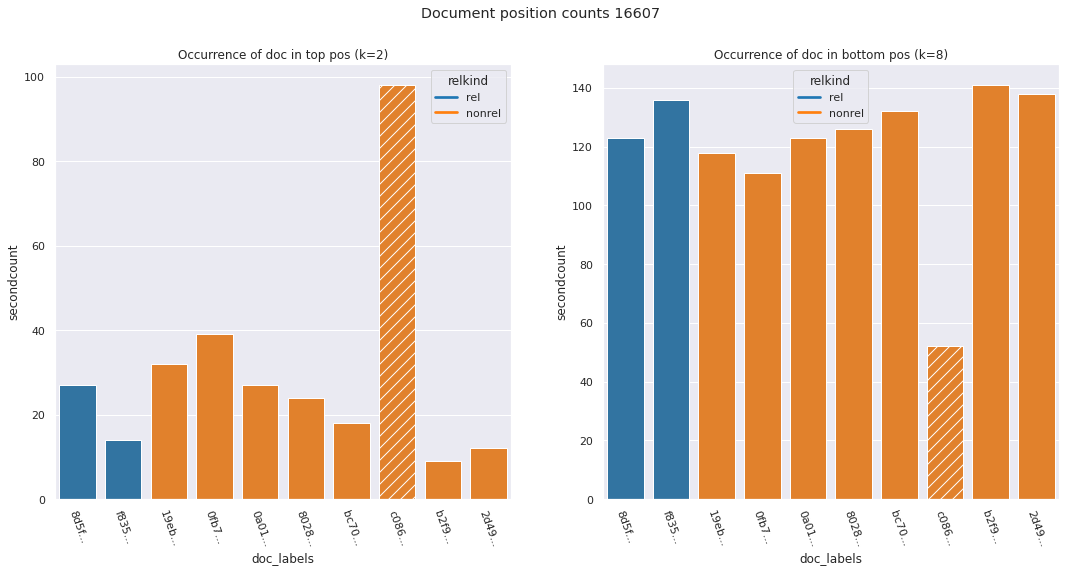

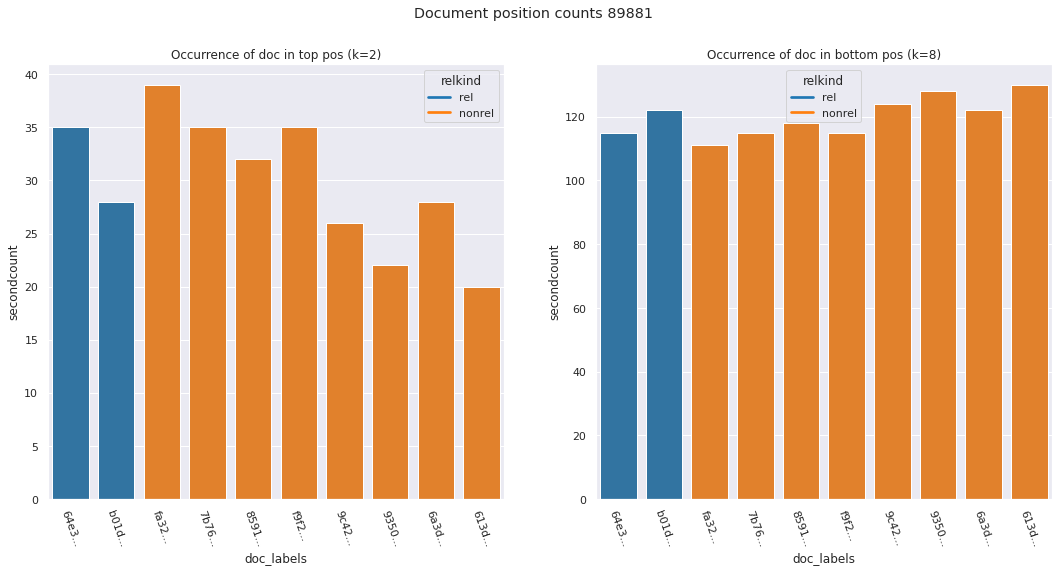

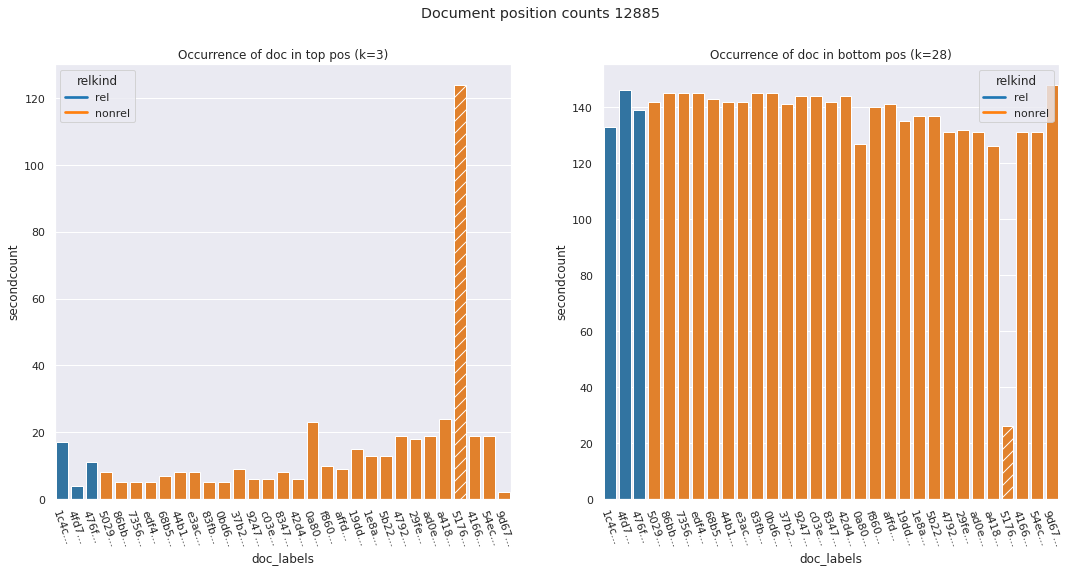

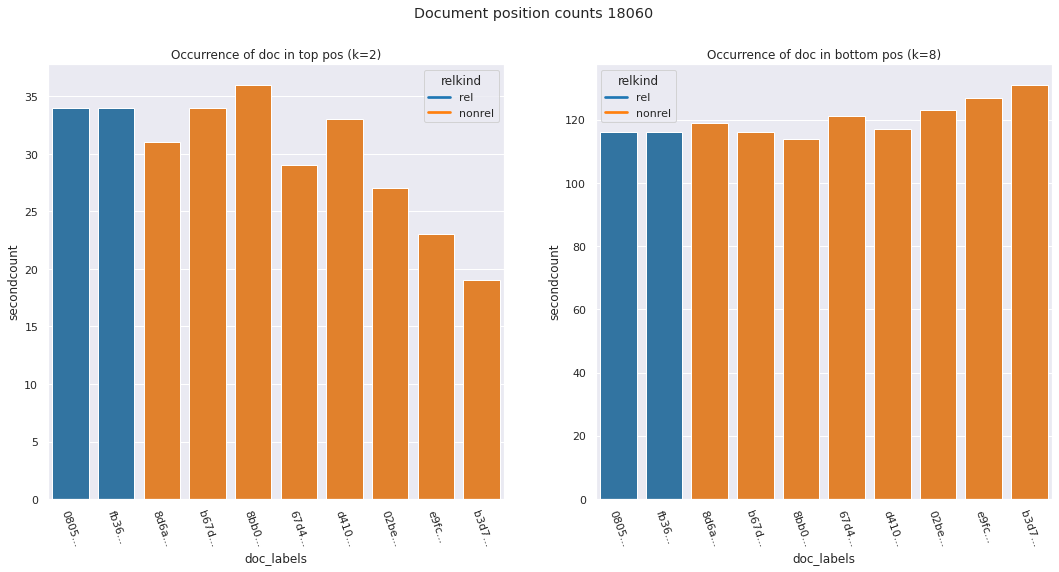

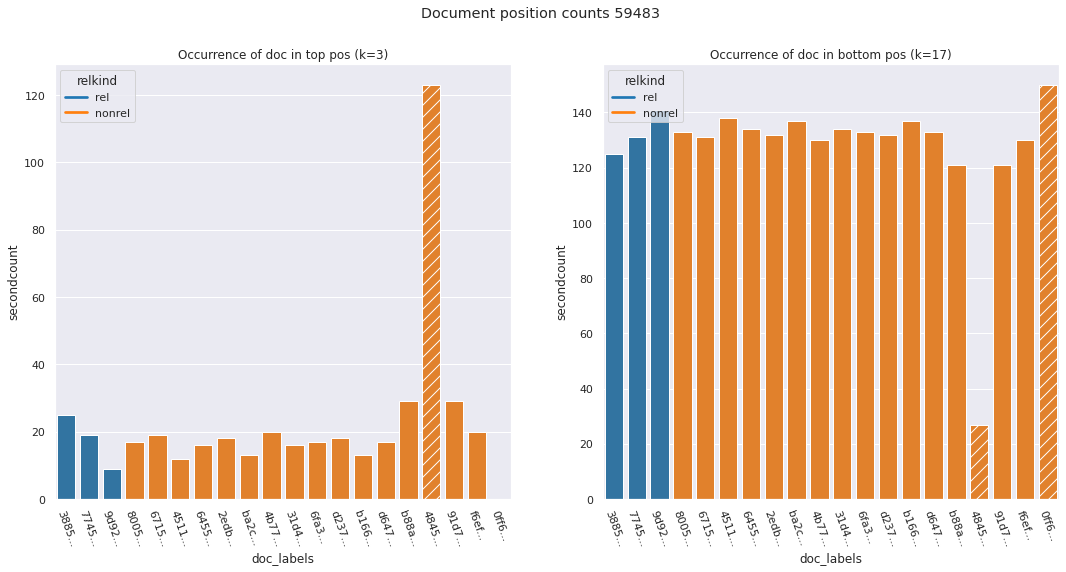

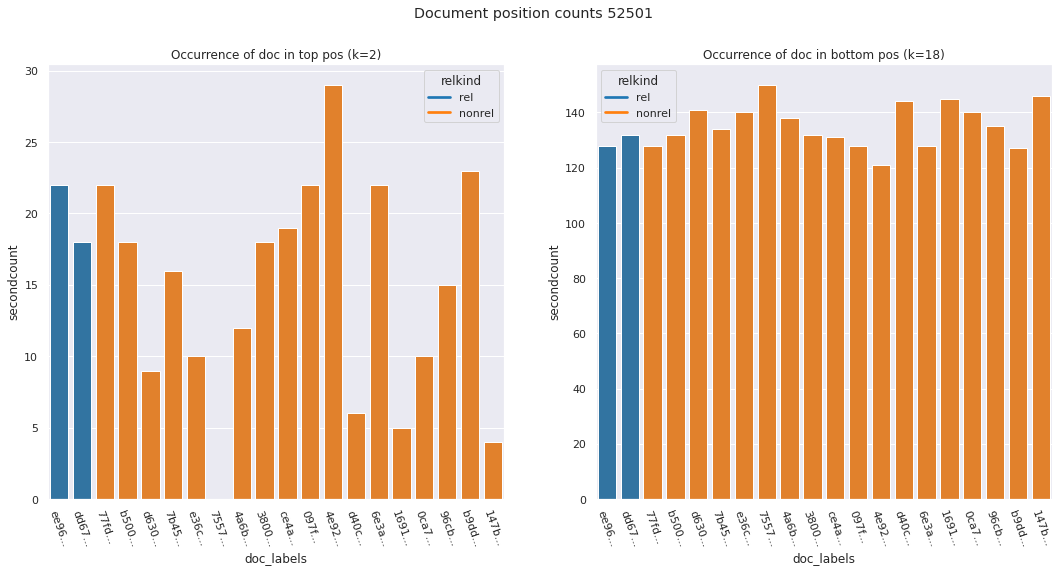

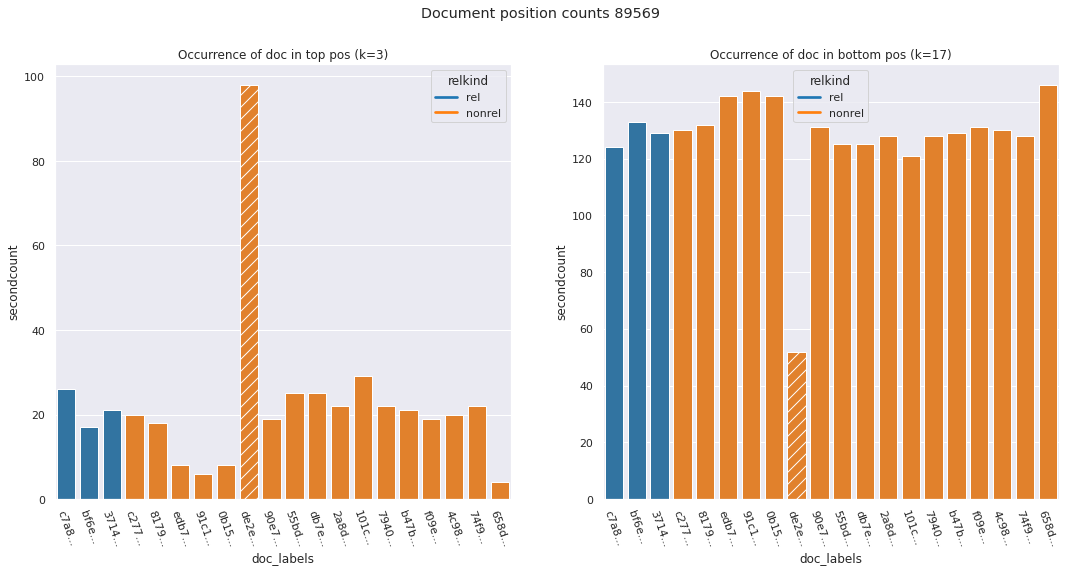

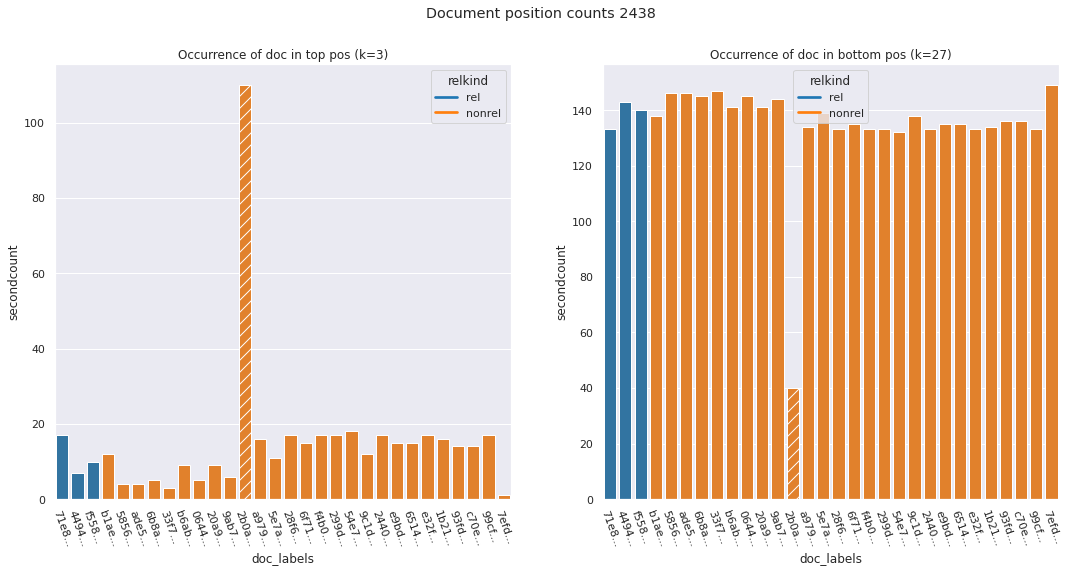

In [81]:
for q in bottomqueries.index.unique():
    plot_doc_pos_count_for_qid(q,rdf,reldf,noauth_ids)

In [82]:
extract_results_based_on_qid(9663,rdf).head()


q_num   qid                                            ranking
15300  102.0  9663  [9670485f526f2254c0f34e64d9ca06f665a0bd17, d51...
15301  102.1  9663  [1601e9f2bbf89f04f967a4f5f49d7adeca7f0719, e4b...
15302  102.2  9663  [a224d37a6023762fe465fd56e9c6ed00423a2930, 1a5...
15303  102.3  9663  [00a407540a8bdd6d7425bd8a561eb21d69682511, 8f3...
15304  102.4  9663  [79777fd5b433abe98adbbf53117ed604825b759b, d51...

In [83]:
extract_relevances_based_on_qid(9663,reldf).head()


qid        query                                    doc_id  doc_rel  \
102  9663  covid-19 ai  7ea2e329192ec1a5de459e1d0a1bd6652acf276d        1   
102  9663  covid-19 ai  52bf4421c628d0a0c4bc116732025facd0a4c186        0   
102  9663  covid-19 ai  b9a2d5b236adf57019c5d34e92f6acd6f1e31ade        1   
102  9663  covid-19 ai  4313bf44960b5b726028b55e76f1c9f99334e347        0   
102  9663  covid-19 ai  abc71fcde4dd1badea9def9a14b2a42251e5c263        0   

     has_author  
102        True  
102        True  
102        True  
102       False  
102        True

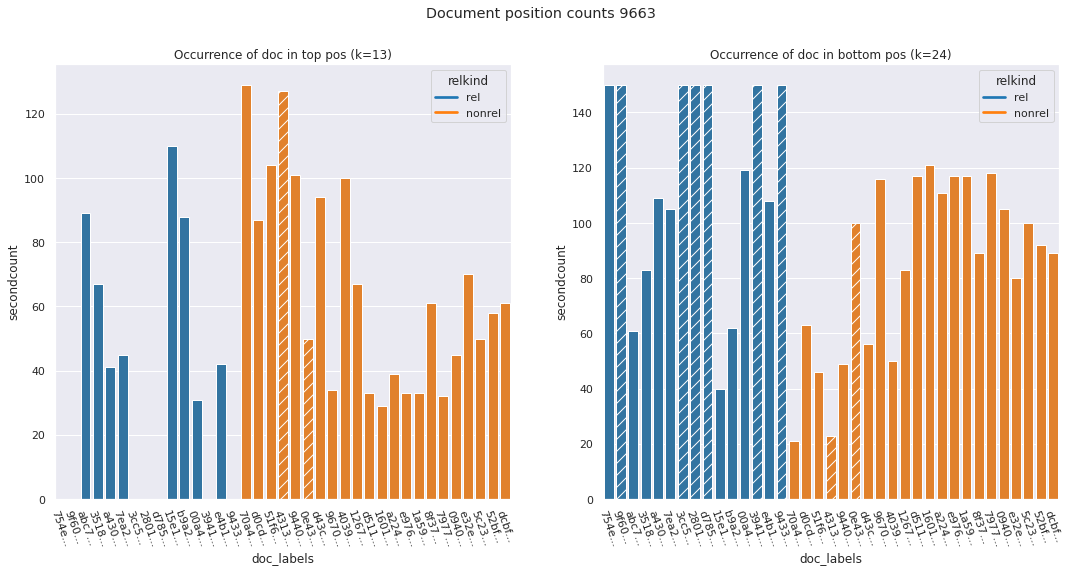

In [84]:
 plot_doc_pos_count_for_qid(9663,rdf,reldf,noauth_ids)

In [85]:
extract_relevances_based_on_qid(2573,reldf)

Empty DataFrame
Columns: [qid, query, doc_id, doc_rel, has_author]
Index: []

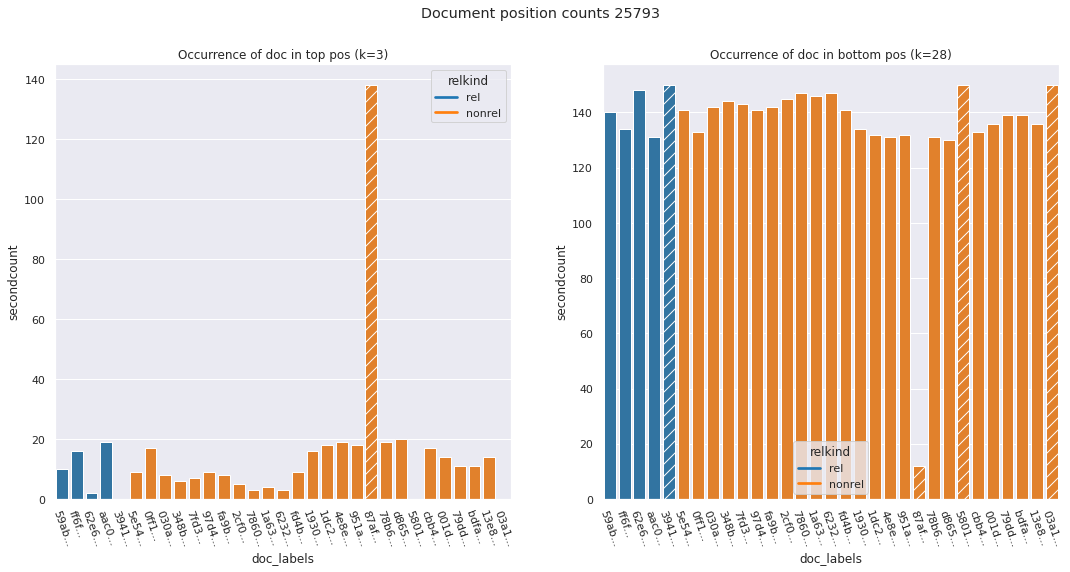

In [86]:
plot_doc_pos_count_for_qid(25793,rdf,reldf,noauth_ids)

In [87]:
noauth_ids

['26fcf1038b0ee7a445167d6e86d911a04eb17a89',
 'c6eeea1c03f3c87bfbb914e43cf9f3fc62138bad',
 '39b9ba20b3055b6715a73fa46a80291a06e6d8d4',
 'c298a8cb67fb3782595812f72cf5c909bcc3a137',
 '2aa5e431cd45476cc0432722dfa003a641790830',
 'b8f10c0d5e5c529ba0d8d32856ecb245e71faeac',
 '4f9b7fe029938305bfe5fd6c5fb66f4a01d83937',
 '1ef0ad9c9382693fd39d8cfbc25aab7929d89abe',
 '1f4fb325326176e6930ad73f9f66e11827e9ce88',
 '2b6cf01e98466347c55c61f3cfae4bdcc9813e86',
 '0e43caeb9d476264d307e8da0ad71ecc4d804ced',
 '989dea380aa2a226bcfb3eba72573eb6d0047087',
 'aee8a6d55b68e137d80790159c2253639ecb7d25',
 'a92d7bcf7b493dcc335fb1b84b139d28fce4eae9',
 '0ff0b49c9030ad1fee8548e46ee64ddba5a93e9c',
 '5801cf4ca157a72d45eb31d2bcca58cb849ce906',
 '2ae1e30e9630c9a97318fa733f8b5163dfc26279',
 '6cb893c4592d056ab315a9b618e0bda159ba9f8a',
 'caab5732b15e02809641710be9b02b50251f9be5',
 '2f3234917f0042c05dca113d2716c05654f39f90',
 'd5d02b093162096005834ee22def530de6c1f7eb',
 '3dc0ee51efd0e893fabb189c23ffd2b4a09ca70d',
 '28303076

In [88]:
#todo: this but only for those that have a no-autho doc
# for q in edf.sort_values(by='difference',ascending=True).index.unique():
#         plot_doc_pos_count_for_qid(q,rdf,reldf,noauth_ids)

Some remarks: 
- Many of the bottom queries indeed have a non-relevant no-author item in a top position, and no relevant no-author items.
- Out of the top queries, two have a relevant no-author item in a top position, and no non-relevant no-author items.


- 42723, 59483 has an additional no-author item in a bottom position, albeit only a little more often than other items
    - [ ] what is the estimated relevance of that document?
    
- there are still numerous rankings with (top?) documents missing from the ranking, why is that?

## Hypothesis: bottom queries have many items without author
- Because they aren't in the index
- Because they are in the index but don't have an author

1. Find all items in the index that do not have an author
2. Find all items that have an estimated relevance but aren't in the index
3. Check how many of the above items occur in the top and the bottom rankings

In [112]:
eval_ids = list(reldf.doc_id.unique())
eval_ids[:10]
len(eval_ids)

4693

In [113]:
est_rel_meta = '../reranking/resources/relevances/Evaluation_rel_scores_model_A.csv'
est_rel_meta = pd.read_csv(est_rel_meta)
est_rel_meta.head()

qid                                    doc_id  est_relevance
0  9087  40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4       0.131015
1  9087  008a2a2c765485af2e035a2572ba9fc1102eabff       0.208199
2  9087  4a1472c575488ed9acee6c5481f68b95a0c34092       0.129001
3  9087  ff8df0745136fb183ea72b783ff38f8a7ad5ceec       0.179983
4  9087  90605deb1da5e3d5548da12dc130fc0341a6a255       0.157544

In [114]:
est_rel_ids = list(est_rel_meta.doc_id.unique())
est_rel_ids[:10]
len(est_rel_ids)

4684

In [115]:
all_ids = list(set(eval_ids).union(set(est_rel_ids)))
len(all_ids)

4693

As established earlier in the research process, there are 9 items in the evaluation sample that do not have an estimated relevance.

In [116]:
no_author = find_docs_without_author(reldf)

Out of the items in the sample file, 4605 are also in the index.

26 items have no author in the index

In [117]:
topmerge = pd.merge(top[['qid']],reldf[['qid','query','doc_id']],on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

qid query                                    doc_id  has_author
0  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        True
1  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        True
2  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        True
3  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        True
4  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        True
5  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        True
6  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        True
7  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        True
8  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        True
9  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        True

In [118]:
botmerge = pd.merge(bot[['qid']],reldf[['qid','query','doc_id']],on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

qid query                                    doc_id  has_author
0  657  iran  a1b0feb1f82716b0e343453ca214912cfd3ea0e5        True
1  657  iran  b59004dc46558189fa4d846029ccb1ce3f079484        True
2  657  iran  17475d93c5d0b5b6396aa1d3a3928d6154b65695        True
3  657  iran  1436449e0234166b13135df45be1f072df059007        True
4  657  iran  18f883bd5b9ab9771e561a0214af6bd5ddda0d61        True
5  657  iran  a8b58f310e13c171ce7b7890d23860836cbc4534        True
6  657  iran  2aa5e431cd45476cc0432722dfa003a641790830       False
7  657  iran  cb547f0c206fafff203c66a169816f03360cfc89        True
8  657  iran  1a8800cdf999a01022f1db8e5c4c61306d3e43cc        True
9  657  iran  48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25        True

In [119]:
topmerge[(topmerge.has_author == False)]

qid                            query  \
62    21237                 visual landscape   
170   43723                fordyce　sebaceous   
189   43723                fordyce　sebaceous   
205    9663                      covid-19 ai   
213    9663                      covid-19 ai   
...     ...                              ...   
3329  14432                        thai mooc   
3427  34981                         homework   
3446  34981                         homework   
3459   6657  corporate social responsibility   
3473   6657  corporate social responsibility   

                                        doc_id  has_author  
62    ad5cf96ee7450784e2be79f786c5e54135df6519       False  
170   5778770d9169b220e1d2c7c18d6a7a80808481af       False  
189   f147f0511186715fb2fac0bec242eb30ff720e6b       False  
205   4313bf44960b5b726028b55e76f1c9f99334e347       False  
213   2801d473e9c29b3de614030be102fa7245806d00       False  
...                                        ...         ...  
3329  7d329b21731b8d1faaaabc0a237cfb0451539595       False  
3427  2c88b97376f69041f4e3cab0afac7920976e3278       False  
3446  273a5d30ae0083c24df5482240db377e437871ba       False  
3459  d15000938c8b8af5a07a2446a4e58615df844d71       False  
3473  eaf3420b867a79184ea3a4fe599be37e6a5cccfe       False  

[96 rows x 4 columns]

In [120]:
botmerge[(botmerge.has_author == False)]

qid                                     query  \
6        657                                      iran   
48    100510                      the yellow wallpaper   
58     16607                     disneyland and utopia   
80     12885                                simulation   
112    59483                                    newsql   
128    59483                                    newsql   
154    89569     qualitative research on brand loyalty   
197     2438                     tropical rocky shores   
205    13096                            adam optimizer   
224    13096                            adam optimizer   
449    15819                      service profit chain   
466    15819                      service profit chain   
522    60030        on demand orbital angular momentum   
525    61739              covid-19 mathematical models   
530    61739              covid-19 mathematical models   
557    38920                                     r-cnn   
697    21982                            disinformation   
733      822                      architectural design   
949    17329  application of immuno agglutination test   
961    52128              covid-19 symptom progression   
963    52128              covid-19 symptom progression   
965    52128              covid-19 symptom progression   
969    52128              covid-19 symptom progression   
972    52128              covid-19 symptom progression   
976    52128              covid-19 symptom progression   
983    51706                        covid-19 pediatric   
1125   15572                           uhpc steel slag   
1168   39540                                      clay   
1181    4000                            remote sensing   
1249   27924                       conflict management   
1283   60517                  laser therapy androgenic   
1289   60517                  laser therapy androgenic   

                                        doc_id  has_author  
6     2aa5e431cd45476cc0432722dfa003a641790830       False  
48    39b10d9aa0f0461f307b4f533d28009b48d294e9       False  
58    c0863b393ad68f2a136303ea3e313434a8daa79a       False  
80    5176327e639e6cb53a01c899665350443e3cacf9       False  
112   0ff67ddd8c55b468b7f1b2b19c8ae06429b6bc4a       False  
128   4845b32d9c4153ed299246282d2a06a3d324109c       False  
154   de2ee064a2e367fe8b45bec10f533bff8fdc0090       False  
197   2b0a62938189b6295d22e84e1866515491f64c1b       False  
205   b7919bcfa38aa97514187501a23c983e8eb5482b       False  
224   0ba531c0eaf44ace81b54aaee07750cad556edd0       False  
449   c6eeea1c03f3c87bfbb914e43cf9f3fc62138bad       False  
466   1f932f0d49a4c56d9718e8506d6177c6a6848831       False  
522   57f92b833e53f9bfe09cdf736c3fff7d17462289       False  
525   ce3690ed022a6c2ced95d893abd7eec221fceef6       False  
530   7afdf9319b1c8c4d1a5d5ab86bff147b03840c8d       False  
557   3a0130cfab8192a397d79fc1c7c398470157cf48       False  
697   6cb893c4592d056ab315a9b618e0bda159ba9f8a       False  
733   b07db8e20debcf024a9446842855478d65e39bfe       False  
949   39aab76e6b8c0827d10c81ecd42ed9464a384285       False  
961   ec588ed4ba504753ca7df27fd4c4e9481342a9d6       False  
963   f16f2aae49f330b9c0f885bf2eb5b4f8a9df00b7       False  
965   5801cf4ca157a72d45eb31d2bcca58cb849ce906       False  
969   1ef0ad9c9382693fd39d8cfbc25aab7929d89abe       False  
972   4313bf44960b5b726028b55e76f1c9f99334e347       False  
976   d7852b3c373fa1a5f0a00be37f7ef041763aec42       False  
983   4313bf44960b5b726028b55e76f1c9f99334e347       False  
1125  95e759f49978036b75ee66c71b29774d89d9be3e       False  
1168  0443ce97345589780866cda2cd01e1b390755983       False  
1181  e138280cc34b590ab6c15a2db3c0b7b6ba1d8a5a       False  
1249  a06ba1837e804fa5879ccd6d6b5f5ebdff9ee329       False  
1283  26fcf1038b0ee7a445167d6e86d911a04eb17a89       False  
1289  6fc5642b9aef8f090442e01d40640151e19bc6a5       False

In [121]:
top = get_k_results(edf,138,True)
bot = get_k_results(edf,62,False)
print(top)
print()
print(bot)

key    qid  difference  disparity  relevance
0    91643    0.019822   1.006921   0.868206
1     5191    0.044683   1.448939   1.344147
2    81479    0.046552   2.044160   1.889465
3    21237    0.053041   1.358547   1.149610
4     7363    0.053171   1.313280   1.085770
..     ...         ...        ...        ...
133  31385    0.379800   1.297175   1.100566
134  34981    0.383878   2.099273   1.330451
135  96522    0.386489   1.944350   1.278177
136   6657    0.407489   1.966829   1.610183
137  22230    0.409372   1.678485   0.954943

[138 rows x 4 columns]

key     qid  difference  disparity  relevance
0       657    3.700546   2.631709   0.255715
1    100510    3.252370   2.703133   0.514383
2     16607    3.034450   2.557715   0.550634
3     89881    1.987253   1.570899   0.577918
4     12885    1.941179   1.874742   0.848831
..      ...         ...        ...        ...
57     4000    0.469150   1.463646   0.995317
58    80079    0.458209   1.860573   1.564463
59   113942    0.4527

In [122]:
topmerge = pd.merge(top[['qid']],reldf,on='qid')
topmerge['has_author'] = topmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
topmerge.head(10)

qid query                                    doc_id  doc_rel  has_author
0  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True
1  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True
2  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        1        True
3  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True
4  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True
5  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        1        True
6  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        1        True
7  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        1        True
8  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        1        True
9  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        0        True

In [123]:
botmerge = pd.merge(bot[['qid']],reldf,on='qid')
botmerge['has_author'] = botmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
botmerge.head(10)

qid query                                    doc_id  doc_rel  has_author
0  657  iran  a1b0feb1f82716b0e343453ca214912cfd3ea0e5        0        True
1  657  iran  b59004dc46558189fa4d846029ccb1ce3f079484        0        True
2  657  iran  17475d93c5d0b5b6396aa1d3a3928d6154b65695        0        True
3  657  iran  1436449e0234166b13135df45be1f072df059007        0        True
4  657  iran  18f883bd5b9ab9771e561a0214af6bd5ddda0d61        0        True
5  657  iran  a8b58f310e13c171ce7b7890d23860836cbc4534        0        True
6  657  iran  2aa5e431cd45476cc0432722dfa003a641790830        0       False
7  657  iran  cb547f0c206fafff203c66a169816f03360cfc89        0        True
8  657  iran  1a8800cdf999a01022f1db8e5c4c61306d3e43cc        1        True
9  657  iran  48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25        0        True

only the presence of no-author files does not have to be an issue? or maybe when there are many nauthor docs on the total it levels out because they're all treated the same, so it basically devolves to "random"

In [124]:
botmerge[(botmerge.has_author == False)]

qid                                     query  \
6        657                                      iran   
48    100510                      the yellow wallpaper   
58     16607                     disneyland and utopia   
80     12885                                simulation   
112    59483                                    newsql   
128    59483                                    newsql   
154    89569     qualitative research on brand loyalty   
197     2438                     tropical rocky shores   
205    13096                            adam optimizer   
224    13096                            adam optimizer   
449    15819                      service profit chain   
466    15819                      service profit chain   
522    60030        on demand orbital angular momentum   
525    61739              covid-19 mathematical models   
530    61739              covid-19 mathematical models   
557    38920                                     r-cnn   
697    21982                            disinformation   
733      822                      architectural design   
949    17329  application of immuno agglutination test   
961    52128              covid-19 symptom progression   
963    52128              covid-19 symptom progression   
965    52128              covid-19 symptom progression   
969    52128              covid-19 symptom progression   
972    52128              covid-19 symptom progression   
976    52128              covid-19 symptom progression   
983    51706                        covid-19 pediatric   
1125   15572                           uhpc steel slag   
1168   39540                                      clay   
1181    4000                            remote sensing   
1249   27924                       conflict management   
1283   60517                  laser therapy androgenic   
1289   60517                  laser therapy androgenic   

                                        doc_id  doc_rel  has_author  
6     2aa5e431cd45476cc0432722dfa003a641790830        0       False  
48    39b10d9aa0f0461f307b4f533d28009b48d294e9        0       False  
58    c0863b393ad68f2a136303ea3e313434a8daa79a        0       False  
80    5176327e639e6cb53a01c899665350443e3cacf9        0       False  
112   0ff67ddd8c55b468b7f1b2b19c8ae06429b6bc4a        0       False  
128   4845b32d9c4153ed299246282d2a06a3d324109c        0       False  
154   de2ee064a2e367fe8b45bec10f533bff8fdc0090        0       False  
197   2b0a62938189b6295d22e84e1866515491f64c1b        0       False  
205   b7919bcfa38aa97514187501a23c983e8eb5482b        0       False  
224   0ba531c0eaf44ace81b54aaee07750cad556edd0        0       False  
449   c6eeea1c03f3c87bfbb914e43cf9f3fc62138bad        0       False  
466   1f932f0d49a4c56d9718e8506d6177c6a6848831        0       False  
522   57f92b833e53f9bfe09cdf736c3fff7d17462289        0       False  
525   ce3690ed022a6c2ced95d893abd7eec221fceef6        0       False  
530   7afdf9319b1c8c4d1a5d5ab86bff147b03840c8d        1       False  
557   3a0130cfab8192a397d79fc1c7c398470157cf48        0       False  
697   6cb893c4592d056ab315a9b618e0bda159ba9f8a        0       False  
733   b07db8e20debcf024a9446842855478d65e39bfe        0       False  
949   39aab76e6b8c0827d10c81ecd42ed9464a384285        0       False  
961   ec588ed4ba504753ca7df27fd4c4e9481342a9d6        0       False  
963   f16f2aae49f330b9c0f885bf2eb5b4f8a9df00b7        0       False  
965   5801cf4ca157a72d45eb31d2bcca58cb849ce906        0       False  
969   1ef0ad9c9382693fd39d8cfbc25aab7929d89abe        0       False  
972   4313bf44960b5b726028b55e76f1c9f99334e347        0       False  
976   d7852b3c373fa1a5f0a00be37f7ef041763aec42        1       False  
983   4313bf44960b5b726028b55e76f1c9f99334e347        0       False  
1125  95e759f49978036b75ee66c71b29774d89d9be3e        0       False  
1168  0443ce97345589780866cda2cd01e1b390755983        0       False  
1181  e138280cc34b590ab6c15a2db3c0b7b6ba1d8a5a        1       Fa

so, the top document for the worst query doesn't exist in the index. is this one of those documents that exist in the estimated rel files but not the index? --> yes
how are authorless docs treated in this case?
if there is no author, the advantage mean is set to 0. this means that the document is treated as never having an advantage so the hscore is always the same, namely hscore * rho(document)
the rho of 2aa5e431cd45476cc0432722dfa003a641790830 for nle meta is 0.0704727832842697

In [125]:
topmerge.head(10)

qid query                                    doc_id  doc_rel  has_author
0  91643  nazi  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True
1  91643  nazi  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True
2  91643  nazi  b2f24606271b959806061c64f81130e5ad75d410        1        True
3  91643  nazi  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True
4  91643  nazi  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True
5  91643  nazi  fb1a4e990af505ebef7c643c9231645695d9ce31        1        True
6  91643  nazi  f520d727e7e76253c1d77f26c573474437858593        1        True
7  91643  nazi  e38a47e6a3e62abf46804dc77b6e1c1deb3eb9e8        1        True
8  91643  nazi  17dafc3f0318b8711ca4f07783ef428568abb64b        1        True
9  91643  nazi  8954067bccf3f36cfb46f22c40df207028ecb63a        0        True

In [103]:
edf_sorted = edf.sort_values(by='difference').reset_index().reset_index()
edf_sorted.head()
edf_sorted_with_index = pd.merge(edf_sorted,reldf, on='qid')
edf_sorted_with_index.head()

index    qid  difference  disparity  relevance query  \
0      0  91643    0.019822   1.006921   0.868206  nazi   
1      0  91643    0.019822   1.006921   0.868206  nazi   
2      0  91643    0.019822   1.006921   0.868206  nazi   
3      0  91643    0.019822   1.006921   0.868206  nazi   
4      0  91643    0.019822   1.006921   0.868206  nazi   

                                     doc_id  doc_rel  has_author  
0  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True  
1  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True  
2  b2f24606271b959806061c64f81130e5ad75d410        1        True  
3  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True  
4  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True

In [104]:
allres = get_k_results(edf,200,True).reset_index()
allres.head(5)
allmerge = pd.merge(allres,reldf,on='qid')
allmerge['has_author'] = allmerge.apply(lambda row: row.doc_id not in no_author,axis='columns')
allmerge.head()

index    qid  difference  disparity  relevance query  \
0      0  91643    0.019822   1.006921   0.868206  nazi   
1      0  91643    0.019822   1.006921   0.868206  nazi   
2      0  91643    0.019822   1.006921   0.868206  nazi   
3      0  91643    0.019822   1.006921   0.868206  nazi   
4      0  91643    0.019822   1.006921   0.868206  nazi   

                                     doc_id  doc_rel  has_author  
0  6fa92e5b2f8d8912026e4e7e6c9a858528499966        1        True  
1  cdf1901567491b6ad5ecde7042895ec06e99e2b2        0        True  
2  b2f24606271b959806061c64f81130e5ad75d410        1        True  
3  10b0693b1f5fe596808c88b9cb14ea8ebc87654c        0        True  
4  4bbb91eb0fea54bd85774931e299efaaaa1b038f        0        True

In [105]:
all_qs_with_no_auth = allmerge.groupby('qid').filter(lambda df: not df.has_author.all())
all_qs_with_no_auth = all_qs_with_no_auth[['index','qid','difference','query','doc_id','doc_rel', 'has_author']]
len(all_qs_with_no_auth.qid.unique())

58

There are 58 queries for which one or more documents don't have an author.

In [106]:
all_qs_with_no_auth.qid.unique()

array([ 21237,  43723,   9663,  16738,  30379,  67407,  23456,  11322,
         1323,  13083,   5864,  25793,  45776,  12887,  29728, 109863,
         7856,  50315,   1353,   9317, 114159,   6538,  19518,  13170,
        25448,   5098,  32866,  20970,   7122,  22268,   8338,  52620,
           95,  14432,  34981,   6657,  60517,  27924,   4000,  39540,
        15572,  51706,  52128,  17329,    822,  21982,  38920,  61739,
        60030,  15819,  13096,   2438,  89569,  59483,  12885,  16607,
       100510,    657])

In [107]:
all_qs_with_no_auth['index'].unique().mean()

108.8103448275862

Since the mean is higher than the half of the number of rankings the later ranking are slightly heavier on docs w/out authors.

<AxesSubplot:xlabel='index'>

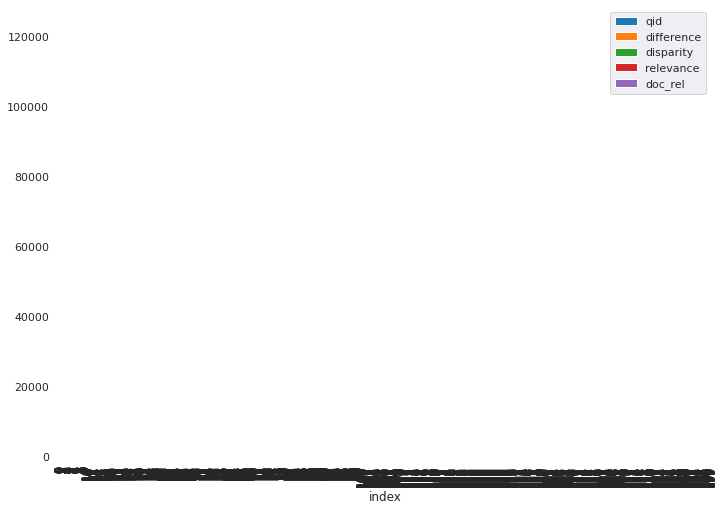

In [108]:
allmerge.set_index('index').plot(kind='bar', stacked=True)

In [109]:
data.head()

key  index    qid  difference  disparity  relevance   r  nr     rfrac  \
0        0  91643    0.019822   1.006921   0.868206  11   9  0.550000   
1        1   5191    0.044683   1.448939   1.344147   6   5  0.545455   
2        2  81479    0.046552   2.044160   1.889465   3   7  0.300000   
3        3  21237    0.053041   1.358547   1.149610   3  28  0.096774   
4        4   7363    0.053171   1.313280   1.085770   2  10  0.166667   

key    nrfrac  
0    0.450000  
1    0.454545  
2    0.700000  
3    0.903226  
4    0.833333

In [110]:
crossdata = pd.crosstab(data['index'],[data['doc_rel'],data['has_author']])

KeyError: 'doc_rel'

In [ ]:
crossdata.head().columns

In [ ]:
crossdata[(0,False)].to_list()

In [ ]:
crossdata.head().index.to_list()

In [ ]:
np.arange(len(rel_has_author)*2,step=2)

In [111]:
rel_has_author = np.array(crossdata[(1,True)].to_list())
rel_not_has_author = np.array(crossdata[(1,False)].to_list())
nonrel_has_author = np.array(crossdata[(0,True)].to_list())
nonrel_not_has_author = np.array(crossdata[(0,False)].to_list())
qid = crossdata.index.to_list()

with sns.axes_style("white"):
    sns.set(rc={'figure.figsize':(100,17)})
    sns.set_style("ticks")
    sns.set_context("talk")
    
    # plot details
    bar_width = 5
    epsilon = .015
    line_width = 1
    opacity = 0.7
    pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
    neg_bar_positions = pos_bar_positions + bar_width

    # make bar plots
    rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                              color='#ED0020',
                              label='rel + author')
    print(rel_has_author)
    rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                              bottom=rel_has_author,
                              alpha=opacity,
                              color='white',
                              edgecolor='#ED0020',
                              linewidth=line_width,
                              hatch='//',
                              label='rel + no author')
    
    nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                              color='#0000DD',
                              label='not rel + author')
    nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                              bottom=nonrel_has_author,
                              color="white",
                              hatch='//',
                              edgecolor='#0000DD',
                              ecolor="#0000DD",
                              linewidth=line_width,
                              label='not rel + no author')
    
    plt.xticks(neg_bar_positions, qid, rotation=90)
    plt.ylabel('Percentage of Samples')
    plt.legend(loc='best')
    sns.despine()

NameError: name 'crossdata' is not defined

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[-10:]

In [ ]:
crossdata.index.to_list()[len(crossdata.index.to_list())-10:len(crossdata.index.to_list())]

In [ ]:
crossdata.index.to_list()[:10]

In [ ]:
def plot_has_authors(crossdata,k=10,asc=True):
    if asc:
        slstart = 0
        slend = k
    else:
        slstart = len(crossdata.index.to_list())-k
        slend = len(crossdata.index.to_list())
    
    
    rel_has_author = np.array(crossdata[(1,True)].to_list()[slstart:slend])
    rel_not_has_author = np.array(crossdata[(1,False)].to_list()[slstart:slend])
    nonrel_has_author = np.array(crossdata[(0,True)].to_list()[slstart:slend])
    nonrel_not_has_author = np.array(crossdata[(0,False)].to_list()[slstart:slend])
    qid = crossdata.index.to_list()[slstart:slend]

    with sns.axes_style("white"):
        sns.set(rc={'figure.figsize':(100,17)})
        sns.set_style("ticks")
        sns.set_context("talk")

        # plot details
        bar_width = 4
        epsilon = .015
        line_width = 1
        opacity = 0.7
        pos_bar_positions = np.arange(len(rel_has_author)*2*bar_width,step=2*bar_width)
        neg_bar_positions = pos_bar_positions + bar_width

        # make bar plots
        rel_has_author_bar = plt.bar(pos_bar_positions, rel_has_author, bar_width,
                                  color='#ED0020',
                                  label='rel + author')
        print(rel_has_author)
        rel_not_has_author_bar = plt.bar(pos_bar_positions, rel_not_has_author, bar_width-epsilon,
                                  bottom=rel_has_author,
                                  alpha=opacity,
                                  color='white',
                                  edgecolor='#ED0020',
                                  linewidth=line_width,
                                  hatch='//',
                                  label='rel + no author')

        nonrel_has_author_bar = plt.bar(neg_bar_positions, nonrel_has_author, bar_width,
                                  color='#0000DD',
                                  label='not rel + author')
        nonrel_not_has_author_bar = plt.bar(neg_bar_positions, nonrel_not_has_author, bar_width-epsilon,
                                  bottom=nonrel_has_author,
                                  color="white",
                                  hatch='//',
                                  edgecolor='#0000DD',
                                  ecolor="#0000DD",
                                  linewidth=line_width,
                                  label='not rel + no author')

        plt.xticks(neg_bar_positions, qid, rotation=90)
        plt.ylabel('Num docs')
        plt.legend(loc='best')
        sns.despine()

In [ ]:
plot_has_authors(crossdata)

In [ ]:
plot_has_authors(crossdata,asc=False)

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# dat[dat['index'] <= 10]

In [ ]:
dat = crossdata.unstack().reset_index().rename({0:'count'},axis=1)
# fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))

g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] <= 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)


In [ ]:
g = sns.catplot(x="index", y="count",
                hue="has_author", col="doc_rel",
                data=dat[dat['index'] >= len(dat['index'].unique()) - 20], kind="bar",
                height=4, aspect=1)
g.fig.set_size_inches(22,8.27)

Hypothesis was: bottom queries have many items without author


- Bottom queries mainly have nonrel items without author
- Top queries have both rel and nonrel items without author

Still to check: 


In [ ]:
est_rel_meta.describe()

In [ ]:
reldf.describe()

In [ ]:
pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').describe()

In [ ]:
est_and_rel = pd.merge(est_rel_meta,reldf,on=['qid','doc_id'],how='outer').fillna(0)
est_and_rel.head()

In [ ]:
 sns.stripplot(x="doc_rel", y="est_relevance", data=est_and_rel)

interestingly, none of the estimated values are very high? why is that? and there are three points that have rel 1 but are estimated very low, interesting to see if those cause some low results in the rankings

## Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.